In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

Full data

In [522]:
df = pd.read_json("results/task1/task1_data.json", lines=True)
#replace llama3.2 in the model column with llama3b
df['model'] = df['model'].replace('llama3.2', 'llama3b').replace('llama3.3', 'llama70b')
#replace llama3.2 in the model column with llama3b

#replace llama3.2 in the model column with llama3b
df['prompt'] = df['prompt'].replace('no', 'benchmark').replace('prompt1', 'persona')

df.drop(columns=['all_fit'], inplace=True)

df.rename(
    columns={
        'c_all_fit_hits': 'correct_match',
        'r_all_fit_hits': 'related_match',
        'r_all_fit_recall': 'related_recall'
    },
    inplace=True
)

code_path = "datasets/occupation.xlsx"
zone_path = "datasets/job_zone.xlsx"
# Read the Excel file
occupation = pd.read_excel(code_path)
occupation.drop(columns=['Description'], inplace=True)
occupation.columns = ['code', 'title']

zone = pd.read_excel(zone_path)
zone = zone[['Title', 'Job Zone']]
zone.columns = ['title', 'zone']

# Merge the occupation data with the main dataframe
df = df.merge(occupation, left_on='title', right_on='title', how='left')
df = df.merge(zone, left_on='title', right_on='title', how='left')
df["area"] = df["code"].apply(lambda x: x.split("-")[0])
df

title  iteration  \
0                                      Chief Executives          0   
1                         Chief Sustainability Officers          0   
2                       General and Operations Managers          0   
3                                           Legislators          0   
4                   Advertising and Promotions Managers          0   
...                                                 ...        ...   
73835  Gas Compressor and Gas Pumping Station Operators          9   
73836           Pump Operators, Except Wellhead Pumpers          9   
73837                                  Wellhead Pumpers          9   
73838         Refuse and Recyclable Material Collectors          9   
73839                 Tank Car, Truck, and Ship Loaders          9   

       correct_match  related_match  related_recall        model     prompt  \
0                  1              1             0.5  deepseek-r1  benchmark   
1                  1              1             0.1  deepseek-r1  benchmark   
2                  0              0             0.0  deepseek-r1  benchmark   
3                  0              0             0.0  deepseek-r1  benchmark   
4                  0              1             0.9  deepseek-r1  benchmark   
...              ...            ...             ...          ...        ...   
73835              0              1             0.2      mistral    persona   
73836              0              0             0.0      mistral    persona   
73837              0              0             0.0      mistral    persona   
73838              0              0             0.0      mistral    persona   
73839              0              0             0.0      mistral    persona   

             code  zone area  
0      11-1011.00     5   11  
1      11-1011.03     5   11  
2      11-1021.00     4   11  
3      11-1031.00     4   11  
4      11-2011.00     4   11  
...           ...   ...  ...  
73835  53-7071.00     2   53  
73836  53-7072.00     2   53  
73837  53-7073.00     2   53  
73838  53-7081.00     2   53  
73839  53-7121.00     2   53  

[73840 rows x 10 columns]

In [4]:
# Ensure correct data types (especially for categorical grouping)
df['zone'] = df['zone'].astype(str)
df['area'] = df['area'].astype(str)
df['prompt'] = pd.Categorical(df['prompt'], categories=['benchmark', 'persona'], ordered=True)

outcome_metrics = ['correct_match', 'related_match', 'related_recall']
descriptive_stats = {}

print("--- Descriptive Statistics Overview ---")

models = df['model'].unique()
prompts = df['prompt'].unique()
# Loop through each model and calculate descriptive statistics


for model in models:
    df_model = df[df['model'] == model]
    for prompt in prompts:
        df_prompt = df_model[df_model['prompt'] == prompt]
        # 1. Overall Statistics
        print(f"\nOverall Performance {model} - {prompt} (Mean, Median, SD)")
        overall_stats = df_prompt[outcome_metrics].agg(['mean', 'median', 'std'])
        descriptive_stats[f'overall_{model}'] = overall_stats
        print(overall_stats)



--- Descriptive Statistics Overview ---

Overall Performance deepseek-r1 - benchmark (Mean, Median, SD)
        correct_match  related_match  related_recall
mean         0.079198       0.267606        0.065038
median       0.000000       0.000000        0.000000
std          0.270063       0.442735        0.141248

Overall Performance deepseek-r1 - persona (Mean, Median, SD)
        correct_match  related_match  related_recall
mean         0.218310        0.54442        0.177053
median       0.000000        1.00000        0.100000
std          0.413121        0.49805        0.220452

Overall Performance llama3b - benchmark (Mean, Median, SD)
        correct_match  related_match  related_recall
mean         0.153738       0.392849        0.131528
median       0.000000       0.000000        0.000000
std          0.360717       0.488410        0.214908

Overall Performance llama3b - persona (Mean, Median, SD)
        correct_match  related_match  related_recall
mean         0.314735      

In [5]:
import pandas as pd
import numpy as np

# Ensure correct data types (especially for categorical grouping)
df['zone'] = df['zone'].astype(str)
df['area'] = df['area'].astype(str)
df['prompt'] = pd.Categorical(df['prompt'], categories=['benchmark', 'persona'], ordered=True)
df['model'] = df['model'].astype('category') # Ensure model is a category

# --- 2. Define Outcome Metrics ---
outcome_metrics = ['correct_match', 'related_match', 'related_recall']

# --- 3. Generate the Descriptive Statistics Table (Per Model, Per Prompt) ---
print("--- Descriptive Statistics by LLM Model and Prompt Type (Mean, Median, SD) ---")

# Group by 'model' and 'prompt' and aggregate
model_prompt_stats = df.groupby(['model', 'prompt'])[outcome_metrics].agg(['mean', 'median', 'std'])

# Unstack the 'prompt' level to make it the top-level column
# This gives the desired structure: Prompt -> Metric -> Stat
model_prompt_stats_unstacked = model_prompt_stats.unstack('prompt')

# # Optional: Improve column names for presentation
# model_prompt_stats_unstacked.columns = pd.MultiIndex.from_tuples([
#     (f"{prompt_level.capitalize()}", f"{metric_level.replace('_', ' ').title()}", stat_level)
#     for prompt_level, metric_level, stat_level in model_prompt_stats_unstacked.columns
# ])

# Sort columns for consistent order: Benchmark first, then persona
# And within each, Metric -> Stat
model_prompt_stats_unstacked = model_prompt_stats_unstacked.sort_index(axis=1, level=[0, 1, 2])

# Print the DataFrame (rounded for better readability)
print(model_prompt_stats_unstacked.round(3))



--- Descriptive Statistics by LLM Model and Prompt Type (Mean, Median, SD) ---
            correct_match                                              \
                     mean            median               std           
prompt          benchmark persona benchmark persona benchmark persona   
model                                                                   
deepseek-r1         0.079   0.218       0.0     0.0     0.270   0.413   
llama3b             0.154   0.315       0.0     0.0     0.361   0.464   
llama70b            0.319   0.362       0.0     0.0     0.466   0.481   
mistral             0.112   0.228       0.0     0.0     0.315   0.419   

            related_match                                              \
                     mean            median               std           
prompt          benchmark persona benchmark persona benchmark persona   
model                                                                   
deepseek-r1         0.268   0.544       0.0 

C:\Users\godfr\AppData\Local\Temp\ipykernel_24228\3310939908.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  model_prompt_stats = df.groupby(['model', 'prompt'])[outcome_metrics].agg(['mean', 'median', 'std'])


In [6]:
outcome_metrics = ['correct_match', 'related_match', 'related_recall']
for metric in outcome_metrics:
    bch = model_prompt_stats_unstacked[(metric, 'mean', 'benchmark')]
    per = model_prompt_stats_unstacked[(metric, 'mean', 'persona')]
    # Calculate the percentage difference
    percentage_difference = ((per - bch) / bch) * 100
    # add the percentage difference to the DataFrame
    model_prompt_stats_unstacked[(metric,'mean', 'percentage_difference')] = percentage_difference
model_prompt_stats_unstacked.round(3)['related_recall'].sort_values(by=('mean', 'percentage_difference'), ascending=False)

mean            median               std          \
prompt      benchmark persona benchmark persona benchmark persona   
model                                                               
deepseek-r1     0.065   0.177       0.0     0.1     0.141   0.220   
llama3b         0.132   0.257       0.0     0.2     0.215   0.246   
mistral         0.100   0.193       0.0     0.1     0.181   0.235   
llama70b        0.256   0.292       0.2     0.3     0.248   0.255   

                             mean  
prompt      percentage_difference  
model                              
deepseek-r1               172.231  
llama3b                    95.198  
mistral                    91.962  
llama70b                   13.962

In [7]:
df_test = df[df['model'] == 'mistral']
df_test

title  iteration  \
55380                                  Chief Executives          0   
55381                     Chief Sustainability Officers          0   
55382                   General and Operations Managers          0   
55383                                       Legislators          0   
55384               Advertising and Promotions Managers          0   
...                                                 ...        ...   
73835  Gas Compressor and Gas Pumping Station Operators          9   
73836           Pump Operators, Except Wellhead Pumpers          9   
73837                                  Wellhead Pumpers          9   
73838         Refuse and Recyclable Material Collectors          9   
73839                 Tank Car, Truck, and Ship Loaders          9   

       correct_match  related_match  related_recall    model     prompt  \
55380              0              1             0.4  mistral  benchmark   
55381              0              0             0.0  mistral  benchmark   
55382              0              1             0.5  mistral  benchmark   
55383              0              0             0.0  mistral  benchmark   
55384              0              1             0.8  mistral  benchmark   
...              ...            ...             ...      ...        ...   
73835              0              1             0.2  mistral    persona   
73836              0              0             0.0  mistral    persona   
73837              0              0             0.0  mistral    persona   
73838              0              0             0.0  mistral    persona   
73839              0              0             0.0  mistral    persona   

             code zone area  
55380  11-1011.00    5   11  
55381  11-1011.03    5   11  
55382  11-1021.00    4   11  
55383  11-1031.00    4   11  
55384  11-2011.00    4   11  
...           ...  ...  ...  
73835  53-7071.00    2   53  
73836  53-7072.00    2   53  
73837  53-7073.00    2   53  
73838  53-7081.00    2   53  
73839  53-7121.00    2   53  

[18460 rows x 10 columns]

In [29]:
df['correct_match'] = df['correct_match'].astype('int')  # Ensure model is a category
df['related_match'] = df['related_match'].astype('int')  # Ensure model is a category
df['related_recall'] = df['related_recall'].astype('float')  # Ensure model is a category

Averaged match rate

In [41]:
# Corrected aggregation syntax using a dictionary
df_avg = df.groupby(["title", "model", "prompt"]).agg({
	"correct_match": "mean",
	"related_match": "mean",
	"related_recall": "mean",
	"code": "first",
	"zone": "first",
	"area": "first"
}).reset_index()

df_avg

C:\Users\godfr\AppData\Local\Temp\ipykernel_24228\1136043778.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_avg = df.groupby(["title", "model", "prompt"]).agg({


title        model     prompt  \
0               Accountants and Auditors  deepseek-r1  benchmark   
1               Accountants and Auditors  deepseek-r1    persona   
2               Accountants and Auditors      llama3b  benchmark   
3               Accountants and Auditors      llama3b    persona   
4               Accountants and Auditors     llama70b  benchmark   
...                                  ...          ...        ...   
7379  Zoologists and Wildlife Biologists      llama3b    persona   
7380  Zoologists and Wildlife Biologists     llama70b  benchmark   
7381  Zoologists and Wildlife Biologists     llama70b    persona   
7382  Zoologists and Wildlife Biologists      mistral  benchmark   
7383  Zoologists and Wildlife Biologists      mistral    persona   

      correct_match  related_match  related_recall        code zone area  
0               0.0            0.0            0.00  13-2011.00    4   13  
1               0.0            1.0            0.59  13-2011.00    4   13  
2               0.0            1.0            0.56  13-2011.00    4   13  
3               0.0            1.0            0.60  13-2011.00    4   13  
4               0.0            1.0            0.56  13-2011.00    4   13  
...             ...            ...             ...         ...  ...  ...  
7379            0.0            1.0            0.40  19-1023.00    4   19  
7380            0.0            1.0            0.33  19-1023.00    4   19  
7381            0.0            1.0            0.39  19-1023.00    4   19  
7382            0.0            0.0            0.00  19-1023.00    4   19  
7383            0.0            1.0            0.16  19-1023.00    4   19  

[7384 rows x 9 columns]

Correct Match Pivot

In [42]:
df_pivot = df.pivot_table(index=["title", "area", "zone", "model", "iteration"], columns=["prompt"], values="correct_match").reset_index()
df_pivot["difference"] = df_pivot["persona"] - df_pivot["benchmark"]
df_related_hit_pivot = df.pivot_table(index=["title", "area", "zone", "model", "iteration"], columns=["prompt"], values="related_match").reset_index()
df_related_hit_pivot["difference"] = df_related_hit_pivot["persona"] - df_related_hit_pivot["benchmark"]
df_recall_pivot = df.pivot_table(index=["title", "area", "zone", "model", "iteration"], columns=["prompt"], values="related_recall").reset_index()
df_recall_pivot["difference"] = df_recall_pivot["persona"] - df_recall_pivot["benchmark"]
df_pivot

C:\Users\godfr\AppData\Local\Temp\ipykernel_24228\2491184102.py:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  df_pivot = df.pivot_table(index=["title", "area", "zone", "model", "iteration"], columns=["prompt"], values="correct_match").reset_index()
C:\Users\godfr\AppData\Local\Temp\ipykernel_24228\2491184102.py:3: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  df_related_hit_pivot = df.pivot_table(index=["title", "area", "zone", "model", "iteration"], columns=["prompt"], values="related_match").reset_index()
C:\Users\godfr\AppData\Local\Temp\ipykernel_24228\2491184102.py:5: FutureWarning: The default value of observed=False is deprecated and will change to obser

prompt                               title area zone        model  iteration  \
0                 Accountants and Auditors   13    4  deepseek-r1          0   
1                 Accountants and Auditors   13    4  deepseek-r1          1   
2                 Accountants and Auditors   13    4  deepseek-r1          2   
3                 Accountants and Auditors   13    4  deepseek-r1          3   
4                 Accountants and Auditors   13    4  deepseek-r1          4   
...                                    ...  ...  ...          ...        ...   
36915   Zoologists and Wildlife Biologists   19    4      mistral          5   
36916   Zoologists and Wildlife Biologists   19    4      mistral          6   
36917   Zoologists and Wildlife Biologists   19    4      mistral          7   
36918   Zoologists and Wildlife Biologists   19    4      mistral          8   
36919   Zoologists and Wildlife Biologists   19    4      mistral          9   

prompt  benchmark  persona  difference  
0             0.0      0.0         0.0  
1             0.0      0.0         0.0  
2             0.0      0.0         0.0  
3             0.0      0.0         0.0  
4             0.0      0.0         0.0  
...           ...      ...         ...  
36915         0.0      0.0         0.0  
36916         0.0      0.0         0.0  
36917         0.0      0.0         0.0  
36918         0.0      0.0         0.0  
36919         0.0      0.0         0.0  

[36920 rows x 8 columns]

In [43]:
deepseek = df_avg[df_avg["model"] == "deepseek-r1"]
llama3b = df_avg[df_avg["model"] == "llama3b"]
llama70b = df_avg[df_avg["model"] == "llama70b"]
mistral = df_avg[df_avg["model"] == "mistral"]

### Descriptive Stats

### Correct Match

In [44]:
plt.figure(figsize=(15, 5))

# Calculate the maximum y-value across all plots
max_y = max(
    deepseek["correct_match"].value_counts().max(),
    llama3b["correct_match"].value_counts().max(),
    llama70b["correct_match"].value_counts().max(),
    mistral["correct_match"].value_counts().max()
)
#add a title to the plot
plt.suptitle("Distribution of Average Correct Match", fontsize=16)
# Plot the distribution of the data
plt.subplot(1, 4, 1)
sns.histplot(data=deepseek, x="correct_match", hue="prompt", bins=11, kde=True, alpha=0.7, edgecolor=None,)  
plt.xlabel("Match Rate")
plt.ylabel("Job Count")
plt.yscale('log')
plt.ylim(1, max_y)  # Set the same y-axis limit
plt.title("Deepseek-r1")

plt.subplot(1,4, 2)
sns.histplot(data=llama3b, x="correct_match", hue="prompt", bins=11, kde=True, alpha=0.7, edgecolor=None,)  
plt.xlabel("Match Rate")
plt.ylabel("Job Count")
plt.yscale('log')
plt.ylim(1, max_y)  # Set the same y-axis limit
plt.title("Llama3b")

plt.subplot(1, 4, 3)
sns.histplot(data=llama70b, x="correct_match", hue="prompt", bins=11, kde=True, alpha=0.7, edgecolor=None,)  
plt.xlabel("Match Rate")
plt.ylabel("Job Count")
plt.yscale('log')
plt.ylim(1, max_y)  # Set the same y-axis limit
plt.title("Llama70b")

plt.subplot(1, 4, 4)
sns.histplot(data=mistral, x="correct_match", hue="prompt", bins=11, kde=True, alpha=0.7, edgecolor=None,)  
plt.xlabel("Match Rate")
plt.ylabel("Job Count")
plt.yscale('log')
plt.ylim(1, max_y)  # Set the same y-axis limit
plt.title("Mistral")

plt.tight_layout()
plt.show()

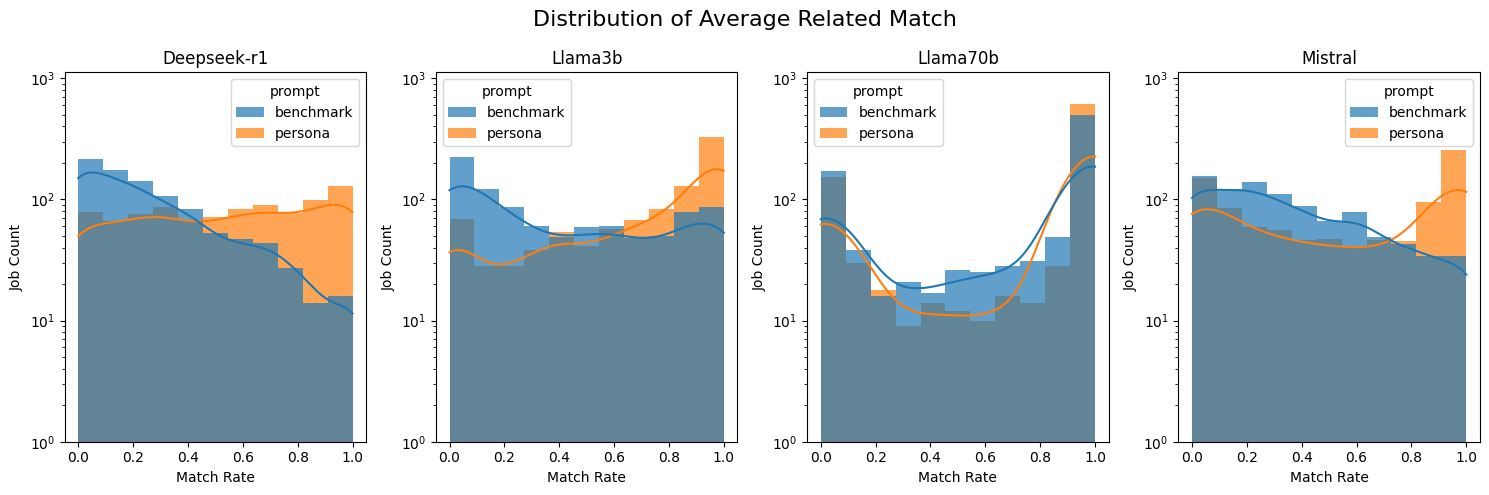

In [45]:
plt.figure(figsize=(15, 5))

# Calculate the maximum y-value across all plots
max_y = max(
    deepseek["related_match"].value_counts().max(),
    llama3b["related_match"].value_counts().max(),
    llama70b["related_match"].value_counts().max(),
    mistral["related_match"].value_counts().max()
)
#add a title to the plot
plt.suptitle("Distribution of Average Related Match", fontsize=16)
# Plot the distribution of the data
plt.subplot(1, 4, 1)
sns.histplot(data=deepseek, x="related_match", hue="prompt", bins=11, kde=True, alpha=0.7, edgecolor=None,)  
plt.xlabel("Match Rate")
plt.ylabel("Job Count")
plt.yscale('log')
plt.ylim(1, max_y)  # Set the same y-axis limit
plt.title("Deepseek-r1")

plt.subplot(1,4, 2)
sns.histplot(data=llama3b, x="related_match", hue="prompt", bins=11, kde=True, alpha=0.7, edgecolor=None,)  
plt.xlabel("Match Rate")
plt.ylabel("Job Count")
plt.yscale('log')
plt.ylim(1, max_y)  # Set the same y-axis limit
plt.title("Llama3b")

plt.subplot(1, 4, 3)
sns.histplot(data=llama70b, x="related_match", hue="prompt", bins=11, kde=True, alpha=0.7, edgecolor=None,)  
plt.xlabel("Match Rate")
plt.ylabel("Job Count")
plt.yscale('log')
plt.ylim(1, max_y)  # Set the same y-axis limit
plt.title("Llama70b")

plt.subplot(1, 4, 4)
sns.histplot(data=mistral, x="related_match", hue="prompt", bins=11, kde=True, alpha=0.7, edgecolor=None,)  
plt.xlabel("Match Rate")
plt.ylabel("Job Count")
plt.yscale('log')
plt.ylim(1, max_y)  # Set the same y-axis limit
plt.title("Mistral")

plt.tight_layout()
plt.show()

In [46]:
plt.figure(figsize=(15, 5))

# Calculate the maximum y-value across all plots
max_y = max(
    deepseek["related_recall"].value_counts().max(),
    llama3b["related_recall"].value_counts().max(),
    llama70b["related_recall"].value_counts().max(),
    mistral["related_recall"].value_counts().max()
)
#add a title to the plot
plt.suptitle("Distribution of Average Recall of Related Jobs", fontsize=16)
# Plot the distribution of the data
plt.subplot(1, 4, 1)
sns.histplot(data=deepseek, x="related_recall", hue="prompt", bins=11, kde=True, alpha=0.7, edgecolor=None,)  
plt.xlabel("Average Recall")
plt.ylabel("Job Count")
plt.yscale('log')
plt.ylim(1, 700)  # Set the same y-axis limit
plt.xlim(0, 1)  # Set x-axis limit to [0, 1]
plt.title("Deepseek-r1")

plt.subplot(1,4, 2)
sns.histplot(data=llama3b, x="related_recall", hue="prompt", bins=11, kde=True, alpha=0.7, edgecolor=None,)  
plt.xlabel("Average Recall")
plt.ylabel("Job Count")
plt.yscale('log')
plt.ylim(1, 700)  # Set the same y-axis limit
plt.title("Llama3b")

plt.subplot(1, 4, 3)
sns.histplot(data=llama70b, x="related_recall", hue="prompt", bins=11, kde=True, alpha=0.7, edgecolor=None,)  
plt.xlabel("Average Recall")
plt.ylabel("Job Count")
plt.yscale('log')
plt.ylim(1, 700)  # Set the same y-axis limit
plt.title("Llama70b")

plt.subplot(1, 4, 4)
sns.histplot(data=mistral, x="related_recall", hue="prompt", bins=11, kde=True, alpha=0.7, edgecolor=None,)  
plt.xlabel("Average Recall")
plt.ylabel("Job Count")
plt.yscale('log')
plt.ylim(1, 700)  # Set the same y-axis limit
plt.title("Mistral")

plt.tight_layout()
plt.show()

more occupations get a higher correct match rate using persona than benchmark. For llama70b, more occupations get a 100% correct match than benchmark.

In [47]:
df_avg.query("model == 'mistral'and zone == 5" )[["prompt", "related_match", "related_recall"]].groupby("prompt").mean().round(3).sort_values(by="related_recall", ascending=False)

C:\Users\godfr\AppData\Local\Temp\ipykernel_24228\1630588249.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_avg.query("model == 'mistral'and zone == 5" )[["prompt", "related_match", "related_recall"]].groupby("prompt").mean().round(3).sort_values(by="related_recall", ascending=False)


related_match  related_recall
prompt                                  
benchmark            NaN             NaN
persona              NaN             NaN

In [48]:
df_avg

title        model     prompt  \
0               Accountants and Auditors  deepseek-r1  benchmark   
1               Accountants and Auditors  deepseek-r1    persona   
2               Accountants and Auditors      llama3b  benchmark   
3               Accountants and Auditors      llama3b    persona   
4               Accountants and Auditors     llama70b  benchmark   
...                                  ...          ...        ...   
7379  Zoologists and Wildlife Biologists      llama3b    persona   
7380  Zoologists and Wildlife Biologists     llama70b  benchmark   
7381  Zoologists and Wildlife Biologists     llama70b    persona   
7382  Zoologists and Wildlife Biologists      mistral  benchmark   
7383  Zoologists and Wildlife Biologists      mistral    persona   

      correct_match  related_match  related_recall        code zone area  
0               0.0            0.0            0.00  13-2011.00    4   13  
1               0.0            1.0            0.59  13-2011.00    4   13  
2               0.0            1.0            0.56  13-2011.00    4   13  
3               0.0            1.0            0.60  13-2011.00    4   13  
4               0.0            1.0            0.56  13-2011.00    4   13  
...             ...            ...             ...         ...  ...  ...  
7379            0.0            1.0            0.40  19-1023.00    4   19  
7380            0.0            1.0            0.33  19-1023.00    4   19  
7381            0.0            1.0            0.39  19-1023.00    4   19  
7382            0.0            0.0            0.00  19-1023.00    4   19  
7383            0.0            1.0            0.16  19-1023.00    4   19  

[7384 rows x 9 columns]

looking at Average correct match = 0, at least half of the occupation do not get a match in all 10 rounds. However, persona prompt helped more occupation to get more matches.

C:\Users\godfr\AppData\Local\Temp\ipykernel_24228\2453686176.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_hits = df_avg.groupby(["model", "prompt"])["related_match"].mean().reset_index()


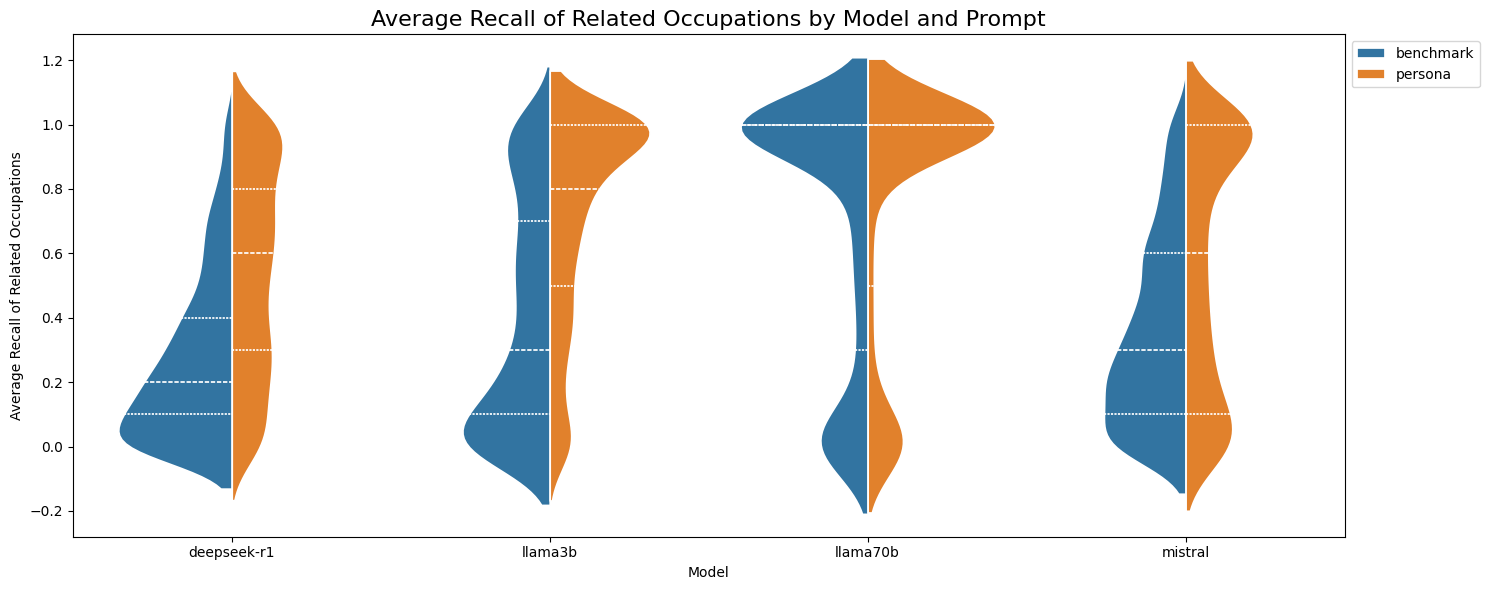

In [516]:
# Calculate the average related_match for each model and prompt
avg_hits = df_avg.groupby(["model", "prompt"])["related_match"].mean().reset_index()

# Create a single barplot
plt.figure(figsize=(15, 6))

# sns.stripplot(data=df_avg, x="model", y="related_match", hue="prompt", dodge=True, 
#               size=5, alpha=0.05, jitter=True)
sns.violinplot(data=df_avg, x="model", y="related_match", hue="prompt", split=True, inner="quartile",bw_adjust=1, alpha=1, edgecolor="white")


# Add labels and title
plt.title("Average Recall of Related Occupations by Model and Prompt", fontsize=16)
plt.xlabel("Model")
plt.ylabel("Average Recall of Related Occupations")
 # Ensure some padding on the y-axis, no box around the legend
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')

# Show the plot
plt.tight_layout()
plt.show()

In [473]:
df_area_new

iteration area        model     prompt  correct_match
0             0   11  deepseek-r1  benchmark       0.285714
1             0   11  deepseek-r1    persona       0.392857
2             0   11      llama3b  benchmark       0.285714
3             0   11      llama3b    persona       0.428571
4             0   11     llama70b  benchmark       0.553571
...         ...  ...          ...        ...            ...
1755          9   53      llama3b    persona       0.153846
1756          9   53     llama70b  benchmark       0.076923
1757          9   53     llama70b    persona       0.076923
1758          9   53      mistral  benchmark       0.038462
1759          9   53      mistral    persona       0.134615

[1760 rows x 5 columns]

C:\Users\godfr\AppData\Local\Temp\ipykernel_24228\766774476.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_avg_area = df_avg.groupby(["area", "model", "prompt"])["correct_match"].mean().reset_index()


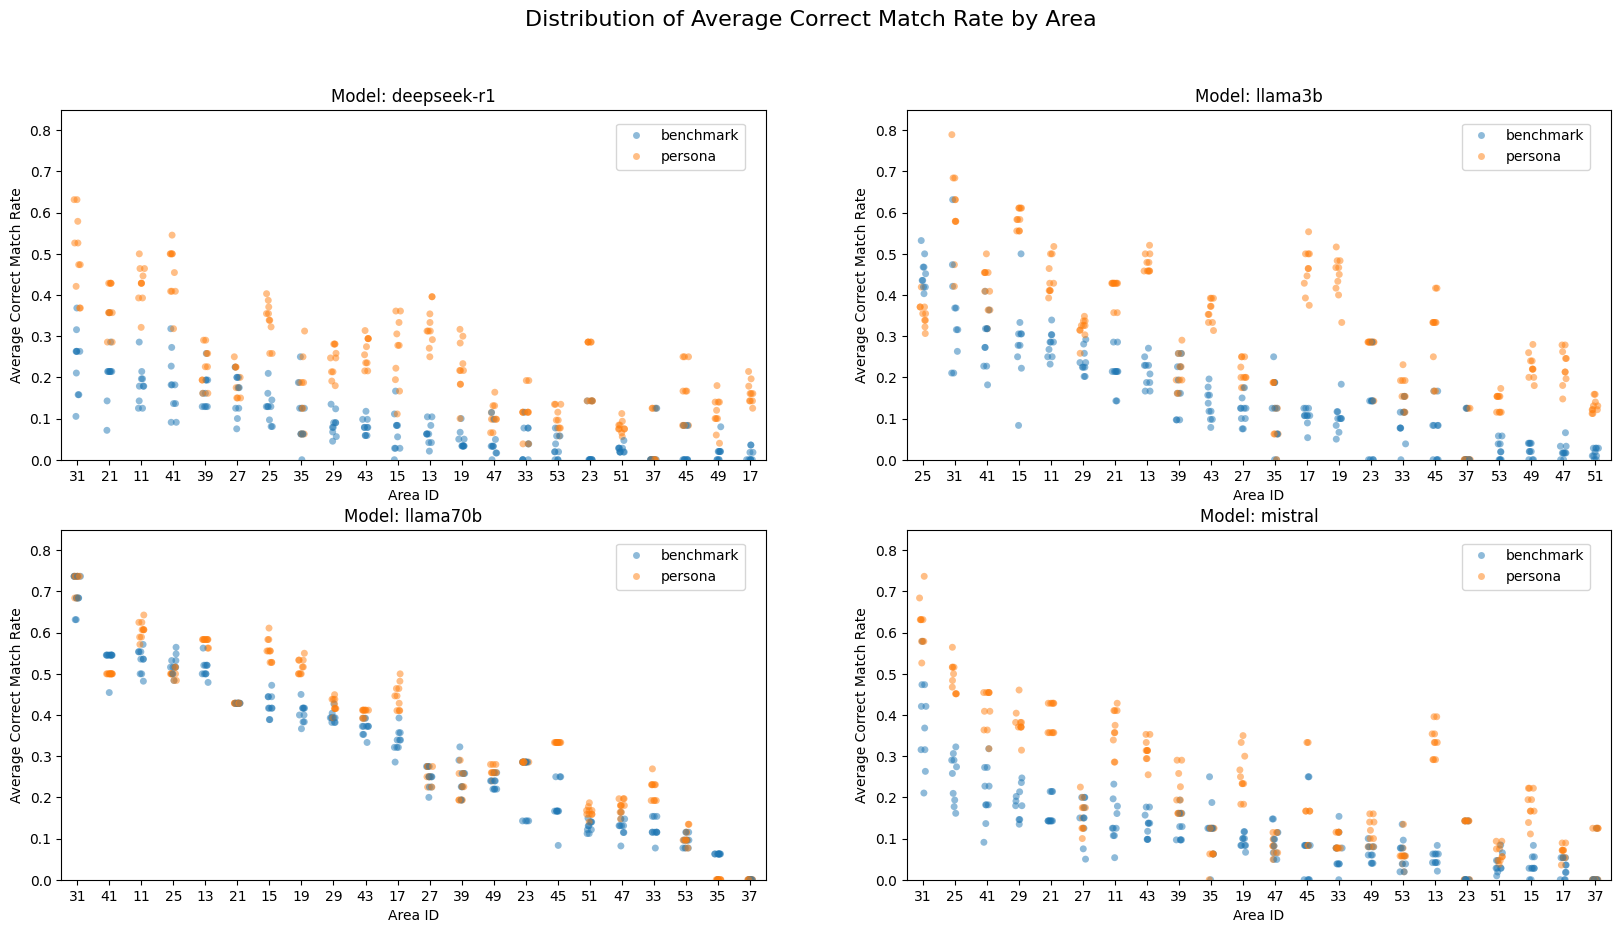

In [528]:
df_avg_area = df_avg.groupby(["area", "model", "prompt"])["correct_match"].mean().reset_index()
df_area_new = df.groupby(["iteration","area", "model", "prompt"])["correct_match"].mean().reset_index()

models = ["deepseek-r1", "llama3b", "llama70b", "mistral"]

plt.figure(figsize=(20, 10))
plt.suptitle("Distribution of Average Correct Match Rate by Area", fontsize=16)

for i, model in enumerate(models, 1):
    plt.subplot(2, 2, i)
    df_model = df_area_new[df_area_new['model'] == model].copy()

    df_diff = df_model[df_model['prompt']=='benchmark'].groupby('area')[['correct_match']].mean()
    df_diff_sorted = df_diff.sort_values(by='correct_match', ascending=False).index
    sns.stripplot(data=df_model, x="area", y="correct_match", hue="prompt", dodge=False, 
              size=5, alpha=0.5, jitter=True, order=df_diff_sorted)
    plt.title(f'Model: {model}')
    plt.xlabel('Area ID')
    plt.ylabel('Average Correct Match Rate')
    plt.xticks()#rotation=45, ha='right', fontsize=8)  # Adjust fontsize if needed
    plt.ylim(0, 0.85)  # Set y-axis limit to [0, 1] for correct match rate
# Add the legend to the entire figure outside the loop
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles[:], labels[:], loc='upper right', bbox_to_anchor=(0.98, 0.98))
plt.show()

In [525]:
df_avg_area = df_avg.groupby(["area", "model", "prompt"])["related_match"].mean().reset_index()
df_area_new = df.groupby(["iteration","area", "model", "prompt"])["related_match"].mean().reset_index()

models = ["deepseek-r1", "llama3b", "llama70b", "mistral"]

plt.figure(figsize=(20, 12))
plt.suptitle("Distribution of Average Related Match Rate by Area", fontsize=16)

for i, model in enumerate(models, 1):
    plt.subplot(2, 2, i)
    df_model = df_area_new[df_area_new['model'] == model].copy()

    df_diff = df_model[df_model['prompt'] == 'benchmark'].groupby('area')[['related_match']].mean()
    df_diff_sorted = df_diff.sort_values(by='related_match', ascending=False).index
    sns.stripplot(data=df_model, x="area", y="related_match", hue="prompt", dodge=False, 
              size=5, alpha=0.5, jitter=True, order=df_diff_sorted)
    plt.title(f'Model: {model}')
    plt.xlabel('Area ID')
    plt.ylabel('Match Rate')
    plt.xticks()#rotation=45, ha='right', fontsize=8)  # Adjust fontsize if needed
    plt.ylim(0, 1.1)  # Set y-axis limit to [0, 1] for correct match rate
# Add the legend to the entire figure outside the loop
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles[:], labels[:], loc='upper right', bbox_to_anchor=(0.98, 0.98))
plt.show()

C:\Users\godfr\AppData\Local\Temp\ipykernel_24228\1343351465.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_avg_area = df_avg.groupby(["area", "model", "prompt"])["related_match"].mean().reset_index()


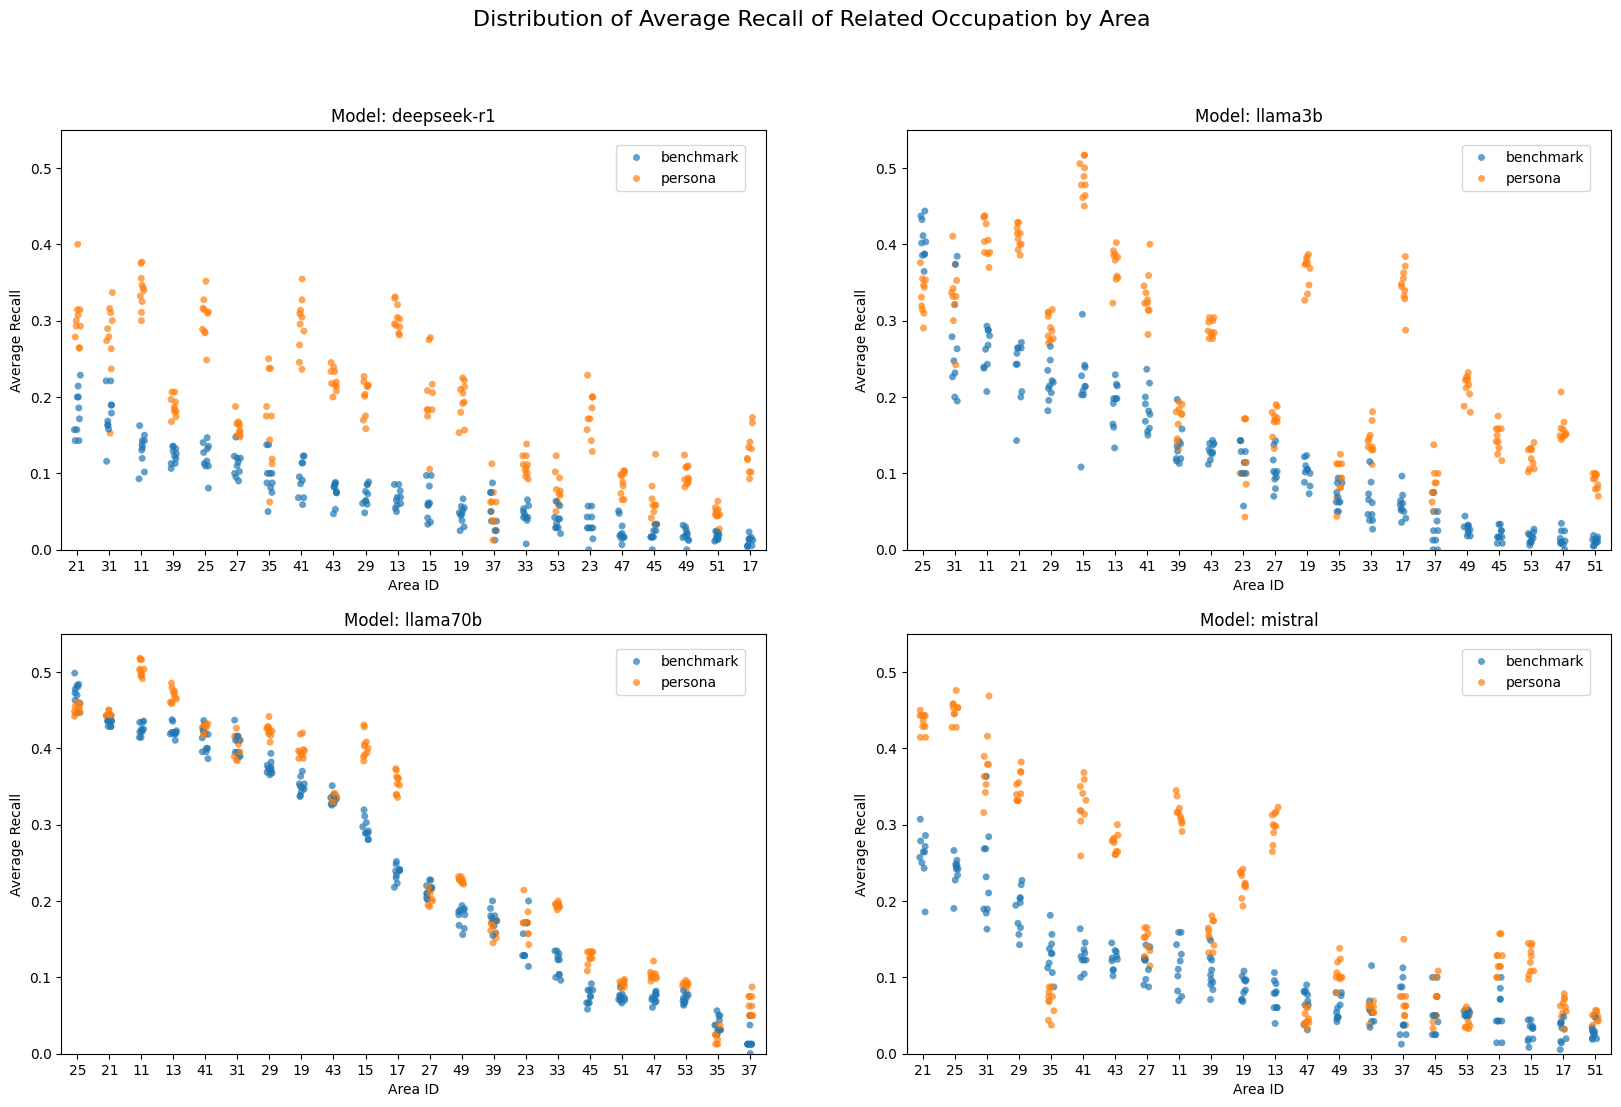

In [526]:
df_area_new = df.groupby(["iteration","area", "model", "prompt"])["related_recall"].mean().reset_index()

models = ["deepseek-r1", "llama3b", "llama70b", "mistral"]

plt.figure(figsize=(20, 12))
plt.suptitle("Distribution of Average Recall of Related Occupation by Area", fontsize=16)

for i, model in enumerate(models, 1):
    plt.subplot(2, 2, i)
    df_model = df_area_new[df_area_new['model'] == model].copy()

    df_diff = df_model[df_model['prompt'] == 'benchmark'].groupby('area')[['related_recall']].mean()
    df_diff_sorted = df_diff.sort_values(by='related_recall', ascending=False).index
    sns.stripplot(data=df_model, x="area", y="related_recall", hue="prompt", dodge=False, 
              size=5, alpha=0.7, jitter=True, order=df_diff_sorted)
    plt.title(f'Model: {model}')
    plt.xlabel('Area ID')
    plt.ylabel('Average Recall')
    plt.xticks()#rotation=45, ha='right', fontsize=8)  # Adjust fontsize if needed
    plt.ylim(0, 0.55)  # Set y-axis limit to [0, 1] for correct match rate
# Add the legend to the entire figure outside the loop
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles[:], labels[:], loc='upper right', bbox_to_anchor=(0.98, 0.98))
plt.show()

In [520]:
df_model.groupby('area')[['correct_match']]

In [477]:
df.groupby(["iteration","area", "model", "prompt"])["correct_match"].mean().reset_index()

iteration area        model     prompt  correct_match
0             0   11  deepseek-r1  benchmark       0.285714
1             0   11  deepseek-r1    persona       0.392857
2             0   11      llama3b  benchmark       0.285714
3             0   11      llama3b    persona       0.428571
4             0   11     llama70b  benchmark       0.553571
...         ...  ...          ...        ...            ...
1755          9   53      llama3b    persona       0.153846
1756          9   53     llama70b  benchmark       0.076923
1757          9   53     llama70b    persona       0.076923
1758          9   53      mistral  benchmark       0.038462
1759          9   53      mistral    persona       0.134615

[1760 rows x 5 columns]

<Figure size 800x600 with 0 Axes>

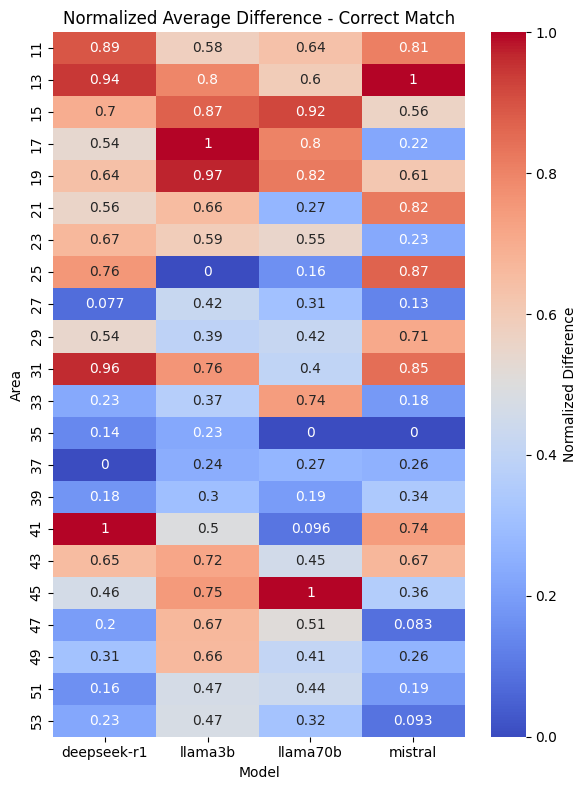

In [475]:
area_change = df.groupby(["iteration","area", "model", "prompt"])["correct_match"].mean().reset_index()
area_change = area_change.pivot_table(index=["area", "model"], columns=["prompt"], values="correct_match").reset_index()
area_change["difference"] = (area_change["persona"] - area_change["benchmark"])
area_change["normalized_difference"] = area_change.groupby("model")["difference"].transform(
    lambda x: (x - x.min()) / (x.max() - x.min()) if (x.max() - x.min()) != 0 else 0)

plt.figure(figsize=(8, 6))
# sns.barplot(data=area_change, x="area", y="normalized_difference", hue="model")
# Pivot the data so that rows are area, columns are model, and values are normalized_difference
heatmap_data = area_change.pivot(index="area", columns="model", values="normalized_difference")

plt.figure(figsize=(6, 8))
sns.heatmap(heatmap_data, annot=True, cmap="coolwarm", cbar_kws={'label': 'Normalized Difference'})
plt.title("Normalized Average Difference - Correct Match")
plt.xlabel("Model")
plt.ylabel("Area")
plt.tight_layout()
plt.show()

C:\Users\godfr\AppData\Local\Temp\ipykernel_24228\3508774769.py:46: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Leave space for colorbar


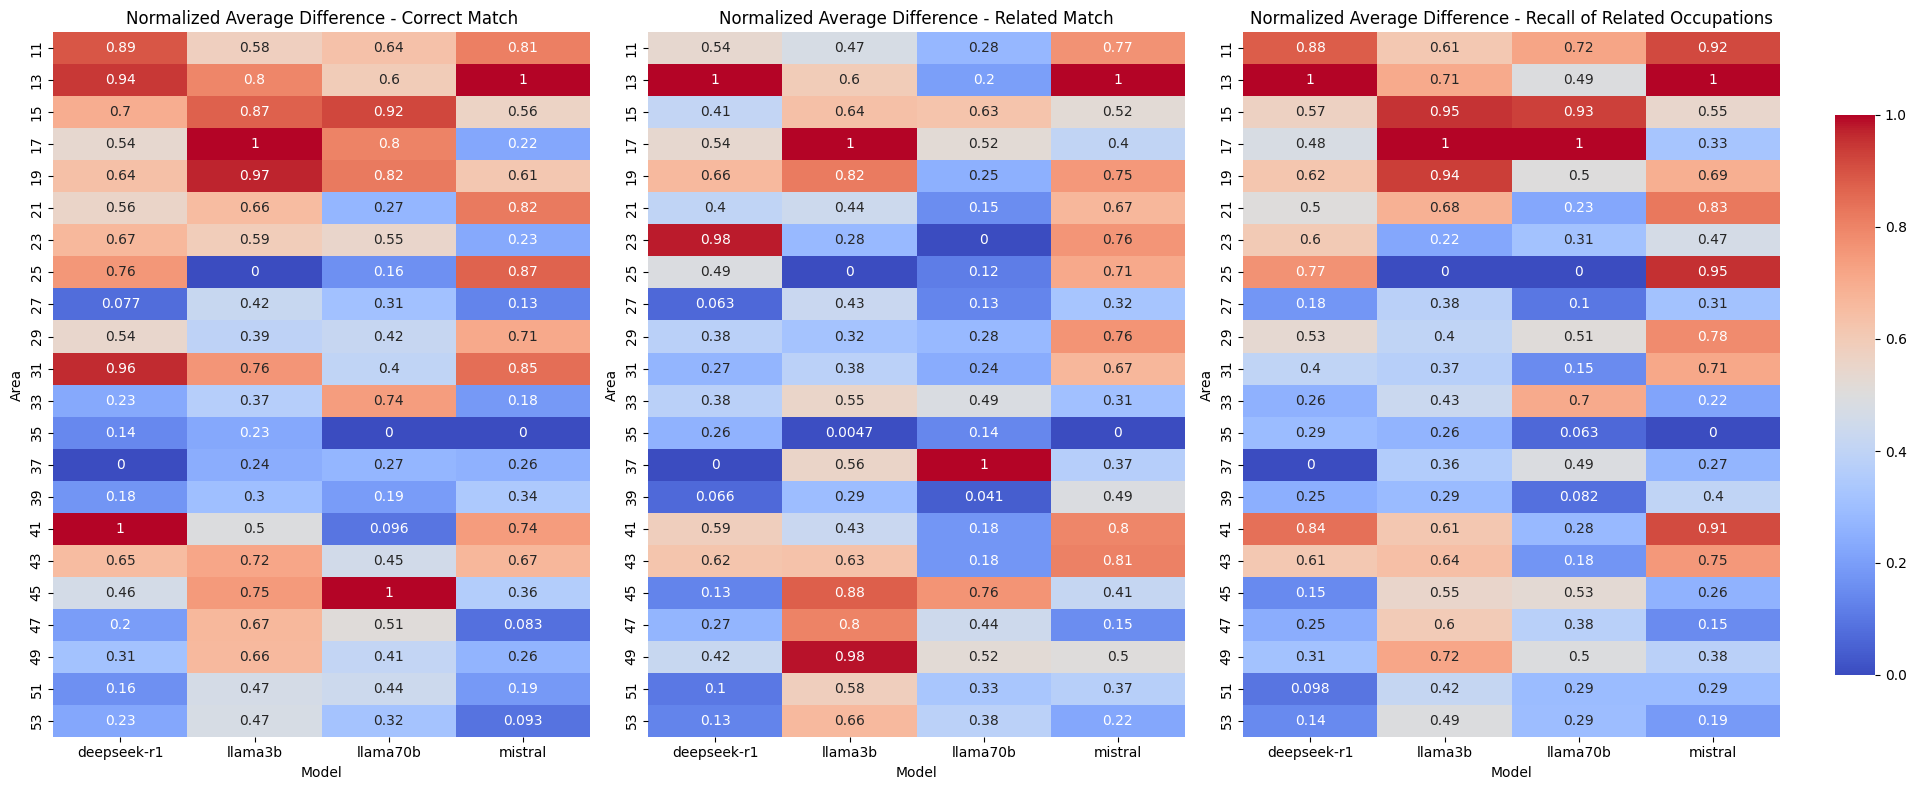

In [501]:
import matplotlib.pyplot as plt
import seaborn as sns

metrics = ['correct_match', 'related_match', 'related_recall']
titles = [
    "Normalized Average Difference - Correct Match",
    "Normalized Average Difference - Related Match",
    "Normalized Average Difference - Recall of Related Occupations"
]

fig, axes = plt.subplots(1, 3, figsize=(20, 8), sharex=True)

# Create a colorbar axis on the right
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]

vmin, vmax = None, None  # Set to None for auto, or use fixed values for consistent color scaling

for i, (metric, title) in enumerate(zip(metrics, titles)):
    area_change = df.groupby(["iteration", "area", "model", "prompt"])[metric].mean().reset_index()
    area_change = area_change.pivot_table(index=["area", "model"], columns=["prompt"], values=metric).reset_index()
    area_change["difference"] = area_change["persona"] - area_change["benchmark"]
    area_change["normalized_difference"] = area_change.groupby("model")["difference"].transform(
        lambda x: (x - x.min()) / (x.max() - x.min()) if (x.max() - x.min()) != 0 else 0
    )
    heatmap_data = area_change.pivot(index="area", columns="model", values="normalized_difference")

    # For consistent color scaling across all plots, calculate vmin/vmax on first loop
    if vmin is None or vmax is None:
        vmin = heatmap_data.min().min()
        vmax = heatmap_data.max().max()

    sns.heatmap(
        heatmap_data,
        annot=True,
        cmap="coolwarm",
        ax=axes[i],
        cbar=(i == 0),  # Only add colorbar on the first plot, but we'll move it later
        cbar_ax=cbar_ax if i == 0 else None,
        vmin=vmin,
        vmax=vmax
    )
    axes[i].set_title(title)
    axes[i].set_xlabel("Model")
    axes[i].set_ylabel("Area")

plt.tight_layout(rect=[0, 0, 0.9, 1])  # Leave space for colorbar
plt.show()

C:\Users\godfr\AppData\Local\Temp\ipykernel_24228\1422397432.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_zone_new = df.groupby(["iteration","zone", "model", "prompt"])["correct_match"].mean().reset_index()


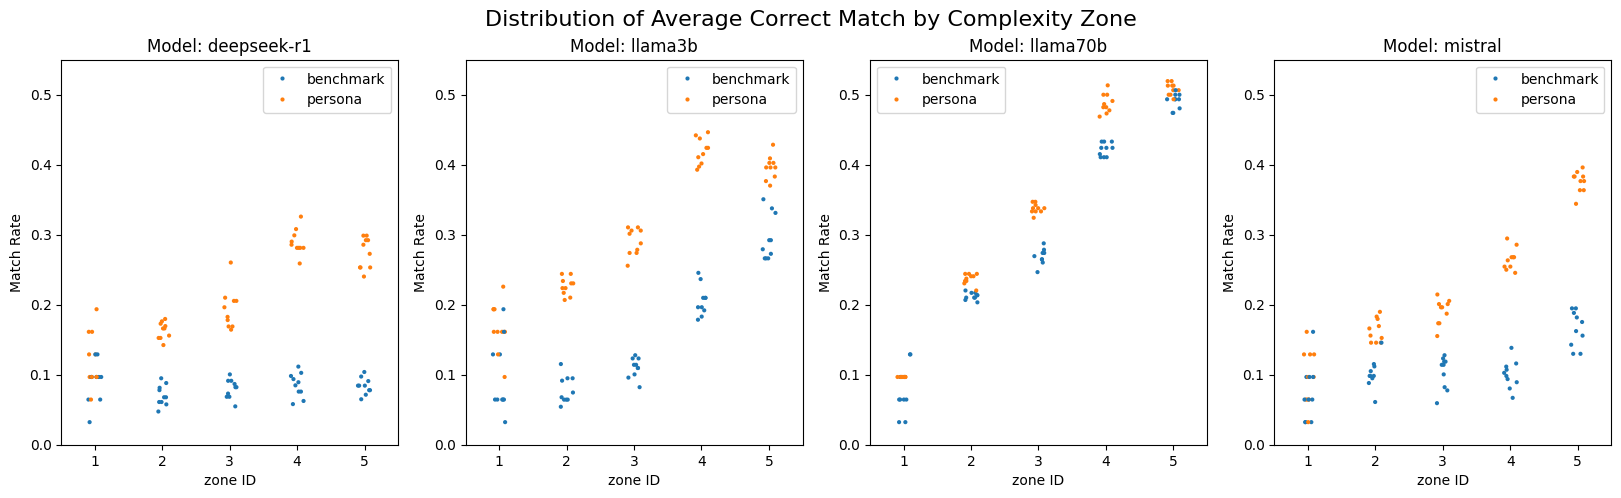

In [56]:
df_zone_new = df.groupby(["iteration","zone", "model", "prompt"])["correct_match"].mean().reset_index()

models = ["deepseek-r1", "llama3b", "llama70b", "mistral"]

plt.figure(figsize=(20, 5))
plt.suptitle("Distribution of Average Correct Match by Complexity Zone", fontsize=16)

for i, model in enumerate(models, 1):
    plt.subplot(1, 4, i)
    df_model = df_zone_new[df_zone_new['model'] == model].copy()

    df_diff = df_model.groupby('zone')[['correct_match']].mean()
    df_diff_sorted = df_diff.sort_values(by='correct_match', ascending=False).index
    sns.stripplot(data=df_model, x="zone", y="correct_match", hue="prompt", dodge=False, 
              size=3, alpha=1, jitter=True)
    plt.title(f'Model: {model}')
    plt.xlabel('zone ID')
    plt.ylabel('Match Rate')
    plt.xticks()#rotation=45, ha='right', fontsize=8)  # Adjust fontsize if needed
    plt.ylim(0, 0.55)  # Set y-axis limit to [0, 1] for correct match rate
# Add the legend to the entire figure outside the loop
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles[:], labels[:])#, loc='upper right', bbox_to_anchor=(0.98, 0.98))
plt.show()

C:\Users\godfr\AppData\Local\Temp\ipykernel_24228\3003704244.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_zone_new = df.groupby(["iteration","zone", "model", "prompt"])["related_match"].mean().reset_index()


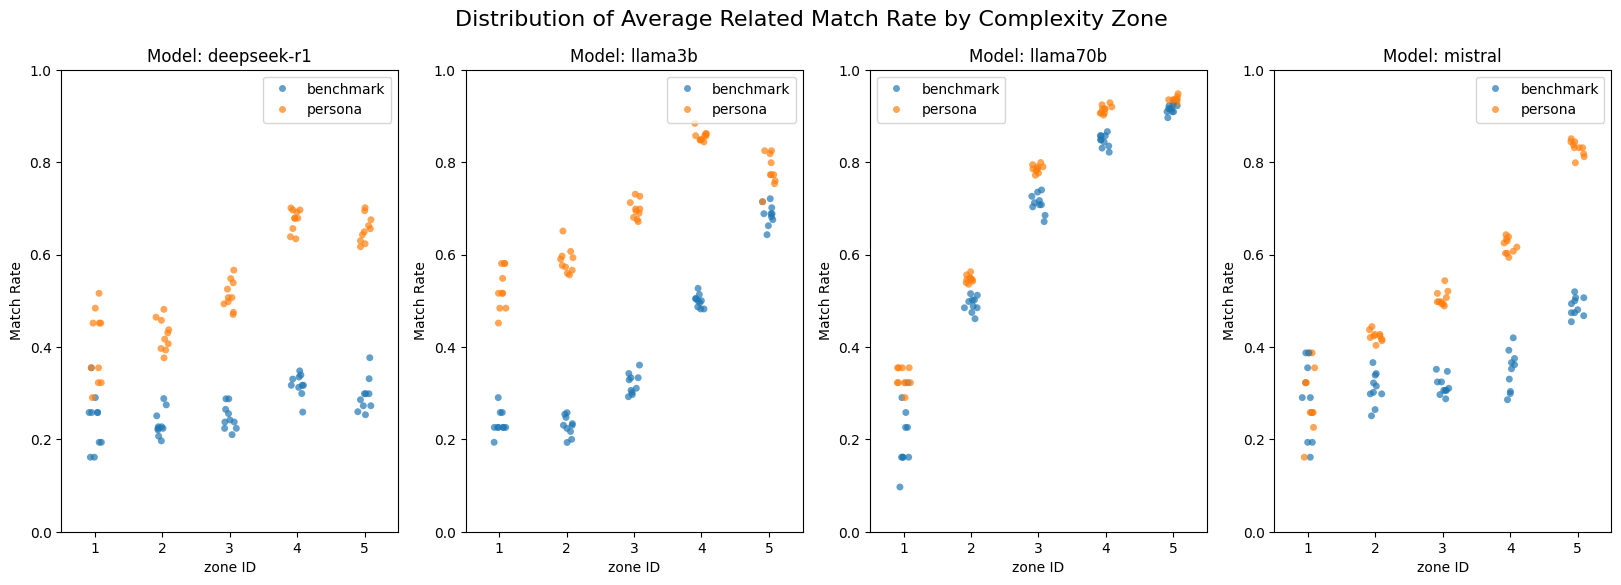

In [57]:
df_zone_new = df.groupby(["iteration","zone", "model", "prompt"])["related_match"].mean().reset_index()

models = ["deepseek-r1", "llama3b", "llama70b", "mistral"]

plt.figure(figsize=(20, 6))
plt.suptitle("Distribution of Average Related Match Rate by Complexity Zone", fontsize=16)

for i, model in enumerate(models, 1):
    plt.subplot(1, 4, i)
    df_model = df_zone_new[df_zone_new['model'] == model].copy()

    df_diff = df_model.groupby('zone')[['related_match']].mean()
    df_diff_sorted = df_diff.sort_values(by='related_match', ascending=False).index
    sns.stripplot(data=df_model, x="zone", y="related_match", hue="prompt", dodge=False, 
              size=5, alpha=0.7, jitter=True)
    plt.title(f'Model: {model}')
    plt.xlabel('zone ID')
    plt.ylabel('Match Rate')
    plt.xticks()#rotation=45, ha='right', fontsize=8)  # Adjust fontsize if needed
    plt.ylim(0, 1)  # Set y-axis limit to [0, 1] for correct match rate
# Add the legend to the entire figure outside the loop
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles[:], labels[:])#, loc='upper right', bbox_to_anchor=(0.98, 0.98))
plt.show()

C:\Users\godfr\AppData\Local\Temp\ipykernel_24228\934167155.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_zone_new = df.groupby(["iteration","zone", "model", "prompt"])["related_recall"].mean().reset_index()


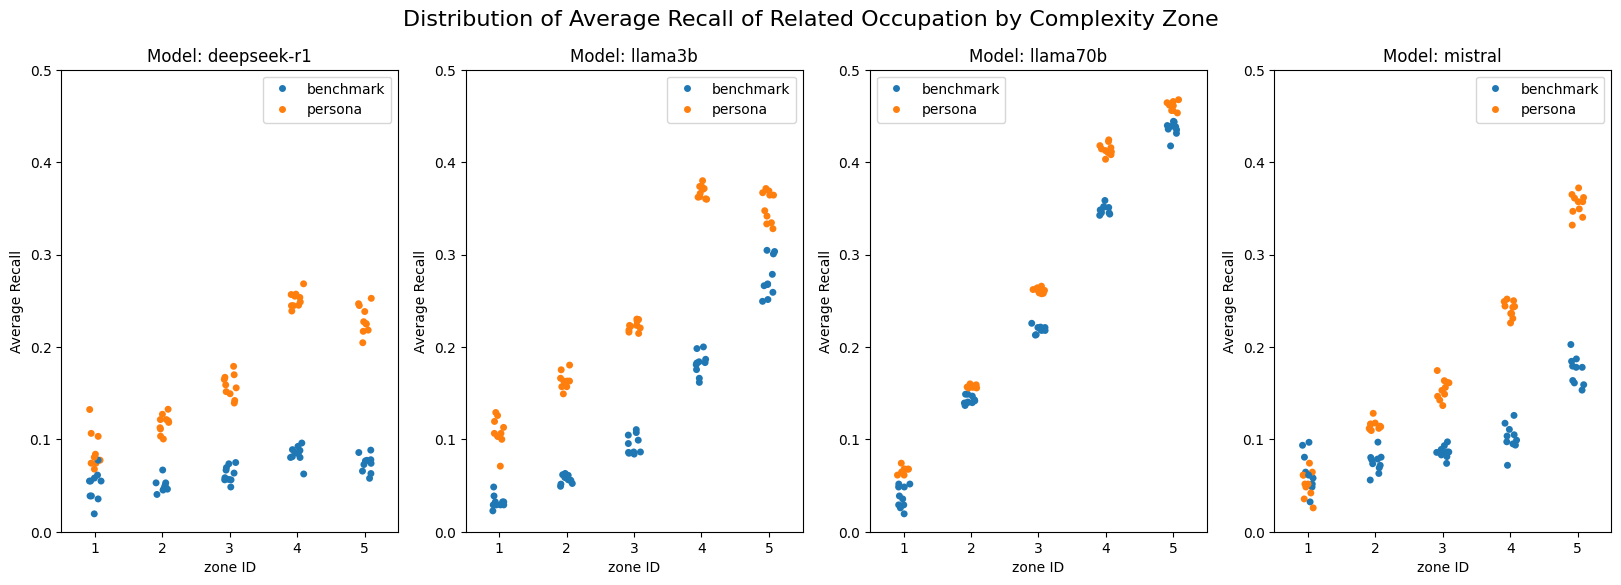

In [58]:
df_zone_new = df.groupby(["iteration","zone", "model", "prompt"])["related_recall"].mean().reset_index()

models = ["deepseek-r1", "llama3b", "llama70b", "mistral"]

plt.figure(figsize=(20, 6))
plt.suptitle("Distribution of Average Recall of Related Occupation by Complexity Zone", fontsize=16)

for i, model in enumerate(models, 1):
    plt.subplot(1, 4, i)
    df_model = df_zone_new[df_zone_new['model'] == model].copy()

    df_diff = df_model.groupby('zone')[['related_recall']].mean()
    df_diff_sorted = df_diff.sort_values(by='related_recall', ascending=False).index
    sns.stripplot(data=df_model, x="zone", y="related_recall", hue="prompt", dodge=False, 
              size=5, alpha=1, jitter=True)
    plt.title(f'Model: {model}')
    plt.xlabel('zone ID')
    plt.ylabel('Average Recall')
    plt.xticks()#rotation=45, ha='right', fontsize=8)  # Adjust fontsize if needed
    plt.ylim(0, .5)  # Set y-axis limit to [0, 1] for correct match rate
# Add the legend to the entire figure outside the loop
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles[:], labels[:])#, loc='upper right', bbox_to_anchor=(0.98, 0.98))
plt.show()

C:\Users\godfr\AppData\Local\Temp\ipykernel_24228\3906643036.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  zone_change = df.groupby(["iteration","zone", "model", "prompt"])["correct_match"].mean().reset_index()
C:\Users\godfr\AppData\Local\Temp\ipykernel_24228\3906643036.py:2: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  zone_change = zone_change.pivot_table(index=["zone", "model"], columns=["prompt"], values="correct_match").reset_index()
C:\Users\godfr\AppData\Local\Temp\ipykernel_24228\3906643036.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass obs

<Figure size 800x600 with 0 Axes>

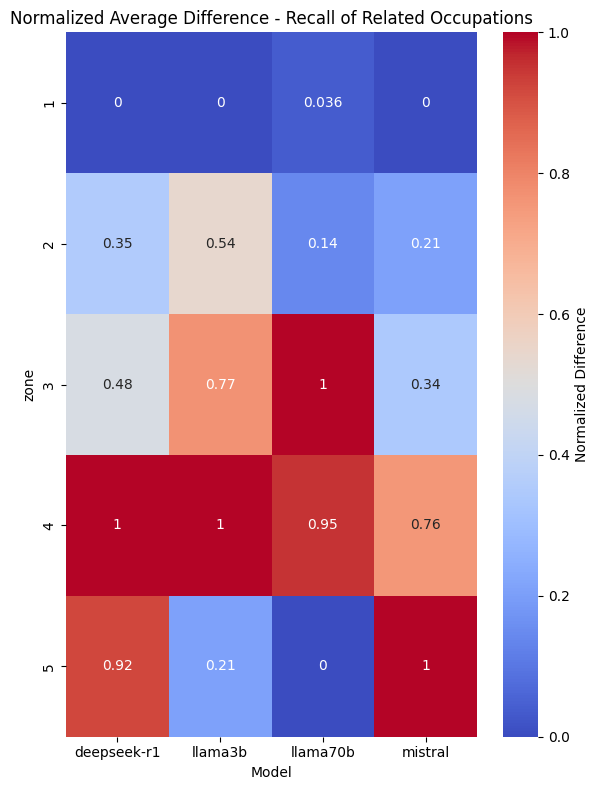

In [59]:
zone_change = df.groupby(["iteration","zone", "model", "prompt"])["correct_match"].mean().reset_index()
zone_change = zone_change.pivot_table(index=["zone", "model"], columns=["prompt"], values="correct_match").reset_index()
zone_change["difference"] = (zone_change["persona"] - zone_change["benchmark"])
zone_change["normalized_difference"] = zone_change.groupby("model")["difference"].transform(
    lambda x: (x - x.min()) / (x.max() - x.min()) if (x.max() - x.min()) != 0 else 0)

plt.figure(figsize=(8, 6))
# sns.barplot(data=zone_change, x="zone", y="normalized_difference", hue="model")
# Pivot the data so that rows are zone, columns are model, and values are normalized_difference
heatmap_data = zone_change.pivot(index="zone", columns="model", values="normalized_difference")

plt.figure(figsize=(6, 8))
sns.heatmap(heatmap_data, annot=True, cmap="coolwarm", cbar_kws={'label': 'Normalized Difference'})
plt.title("Normalized Average Difference - Recall of Related Occupations")
plt.xlabel("Model")
plt.ylabel("zone")
plt.tight_layout()
plt.show()

In [60]:
models = ["deepseek-r1", "llama3b", "llama70b", "mistral"]

for model in models:
    # Filter the dataframe for the current model
    model_data = df_pivot[df_pivot['model'] == model].copy()
    model_data = model_data.groupby(["title", "model", "area", "zone"]).mean().reset_index().drop(columns=["iteration"])
    model_data['difference'] = model_data['persona'] - model_data['benchmark']

    # Perform the Wilcoxon signed-rank test on the differences
    statistic, p_value = stats.wilcoxon(model_data['persona'], model_data["benchmark"], alternative='greater')
    # Print the results

    print(f"Model: {model}")
    print("Wilcoxon Signed-Rank Test Results:")
    print(f"  W-statistic: {statistic:.4f}")
    print(f"  p-value: {p_value:.4f}")

    # Interpretation of the p-value
    alpha = 0.01  # significance level
    if p_value < alpha:
        print(f"\nThe p-value ({p_value:.4f}) is less than the significance level ({alpha}).")
        print("This suggests that there is a statistically significant difference in the similarity scores")
        print("between the benchmark and persona conditions across all occupations and iterations.")
        print("We reject the null hypothesis that there is no difference.")
    else:
        print(f"\nThe p-value ({p_value:.4f}) is greater than or equal to the significance level ({alpha}).")
        print("This suggests that there is no statistically significant difference in the similarity scores")
        print("between the benchmark and persona conditions across all occupations and iterations.")
        print("We fail to reject the null hypothesis.")
    print("\n" + "-" * 50 + "\n")


C:\Users\godfr\AppData\Local\Temp\ipykernel_24228\2619694769.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  model_data = model_data.groupby(["title", "model", "area", "zone"]).mean().reset_index().drop(columns=["iteration"])
C:\Users\godfr\AppData\Local\Temp\ipykernel_24228\2619694769.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  model_data = model_data.groupby(["title", "model", "area", "zone"]).mean().reset_index().drop(columns=["iteration"])
C:\Users\godfr\AppData\Local\Temp\ipykernel_24228\2619694769.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in

Model: deepseek-r1
Wilcoxon Signed-Rank Test Results:
  W-statistic: nan
  p-value: nan

The p-value (nan) is greater than or equal to the significance level (0.01).
This suggests that there is no statistically significant difference in the similarity scores
between the benchmark and persona conditions across all occupations and iterations.
We fail to reject the null hypothesis.

--------------------------------------------------

Model: llama3b
Wilcoxon Signed-Rank Test Results:
  W-statistic: nan
  p-value: nan

The p-value (nan) is greater than or equal to the significance level (0.01).
This suggests that there is no statistically significant difference in the similarity scores
between the benchmark and persona conditions across all occupations and iterations.
We fail to reject the null hypothesis.

--------------------------------------------------

Model: llama70b
Wilcoxon Signed-Rank Test Results:
  W-statistic: nan
  p-value: nan

The p-value (nan) is greater than or equal to th

Simple non parametric t-test (wilcoxon test) shows the average match rate of persona prompt differs from the benchmark and is statistically significant.

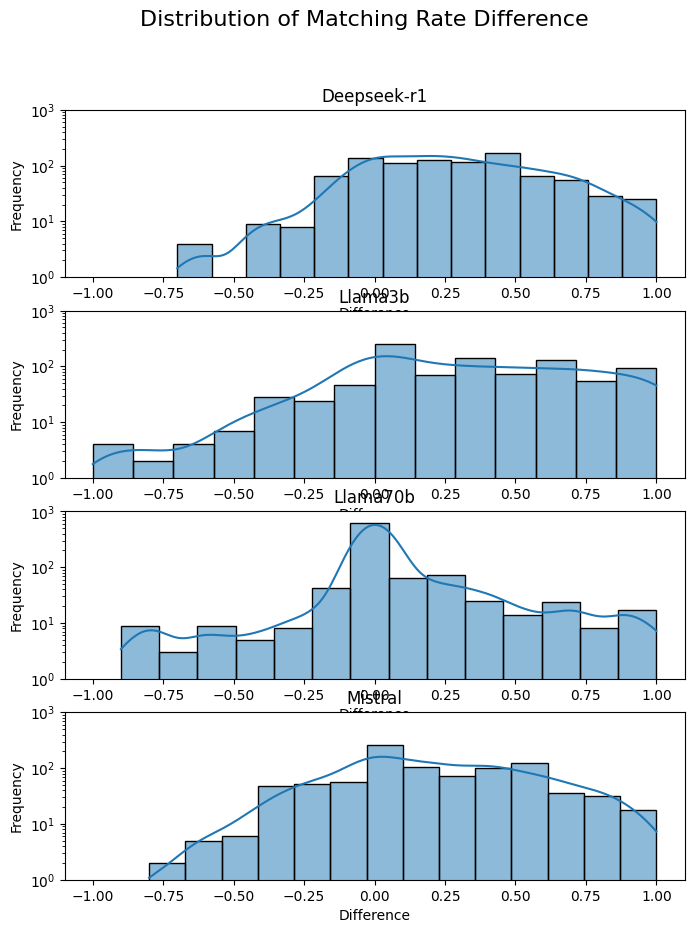

In [61]:
models = ["deepseek-r1", "llama3b", "llama70b", "mistral"]

plt.figure(figsize=(8, 10))
plt.suptitle("Distribution of Matching Rate Difference", fontsize=16)
for i, model in enumerate(models, 1):
    plt.subplot(4, 1, i)
    data_subset = df_related_hit_pivot[(df_related_hit_pivot["model"] == model)]
    data_subset = data_subset.groupby('title')['difference'].mean().reset_index()
    sns.histplot(data=data_subset, x="difference", bins=14, kde=True)
    plt.title(f"{model.capitalize()}")
    plt.ylim(1, 1000)  # Set the same y-axis limit
    plt.xlim(-1.1, 1.1)  # Set the same x-axis limit
    plt.xlabel("Difference")
    plt.yscale('log')
    plt.ylabel("Frequency")

In [62]:
df_change = df_pivot.groupby(["title", "model"])["difference"].mean().reset_index()
df_change

C:\Users\godfr\AppData\Local\Temp\ipykernel_24228\2395551621.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_change = df_pivot.groupby(["title", "model"])["difference"].mean().reset_index()


title        model  difference
0               Accountants and Auditors  deepseek-r1         0.0
1               Accountants and Auditors      llama3b         0.0
2               Accountants and Auditors     llama70b         0.0
3               Accountants and Auditors      mistral         0.0
4                                 Actors  deepseek-r1         0.0
...                                  ...          ...         ...
3687                 Writers and Authors      mistral         0.0
3688  Zoologists and Wildlife Biologists  deepseek-r1         0.0
3689  Zoologists and Wildlife Biologists      llama3b         0.0
3690  Zoologists and Wildlife Biologists     llama70b         0.0
3691  Zoologists and Wildlife Biologists      mistral         0.0

[3692 rows x 3 columns]

<Axes: xlabel='difference', ylabel='Count'>

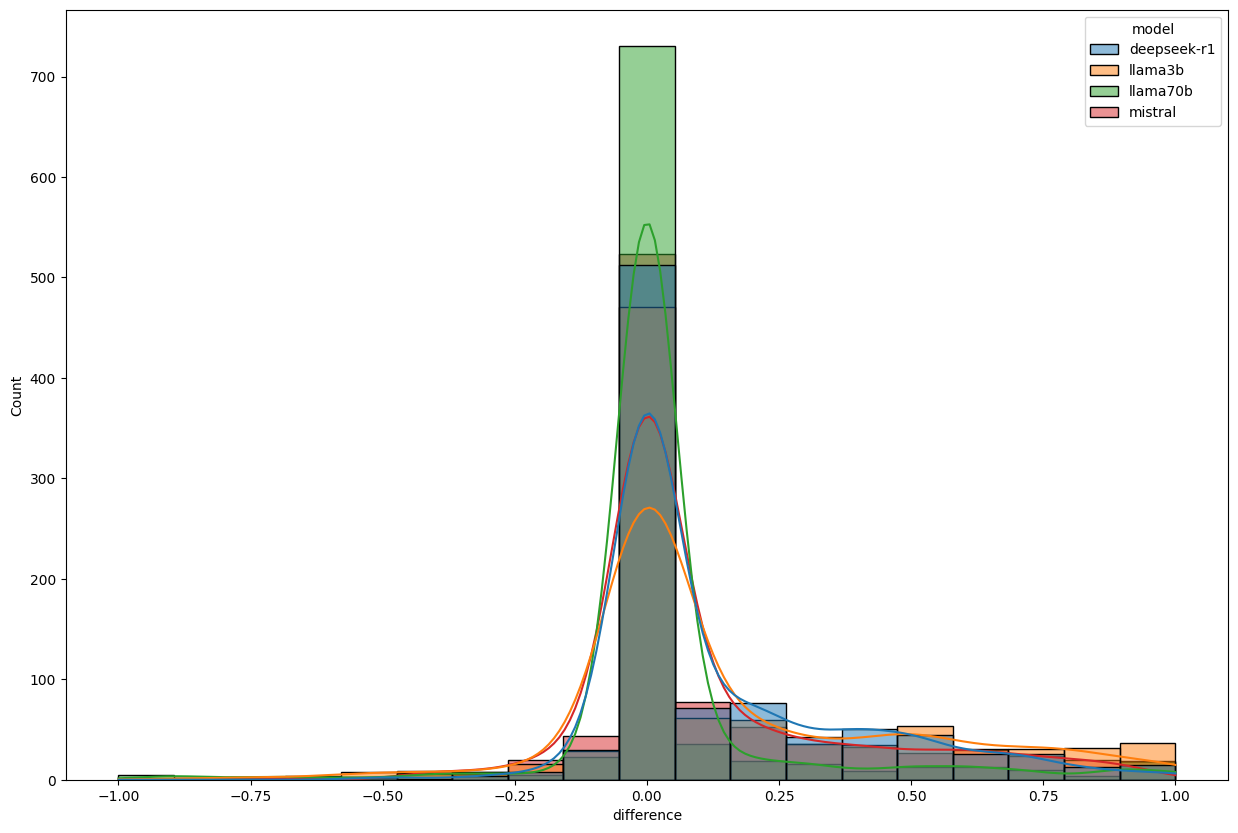

In [63]:
plt.figure(figsize=(15, 10))
sns.histplot(data=df_change, x="difference", bins=19, kde=True, hue="model", alpha=0.5)

# plt.yscale('log')

looking at the change in matching rate for eaach jobs, most jobs didnt get a boost (0 match rate). more jobs gets a boost of matching rate, although some jobs perform poorer using persona than benchmark.

In [64]:
#get a df to show the average correct match rate by model and prompt
avg_hits = df_avg.groupby(["model", "prompt"])["correct_match"].mean().reset_index()
avg_hits = avg_hits.pivot(index="model", columns="prompt", values="correct_match").reset_index()
avg_hits.columns.name = None  # Remove the name of the columns
avg_hits = avg_hits.rename(columns={"benchmark": "average_benchmark", "persona": "average_persona"})
avg_hits["difference"] = avg_hits["average_persona"] - avg_hits["average_benchmark"]
avg_hits["percentage_difference"] = (avg_hits["difference"] / avg_hits["average_benchmark"]) * 100
avg_hits = avg_hits.sort_values(by="percentage_difference", ascending=False)
avg_hits

C:\Users\godfr\AppData\Local\Temp\ipykernel_24228\264900425.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_hits = df_avg.groupby(["model", "prompt"])["correct_match"].mean().reset_index()


model  average_benchmark  average_persona  difference  \
0  deepseek-r1           0.079198         0.218310    0.139112   
1      llama3b           0.153738         0.314735    0.160997   
3      mistral           0.111593         0.227736    0.116143   
2     llama70b           0.318635         0.362189    0.043554   

   percentage_difference  
0             175.649795  
1             104.721635  
3             104.077670  
2              13.668820

deepseek receives the largest boost. notably after the use of persona, llama 3b perform comparably to 70b model.

## correct match by industry and zone

In [65]:
df_pivot

prompt                               title area zone        model  iteration  \
0                 Accountants and Auditors   13    4  deepseek-r1          0   
1                 Accountants and Auditors   13    4  deepseek-r1          1   
2                 Accountants and Auditors   13    4  deepseek-r1          2   
3                 Accountants and Auditors   13    4  deepseek-r1          3   
4                 Accountants and Auditors   13    4  deepseek-r1          4   
...                                    ...  ...  ...          ...        ...   
36915   Zoologists and Wildlife Biologists   19    4      mistral          5   
36916   Zoologists and Wildlife Biologists   19    4      mistral          6   
36917   Zoologists and Wildlife Biologists   19    4      mistral          7   
36918   Zoologists and Wildlife Biologists   19    4      mistral          8   
36919   Zoologists and Wildlife Biologists   19    4      mistral          9   

prompt  benchmark  persona  difference  
0             0.0      0.0         0.0  
1             0.0      0.0         0.0  
2             0.0      0.0         0.0  
3             0.0      0.0         0.0  
4             0.0      0.0         0.0  
...           ...      ...         ...  
36915         0.0      0.0         0.0  
36916         0.0      0.0         0.0  
36917         0.0      0.0         0.0  
36918         0.0      0.0         0.0  
36919         0.0      0.0         0.0  

[36920 rows x 8 columns]

In [66]:
df_area = df_related_hit_pivot[["model", "iteration", "area", "persona", "benchmark"]]
df_area = df_area.groupby(["model", "iteration", "area"]).mean().reset_index()
df_area

C:\Users\godfr\AppData\Local\Temp\ipykernel_24228\4206446916.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_area = df_area.groupby(["model", "iteration", "area"]).mean().reset_index()


prompt        model  iteration area   persona  benchmark
0       deepseek-r1          0   11  0.696429   0.482143
1       deepseek-r1          0   13  0.854167   0.250000
2       deepseek-r1          0   15  0.583333   0.305556
3       deepseek-r1          0   17  0.357143   0.107143
4       deepseek-r1          0   19  0.600000   0.250000
..              ...        ...  ...       ...        ...
875         mistral          9   45  0.500000   0.500000
876         mistral          9   47  0.213115   0.327869
877         mistral          9   49  0.400000   0.300000
878         mistral          9   51  0.308411   0.140187
879         mistral          9   53  0.288462   0.192308

[880 rows x 5 columns]

C:\Users\godfr\AppData\Local\Temp\ipykernel_24228\1154622555.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_area = df_area.groupby(["model", "iteration", "area"]).mean().reset_index()


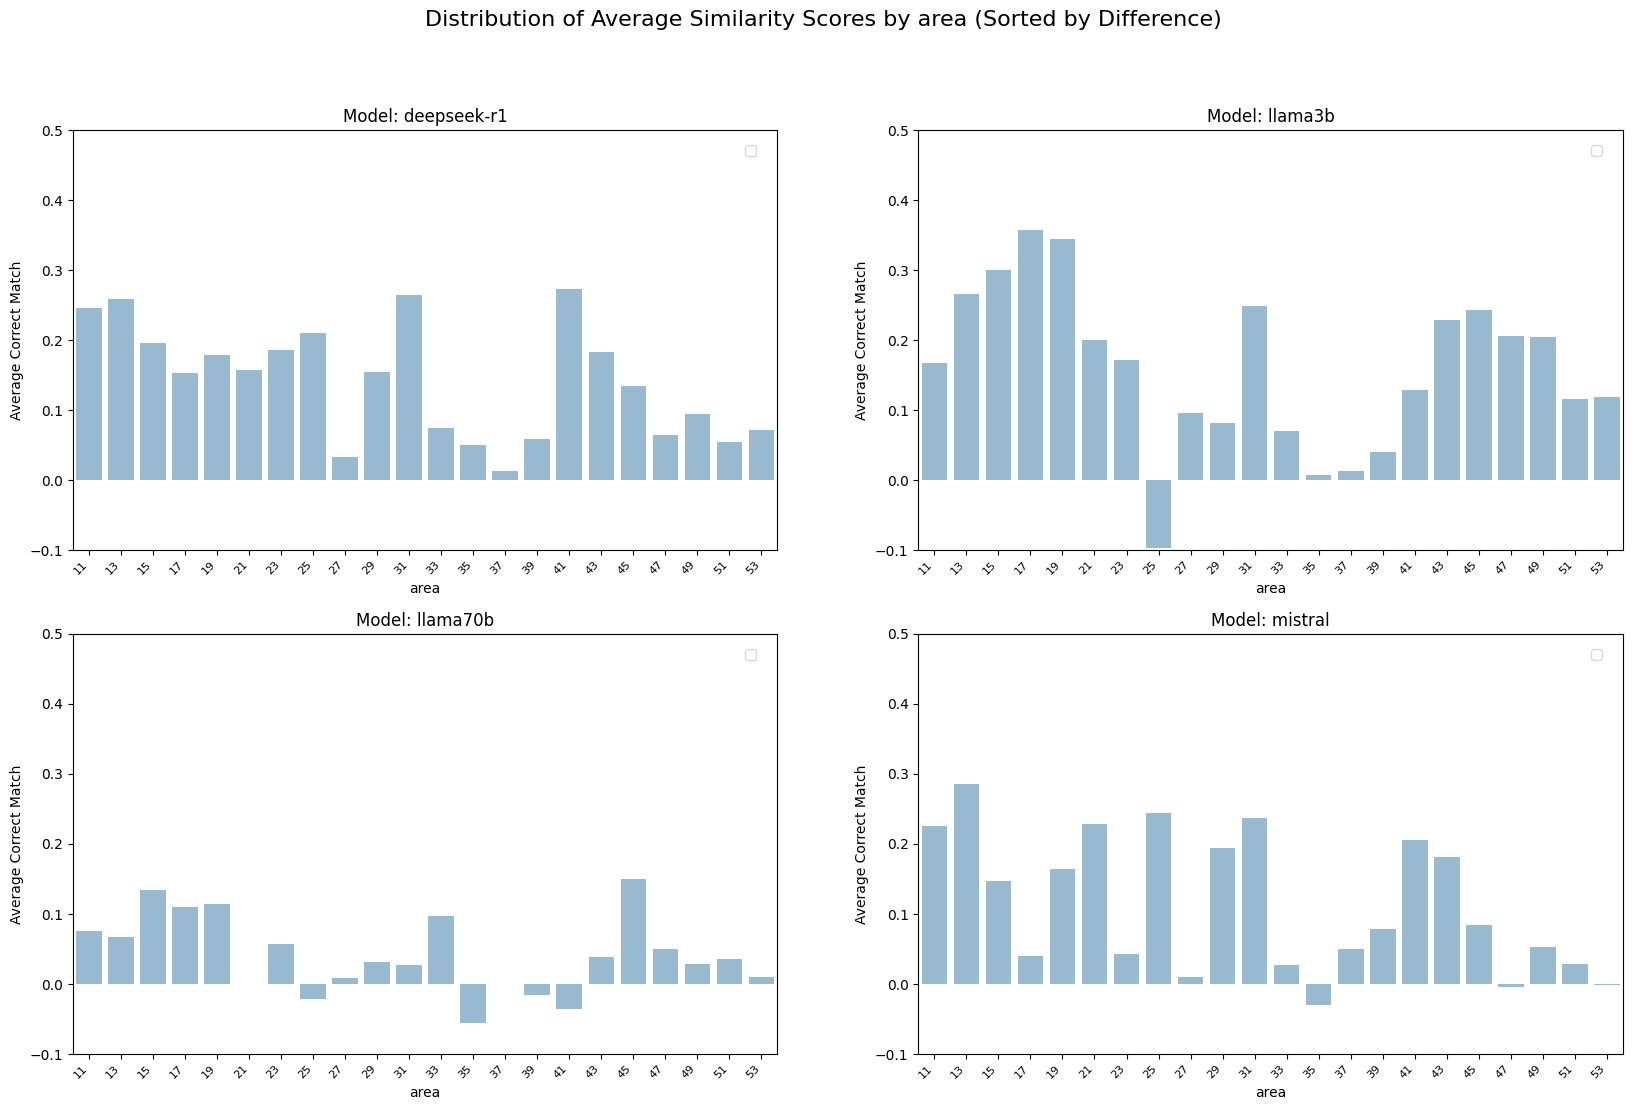

In [67]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

models = ["deepseek-r1", "llama3b", "llama70b", "mistral"]
# df_pivot
# df_recall_pivot
df_area = df_pivot[["model", "iteration", "area", "persona", "benchmark"]]
df_area = df_area.groupby(["model", "iteration", "area"]).mean().reset_index()

plt.figure(figsize=(20, 12))
plt.suptitle("Distribution of Average Similarity Scores by area (Sorted by Difference)", fontsize=16)

for i, model in enumerate(models, 1):
    plt.subplot(2, 2, i)
    df_model = df_area[df_area['model'] == model].copy()

    # Calculate the difference for sorting industries
    df_diff = df_model.groupby('area')[['benchmark', 'persona']].mean()
    # df_diff['average'] = (df_diff['persona'] + df_diff['benchmark']) / 2
    df_diff['average'] = df_diff['persona'] - df_diff['benchmark']
    df_diff_sorted = df_diff.sort_values(by='average', ascending=False).index

    # # Use the sorted order for the stripplot
    # sns.stripplot(x='area', y='benchmark', label='benchmark', data=df_model, dodge=False, alpha=0.5, order=df_diff_sorted, jitter=True)
    # sns.stripplot(x='area', y='persona', label='persona', data=df_model, dodge=False, alpha=0.5, order=df_diff_sorted, jitter=True)
    sns.barplot(data=df_diff, x="area", y="average", alpha=0.5)
  
    # # Melt the dataframe to long format for side-by-side bars
    # df_long = df_model.melt(id_vars=['area'], value_vars=['benchmark', 'persona'],
    #                         var_name='prompt', value_name='score')
    # sns.barplot(data=df_long, x="area", y="score", hue="prompt", order=df_diff_sorted, dodge=True)
    

    plt.title(f'Model: {model}')
    plt.xlabel('area')
    plt.ylabel('Average Correct Match')
    plt.ylim(-0.1, 0.5)  # Set the same y-axis limit
    plt.xticks(rotation=45, ha='right', fontsize=8)  # Adjust fontsize if needed
# Add the legend to the entire figure outside the loop
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles[21:23], labels[21:23], loc='upper right', bbox_to_anchor=(0.98, 0.98))


plt.show()

In [70]:
model = ["deepseek-r1"]
df_ind = df_avg[df_avg["model"] == model[0]].copy()
df_ind = df_ind.pivot_table(index=["area"], columns=["prompt"], values="correct_match").mul(100).reset_index()
df_ind["difference"] = df_ind["persona"] - df_ind["benchmark"]
df_ind = df_ind.sort_values(by="difference", ascending=False)
# find out average matching rate for each column
df_ind["benchmark"] = df_ind["benchmark"].apply(lambda x: "{:.2f}%".format(x))
df_ind["persona"] = df_ind["persona"].apply(lambda x: "{:.2f}%".format(x))
df_ind["difference"] = df_ind["difference"].apply(lambda x: "{:.2f}%".format(x))
df_ind

C:\Users\godfr\AppData\Local\Temp\ipykernel_24228\3234694685.py:3: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  df_ind = df_ind.pivot_table(index=["area"], columns=["prompt"], values="correct_match").mul(100).reset_index()


prompt area benchmark persona difference
15       41    18.18%  45.45%     27.27%
10       31    23.68%  50.00%     26.32%
1        13     6.46%  32.29%     25.83%
0        11    18.21%  42.68%     24.46%
7        25    12.90%  33.87%     20.97%
2        15     6.67%  26.11%     19.44%
6        23     2.86%  21.43%     18.57%
16       43     8.04%  26.27%     18.24%
4        19     4.67%  22.50%     17.83%
5        21    21.43%  37.14%     15.71%
9        29     8.54%  23.93%     15.39%
3        17     1.07%  16.25%     15.18%
17       45     2.50%  15.83%     13.33%
19       49     1.80%  11.20%      9.40%
11       33     4.23%  11.54%      7.31%
21       53     2.88%  10.00%      7.12%
18       47     4.26%  10.66%      6.39%
14       39    16.77%  22.58%      5.81%
20       51     2.52%   7.94%      5.42%
12       35    10.62%  15.62%      5.00%
8        27    16.00%  19.25%      3.25%
13       37     2.50%   3.75%      1.25%

In [74]:
df_mistral = df[df["model"] == "mistral"].copy()
df_mistral_reg = df_mistral[["title", "area", "prompt", "related_recall", "zone"]]
df_mistral_reg

title area     prompt  \
55380                                  Chief Executives   11  benchmark   
55381                     Chief Sustainability Officers   11  benchmark   
55382                   General and Operations Managers   11  benchmark   
55383                                       Legislators   11  benchmark   
55384               Advertising and Promotions Managers   11  benchmark   
...                                                 ...  ...        ...   
73835  Gas Compressor and Gas Pumping Station Operators   53    persona   
73836           Pump Operators, Except Wellhead Pumpers   53    persona   
73837                                  Wellhead Pumpers   53    persona   
73838         Refuse and Recyclable Material Collectors   53    persona   
73839                 Tank Car, Truck, and Ship Loaders   53    persona   

       related_recall zone  
55380             0.4    5  
55381             0.0    5  
55382             0.5    4  
55383             0.0    4  
55384             0.8    4  
...               ...  ...  
73835             0.2    2  
73836             0.0    2  
73837             0.0    2  
73838             0.0    2  
73839             0.0    2  

[18460 rows x 5 columns]

In [75]:
zone_industry_counts = pd.crosstab(df_mistral['area'], df_mistral['zone']).div(10)
zone_industry_counts = zone_industry_counts.astype(int)
zone_industry_counts["sum"] = zone_industry_counts.sum(axis=1)
zone_industry_counts = zone_industry_counts.sort_values(by="sum", ascending=False)
zone_industry_counts

zone   1    2   3   4    5  sum
area                           
51    14  162  38   0    0  214
29     0    0  56  18  104  178
25     0    0  14  26   84  124
47    16   84  22   0    0  122
19     0    0  22  40   58  120
11     0    6  14  78   14  112
17     0    2  28  74    8  112
53     2   78  20   4    0  104
43     0   72  26   4    0  102
49     0   38  62   0    0  100
13     0    2  14  78    2   96
27     0   10  26  42    2   80
15     0    0  12  48   12   72
39     2   36  22   2    0   62
33     0   24  24   4    0   52
41     2   20   6  16    0   44
31     0   18  20   0    0   38
35    10   18   4   0    0   32
21     0    0   0  14   14   28
45    12   10   2   0    0   24
37     4    8   4   0    0   16
23     0    2   2   0   10   14

not a signle industry contains jobs from all 5 zones. so some industry effect might be misinterpreted. thats why 2 regressions will be run, one with prompt x industry, andother is prompt x zone

for prompt x industry, 47 will be used a baseline because benchmark and persona difference is small, closer to average benchmark matching rate, and more frequent in the dataset.

C(prompt)[T.persona]                      -0.0605      0.201     -0.301      0.763      -0.454       0.333 \
persona effect in 47 is small and insignificant, which is expected.

In [76]:
model = ["deepseek-r1"]
df_zone = df_avg[df_avg["model"] == model[0]].copy()
df_zone = df_zone.pivot_table(index=["zone"], columns=["prompt"], values="correct_match").mul(100).reset_index()
df_zone["difference"] = df_zone["persona"] - df_zone["benchmark"]
df_zone = df_zone.sort_values(by="difference", ascending=False)
# find out average matching rate for each column
df_zone["benchmark"] = df_zone["benchmark"].apply(lambda x: "{:.2f}%".format(x))
df_zone["persona"] = df_zone["persona"].apply(lambda x: "{:.2f}%".format(x))
df_zone["difference"] = df_zone["difference"].apply(lambda x: "{:.2f}%".format(x))
df_zone

C:\Users\godfr\AppData\Local\Temp\ipykernel_24228\452902434.py:3: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  df_zone = df_zone.pivot_table(index=["zone"], columns=["prompt"], values="correct_match").mul(100).reset_index()


prompt zone benchmark persona difference
3         4     8.53%  28.93%     20.40%
4         5     8.38%  27.40%     19.03%
2         3     7.99%  19.41%     11.42%
1         2     7.05%  16.34%      9.29%
0         1     9.03%  12.26%      3.23%

In [77]:
#find out the count of each zone
zone_counts = df_mistral["zone"].value_counts().div(20)
zone_counts = zone_counts.astype(int).reset_index()
zone_counts

zone  count
0    2    295
1    4    224
2    3    219
3    5    154
4    1     31

C(prompt)[T.persona] shows with persona, it helps increase the log odds by 0.5453 and its significant. \
\
except zone 5, all other zone perform similarly without benchmark. log odds is small and insignificant. \
\
but after persona, zone 4 C(prompt)[T.persona]:C(zone)[T.4] and zone 5 benefit a lot from persona since log odds are high and significant.

The 'persona' prompt has a statistically significant positive effect on the likelihood of a correct match in the reference zone ('2').\
\
The 'persona' prompt also has a significantly more positive effect in Zone '4' and Zone '5' compared to the reference zone. This suggests that the 'persona' prompt is particularly beneficial in these zones.\
\
The effect of the 'persona' prompt in Zone '1' and Zone '3' is not significantly different from its effect in the reference zone.\
\
The baseline matching rates (with the 'benchmark' prompt) differ across zones, with Zone '5' having a significantly higher rate than the reference zone.\
\
more complex job is benefited by persona prompt more.

### Recall

C:\Users\godfr\AppData\Local\Temp\ipykernel_24228\895621516.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_hits = df.groupby(["model", "prompt"])["related_recall"].mean().reset_index()


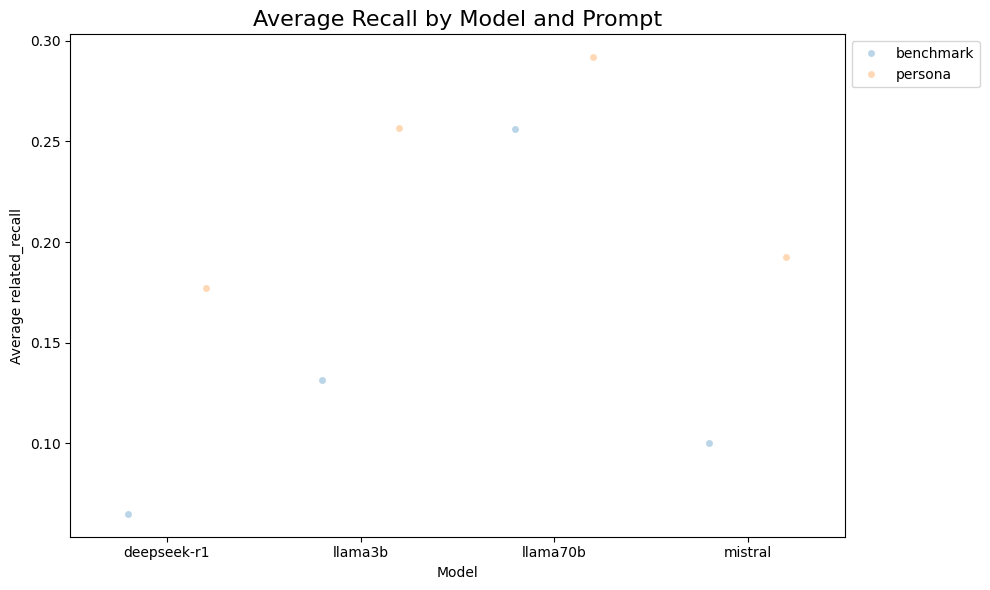

In [78]:
# Calculate the average related_recall for each model and prompt
avg_hits = df.groupby(["model", "prompt"])["related_recall"].mean().reset_index()

# Create a single barplot
plt.figure(figsize=(10, 6))
# sns.violinplot(data=df_avg, x="model", y="related_recall", hue="prompt", bw_adjust=3)
sns.stripplot(data=avg_hits, x="model", y="related_recall", hue="prompt", dodge=True, 
              size=5, alpha=0.3, jitter=True)

# Add labels and title
plt.title("Average Recall by Model and Prompt", fontsize=16)
plt.xlabel("Model")
plt.ylabel("Average related_recall")
 # Ensure some padding on the y-axis, no box around the legend
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')

# Show the plot
plt.tight_layout()
plt.show()

In [79]:

# 2. Melt the DataFrame to long format for correct_match and related_match
df_both = df.drop(columns=['related_recall'])
df_both = df_both.melt(
    id_vars=[col for col in df_both.columns if col not in ['correct_match', 'related_match']],
    value_vars=['correct_match', 'related_match'],
    var_name='task',
    value_name='match'
).reset_index(drop=True)

df_both

title  iteration  \
0                                       Chief Executives          0   
1                          Chief Sustainability Officers          0   
2                        General and Operations Managers          0   
3                                            Legislators          0   
4                    Advertising and Promotions Managers          0   
...                                                  ...        ...   
147675  Gas Compressor and Gas Pumping Station Operators          9   
147676           Pump Operators, Except Wellhead Pumpers          9   
147677                                  Wellhead Pumpers          9   
147678         Refuse and Recyclable Material Collectors          9   
147679                 Tank Car, Truck, and Ship Loaders          9   

              model     prompt        code zone area           task  match  
0       deepseek-r1  benchmark  11-1011.00    5   11  correct_match      1  
1       deepseek-r1  benchmark  11-1011.03    5   11  correct_match      1  
2       deepseek-r1  benchmark  11-1021.00    4   11  correct_match      0  
3       deepseek-r1  benchmark  11-1031.00    4   11  correct_match      0  
4       deepseek-r1  benchmark  11-2011.00    4   11  correct_match      0  
...             ...        ...         ...  ...  ...            ...    ...  
147675      mistral    persona  53-7071.00    2   53  related_match      1  
147676      mistral    persona  53-7072.00    2   53  related_match      0  
147677      mistral    persona  53-7073.00    2   53  related_match      0  
147678      mistral    persona  53-7081.00    2   53  related_match      0  
147679      mistral    persona  53-7121.00    2   53  related_match      0  

[147680 rows x 9 columns]

## to find out reference group for each regression that is closest to average

In [80]:
df_check = df_avg.copy()
df_check = df_check.groupby(["model", "prompt"])["correct_match"].mean().reset_index()
df_check = df_check.pivot(index=["model"], columns=["prompt"], values="correct_match").reset_index()
df_check["difference"] = df_check["persona"] - df_check["benchmark"]
df_check

C:\Users\godfr\AppData\Local\Temp\ipykernel_24228\1525979803.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_check = df_check.groupby(["model", "prompt"])["correct_match"].mean().reset_index()


prompt        model  benchmark   persona  difference
0       deepseek-r1   0.079198  0.218310    0.139112
1           llama3b   0.153738  0.314735    0.160997
2          llama70b   0.318635  0.362189    0.043554
3           mistral   0.111593  0.227736    0.116143

In [83]:
df_ind_check = df_avg.copy()
df_ind_check = df_ind_check.groupby(["model", "prompt", "area"])["correct_match"].mean().reset_index()
df_ind_check = df_ind_check.pivot(index=["model", "area"], columns=["prompt"], values="correct_match").reset_index()
df_ind_check["difference"] = df_ind_check["persona"] - df_ind_check["benchmark"]
df_ind_check

C:\Users\godfr\AppData\Local\Temp\ipykernel_24228\447499586.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_ind_check = df_ind_check.groupby(["model", "prompt", "area"])["correct_match"].mean().reset_index()


prompt        model area  benchmark   persona  difference
0       deepseek-r1   11   0.182143  0.426786    0.244643
1       deepseek-r1   13   0.064583  0.322917    0.258333
2       deepseek-r1   15   0.066667  0.261111    0.194444
3       deepseek-r1   17   0.010714  0.162500    0.151786
4       deepseek-r1   19   0.046667  0.225000    0.178333
..              ...  ...        ...       ...         ...
83          mistral   45   0.083333  0.166667    0.083333
84          mistral   47   0.091803  0.086885   -0.004918
85          mistral   49   0.064000  0.116000    0.052000
86          mistral   51   0.038318  0.066355    0.028037
87          mistral   53   0.063462  0.061538   -0.001923

[88 rows x 5 columns]

In [84]:
df_zone_check = df_avg.copy()
df_zone_check = df_zone_check.groupby(["model", "prompt", "zone"])["correct_match"].mean().reset_index()
df_zone_check = df_zone_check.pivot(index=["model", "zone"], columns=["prompt"], values="correct_match").reset_index()
df_zone_check["difference"] = df_zone_check["persona"] - df_zone_check["benchmark"]
df_zone_check

C:\Users\godfr\AppData\Local\Temp\ipykernel_24228\2379991703.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_zone_check = df_zone_check.groupby(["model", "prompt", "zone"])["correct_match"].mean().reset_index()


prompt        model zone  benchmark   persona  difference
0       deepseek-r1    1   0.090323  0.122581    0.032258
1       deepseek-r1    2   0.070508  0.163390    0.092881
2       deepseek-r1    3   0.079909  0.194064    0.114155
3       deepseek-r1    4   0.085268  0.289286    0.204018
4       deepseek-r1    5   0.083766  0.274026    0.190260
5           llama3b    1   0.096774  0.167742    0.070968
6           llama3b    2   0.078644  0.226441    0.147797
7           llama3b    3   0.110046  0.290411    0.180365
8           llama3b    4   0.205804  0.419196    0.213393
9           llama3b    5   0.295455  0.396104    0.100649
10         llama70b    1   0.077419  0.096774    0.019355
11         llama70b    2   0.212203  0.236949    0.024746
12         llama70b    3   0.269406  0.337443    0.068037
13         llama70b    4   0.421875  0.487500    0.065625
14         llama70b    5   0.490909  0.508442    0.017532
15          mistral    1   0.074194  0.096774    0.022581
16          mistral    2   0.101695  0.163390    0.061695
17          mistral    3   0.103653  0.190411    0.086758
18          mistral    4   0.100446  0.265179    0.164732
19          mistral    5   0.165584  0.375974    0.210390

In [85]:
# For each model, find the row in df_ind_check closest to df_check (smallest sum of abs differences)
closest_rows = []

for _, row in df_check.iterrows():
    model = row['model']
    # Filter df_ind_check for the current model
    df_model = df_ind_check[df_ind_check['model'] == model].copy()
    # Calculate the sum of absolute differences for benchmark and persona
    df_model['diff_sum'] = (
        (df_model['benchmark'] - row['benchmark']).abs() +
        (df_model['persona'] - row['persona']).abs()
    )
    # Get the row with the smallest difference
    closest_row = df_model.loc[df_model['diff_sum'].idxmin()]
    closest_rows.append(closest_row)

# Combine results into a DataFrame
closest_df = pd.DataFrame(closest_rows)
closest_df

prompt        model area  benchmark   persona  difference  diff_sum
9       deepseek-r1   29   0.085393  0.239326    0.153933  0.027211
38          llama3b   43   0.133333  0.360784    0.227451  0.066454
60         llama70b   43   0.368627  0.405882    0.037255  0.093686
80          mistral   39   0.132258  0.209677    0.077419  0.038724

In [86]:
# For each model, find the row in df_zone_check closest to df_check (smallest sum of abs differences)
closest_rows = []

for _, row in df_check.iterrows():
    model = row['model']
    # Filter df_zone_check for the current model
    df_model = df_zone_check[df_zone_check['model'] == model].copy()
    # Calculate the sum of absolute differences for benchmark and persona
    df_model['diff_sum'] = (
        (df_model['benchmark'] - row['benchmark']).abs() +
        (df_model['persona'] - row['persona']).abs()
    )
    # Get the row with the smallest difference
    closest_row = df_model.loc[df_model['diff_sum'].idxmin()]
    closest_rows.append(closest_row)

# Combine results into a DataFrame
closest_df = pd.DataFrame(closest_rows)
closest_df

prompt        model zone  benchmark   persona  difference  diff_sum
2       deepseek-r1    3   0.079909  0.194064    0.114155  0.024956
7           llama3b    3   0.110046  0.290411    0.180365  0.068016
12         llama70b    3   0.269406  0.337443    0.068037  0.073974
17          mistral    3   0.103653  0.190411    0.086758  0.045264

Related Match

In [88]:
#get average performance
df_check = df_avg.copy()
df_check = df_check.groupby(["model", "prompt"])["related_match"].mean().reset_index()
df_check = df_check.pivot(index=["model"], columns=["prompt"], values="related_match").reset_index()
df_check["difference"] = df_check["persona"] - df_check["benchmark"]

#get average performance by area
df_ind_check = df_avg.copy()
df_ind_check = df_ind_check.groupby(["model", "prompt", "area"])["related_match"].mean().reset_index()
df_ind_check = df_ind_check.pivot(index=["model", "area"], columns=["prompt"], values="related_match").reset_index()
df_ind_check["difference"] = df_ind_check["persona"] - df_ind_check["benchmark"]

#get average performance by zone
df_zone_check = df_avg.copy()
df_zone_check = df_zone_check.groupby(["model", "prompt", "zone"])["correct_match"].mean().reset_index()
df_zone_check = df_zone_check.pivot(index=["model", "zone"], columns=["prompt"], values="correct_match").reset_index()
df_zone_check["difference"] = df_zone_check["persona"] - df_zone_check["benchmark"]

C:\Users\godfr\AppData\Local\Temp\ipykernel_24228\1439830375.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_check = df_check.groupby(["model", "prompt"])["related_match"].mean().reset_index()
C:\Users\godfr\AppData\Local\Temp\ipykernel_24228\1439830375.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_ind_check = df_ind_check.groupby(["model", "prompt", "area"])["related_match"].mean().reset_index()
C:\Users\godfr\AppData\Local\Temp\ipykernel_24228\1439830375.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=

In [89]:
df_check

prompt        model  benchmark   persona  difference
0       deepseek-r1   0.267606  0.544420    0.276815
1           llama3b   0.392849  0.708992    0.316143
2          llama70b   0.690791  0.750271    0.059480
3           mistral   0.349512  0.553954    0.204442

In [90]:
df_zone_check

prompt        model zone  benchmark   persona  difference
0       deepseek-r1    1   0.090323  0.122581    0.032258
1       deepseek-r1    2   0.070508  0.163390    0.092881
2       deepseek-r1    3   0.079909  0.194064    0.114155
3       deepseek-r1    4   0.085268  0.289286    0.204018
4       deepseek-r1    5   0.083766  0.274026    0.190260
5           llama3b    1   0.096774  0.167742    0.070968
6           llama3b    2   0.078644  0.226441    0.147797
7           llama3b    3   0.110046  0.290411    0.180365
8           llama3b    4   0.205804  0.419196    0.213393
9           llama3b    5   0.295455  0.396104    0.100649
10         llama70b    1   0.077419  0.096774    0.019355
11         llama70b    2   0.212203  0.236949    0.024746
12         llama70b    3   0.269406  0.337443    0.068037
13         llama70b    4   0.421875  0.487500    0.065625
14         llama70b    5   0.490909  0.508442    0.017532
15          mistral    1   0.074194  0.096774    0.022581
16          mistral    2   0.101695  0.163390    0.061695
17          mistral    3   0.103653  0.190411    0.086758
18          mistral    4   0.100446  0.265179    0.164732
19          mistral    5   0.165584  0.375974    0.210390

In [91]:
# For each model, find the row in df_ind_check closest to df_check (smallest sum of abs differences)
closest_rows = []

for _, row in df_check.iterrows():
    model = row['model']
    # Filter df_ind_check for the current model
    df_model = df_ind_check[df_ind_check['model'] == model].copy()
    # Calculate the sum of absolute differences for benchmark and persona
    df_model['diff_sum'] = (
        (df_model['benchmark'] - row['benchmark']).abs() +
        (df_model['persona'] - row['persona']).abs()
    )
    # Get the row with the smallest difference
    closest_row = df_model.loc[df_model['diff_sum'].idxmin()]
    closest_rows.append(closest_row)

# Combine results into a DataFrame
closest_df = pd.DataFrame(closest_rows)
closest_df

prompt        model area  benchmark   persona  difference  diff_sum
11      deepseek-r1   33   0.238462  0.507692    0.269231  0.065872
30          llama3b   27   0.452500  0.665000    0.212500  0.103643
52         llama70b   27   0.742500  0.735000   -0.007500  0.066980
80          mistral   39   0.429032  0.596774    0.167742  0.122339

In [92]:
# For each model, find the row in df_zone_check closest to df_check (smallest sum of abs differences)
closest_rows = []

for _, row in df_check.iterrows():
    model = row['model']
    # Filter df_zone_check for the current model
    df_model = df_zone_check[df_zone_check['model'] == model].copy()
    # Calculate the sum of absolute differences for benchmark and persona
    df_model['diff_sum'] = (
        (df_model['benchmark'] - row['benchmark']).abs() +
        (df_model['persona'] - row['persona']).abs()
    )
    # Get the row with the smallest difference
    closest_row = df_model.loc[df_model['diff_sum'].idxmin()]
    closest_rows.append(closest_row)

# Combine results into a DataFrame
closest_df = pd.DataFrame(closest_rows)
closest_df

prompt        model zone  benchmark   persona  difference  diff_sum
3       deepseek-r1    4   0.085268  0.289286    0.204018  0.437472
9           llama3b    5   0.295455  0.396104    0.100649  0.410283
14         llama70b    5   0.490909  0.508442    0.017532  0.441711
19          mistral    5   0.165584  0.375974    0.210390  0.361909

related recall

In [94]:
#get average performance
df_check = df_avg.copy()
df_check = df_check.groupby(["model", "prompt"])["related_recall"].mean().reset_index()
df_check = df_check.pivot(index=["model"], columns=["prompt"], values="related_recall").reset_index()
df_check["difference"] = df_check["persona"] - df_check["benchmark"]

#get average performance by area
df_ind_check = df_avg.copy()
df_ind_check = df_ind_check.groupby(["model", "prompt", "area"])["related_recall"].mean().reset_index()
df_ind_check = df_ind_check.pivot(index=["model", "area"], columns=["prompt"], values="related_recall").reset_index()
df_ind_check["difference"] = df_ind_check["persona"] - df_ind_check["benchmark"]

#get average performance by zone
df_zone_check = df_avg.copy()
df_zone_check = df_zone_check.groupby(["model", "prompt", "zone"])["correct_match"].mean().reset_index()
df_zone_check = df_zone_check.pivot(index=["model", "zone"], columns=["prompt"], values="correct_match").reset_index()
df_zone_check["difference"] = df_zone_check["persona"] - df_zone_check["benchmark"]

C:\Users\godfr\AppData\Local\Temp\ipykernel_24228\4177352662.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_check = df_check.groupby(["model", "prompt"])["related_recall"].mean().reset_index()
C:\Users\godfr\AppData\Local\Temp\ipykernel_24228\4177352662.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_ind_check = df_ind_check.groupby(["model", "prompt", "area"])["related_recall"].mean().reset_index()
C:\Users\godfr\AppData\Local\Temp\ipykernel_24228\4177352662.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observe

In [95]:
df_check

prompt        model  benchmark   persona  difference
0       deepseek-r1   0.065038  0.177053    0.112015
1           llama3b   0.131528  0.256739    0.125211
2          llama70b   0.256078  0.291831    0.035753
3           mistral   0.100412  0.192752    0.092340

In [96]:
df_zone_check

prompt        model zone  benchmark   persona  difference
0       deepseek-r1    1   0.090323  0.122581    0.032258
1       deepseek-r1    2   0.070508  0.163390    0.092881
2       deepseek-r1    3   0.079909  0.194064    0.114155
3       deepseek-r1    4   0.085268  0.289286    0.204018
4       deepseek-r1    5   0.083766  0.274026    0.190260
5           llama3b    1   0.096774  0.167742    0.070968
6           llama3b    2   0.078644  0.226441    0.147797
7           llama3b    3   0.110046  0.290411    0.180365
8           llama3b    4   0.205804  0.419196    0.213393
9           llama3b    5   0.295455  0.396104    0.100649
10         llama70b    1   0.077419  0.096774    0.019355
11         llama70b    2   0.212203  0.236949    0.024746
12         llama70b    3   0.269406  0.337443    0.068037
13         llama70b    4   0.421875  0.487500    0.065625
14         llama70b    5   0.490909  0.508442    0.017532
15          mistral    1   0.074194  0.096774    0.022581
16          mistral    2   0.101695  0.163390    0.061695
17          mistral    3   0.103653  0.190411    0.086758
18          mistral    4   0.100446  0.265179    0.164732
19          mistral    5   0.165584  0.375974    0.210390

In [97]:
# For each model, find the row in df_ind_check closest to df_check (smallest sum of abs differences)
closest_rows = []

for _, row in df_check.iterrows():
    model = row['model']
    # Filter df_ind_check for the current model
    df_model = df_ind_check[df_ind_check['model'] == model].copy()
    # Calculate the sum of absolute differences for benchmark and persona
    df_model['diff_sum'] = (
        (df_model['benchmark'] - row['benchmark']).abs() +
        (df_model['persona'] - row['persona']).abs()
    )
    # Get the row with the smallest difference
    closest_row = df_model.loc[df_model['diff_sum'].idxmin()]
    closest_rows.append(closest_row)

# Combine results into a DataFrame
closest_df = pd.DataFrame(closest_rows)
closest_df

prompt        model area  benchmark   persona  difference  diff_sum
2       deepseek-r1   15   0.062778  0.201389    0.138611  0.026596
38          llama3b   43   0.130000  0.289412    0.159412  0.034200
47         llama70b   17   0.236607  0.354821    0.118214  0.082461
80          mistral   39   0.104516  0.156774    0.052258  0.040082

In [98]:
# For each model, find the row in df_zone_check closest to df_check (smallest sum of abs differences)
closest_rows = []

for _, row in df_check.iterrows():
    model = row['model']
    # Filter df_zone_check for the current model
    df_model = df_zone_check[df_zone_check['model'] == model].copy()
    # Calculate the sum of absolute differences for benchmark and persona
    df_model['diff_sum'] = (
        (df_model['benchmark'] - row['benchmark']).abs() +
        (df_model['persona'] - row['persona']).abs()
    )
    # Get the row with the smallest difference
    closest_row = df_model.loc[df_model['diff_sum'].idxmin()]
    closest_rows.append(closest_row)

# Combine results into a DataFrame
closest_df = pd.DataFrame(closest_rows)
closest_df

prompt        model zone  benchmark   persona  difference  diff_sum
1       deepseek-r1    2   0.070508  0.163390    0.092881  0.019134
7           llama3b    3   0.110046  0.290411    0.180365  0.055154
12         llama70b    3   0.269406  0.337443    0.068037  0.058940
17          mistral    3   0.103653  0.190411    0.086758  0.005582

In [99]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.genmod import families
from statsmodels.genmod import cov_struct
from statsmodels.genmod.families import links

# --- Data Loading and Initial Preprocessing (from your original code) ---
# IMPORTANT: Replace this sample data with your actual data loading and preprocessing.
# Ensure 'df' DataFrame is structured with 'title', 'prompt', 'code', 'zone', 'industry',
# 'correct_match', and 'related_match' columns.
json_path = r'd:\OneDrive - Universität Mannheim\MMM\Master Thesis\Teapot\results\task1\task1_data.json'
code_path = r"d:\OneDrive - Universität Mannheim\MMM\Master Thesis\Teapot\datasets\occupation.xlsx"
zone_path = r"d:\OneDrive - Universität Mannheim\MMM\Master Thesis\Teapot\datasets\job_zone.xlsx"

try:
    df = pd.read_json(json_path, lines=True)
except FileNotFoundError:
    print(f"Error: File {json_path} not found. Check path.")
    raise

# Filter for model and preprocess
llm = "deepseek-r1"
df['model'] = df['model'].replace('llama3.2', 'llama3b').replace('llama3.3', 'llama70b')
df['prompt'] = df['prompt'].replace('no', 'benchmark').replace('prompt1', 'persona')
df['prompt'] = df['prompt'].astype('category')
df = df[df['model'] == llm].copy() # Ensure you're working on a copy to avoid warnings
df.drop(columns=['all_fit'], inplace=True, errors='ignore') # errors='ignore' if column might not exist
df.rename(columns={'c_all_fit_hits': 'correct_match', 'r_all_fit_hits': 'related_match', 'r_all_fit_recall': 'related_recall'}, inplace=True)

try:
    occupation = pd.read_excel(code_path)
    occupation.drop(columns=['Description'], inplace=True)
    occupation.columns = ['code', 'title']
    zone = pd.read_excel(zone_path)
    zone = zone[['Title', 'Job Zone']]
    zone.columns = ['title', 'zone']
except FileNotFoundError as e:
    print(f"Error: Excel file not found: {e}")
    raise

df = df.merge(occupation, on='title', how='left')
df = df.merge(zone, on='title', how='left')

# Ensure 'code' exists and handle potential NaN after merge for 'industry'
df['industry'] = df['code'].apply(lambda x: x.split('-')[0] if pd.notnull(x) else np.nan).fillna('Unknown')

# Categorical type and order
df['prompt'] = pd.Categorical(df['prompt'], categories=['benchmark', 'persona'], ordered=False)
df['zone'] = df['zone'].astype(str) # Ensure zone is string for categorical
df['zone'] = pd.Categorical(df['zone'])

df['code_id'] = pd.Categorical(df['code']) # Use code as the unique identifier for groups

# Ensure 'industry' is categorical with a reference level
if '43' in df['industry'].unique():
    industry_categories = ['43'] + [cat for cat in df['industry'].unique() if cat != '43']
else:
    # Fallback: use the most frequent industry as reference if '43' isn't suitable
    most_frequent_industry = df['industry'].mode()[0]
    industry_categories = [most_frequent_industry] + [cat for cat in df['industry'].unique() if cat != most_frequent_industry]

df['industry'] = pd.Categorical(df['industry'], categories=industry_categories, ordered=False)

print("DataFrame head after critical preprocessing for GEE (Binary models):")
print(df[['prompt', 'zone', 'industry', 'code_id', 'correct_match', 'related_match']].head())
print(f"Number of unique code_id groups: {df['code_id'].nunique()}")


# --- Helper Function for Running GEE Models (Binary Outcomes) ---
def run_binary_gee_model(dataframe, outcome_var, group_var, model_type_str):
    """
    Runs a GEE model for the specified binary outcome and prints a summary.
    Handles two separate models: one with prompt*industry and one with prompt*zone.
    """
    print(f"\n--- Running GEE Model for: {outcome_var} ({model_type_str}) ---")

    link_instance = links.Logit() # Logit link for binary outcomes

    # Define common GEE parameters
    common_gee_params = {
        'data': dataframe,
        'groups': dataframe[group_var],
        'family': families.Binomial(link=link_instance),
        'cov_struct': cov_struct.Exchangeable()
    }

    # --- Model with prompt * industry interaction ---
    formula_industry = f"{outcome_var} ~ C(prompt, Treatment(reference='benchmark')) * C(industry)"
    print(f"Model 1 Formula: {formula_industry}")
    try:
        model_industry = smf.gee(formula_industry, **common_gee_params)
        results_industry = model_industry.fit()
        print(f"\n--- GEE Results: {outcome_var} ~ prompt * industry ---")
        print(results_industry.summary())
        print("\nExponentiated Coefficients (Odds Ratios):")
        print(np.exp(results_industry.params))
        print("\nP-values:")
        print(results_industry.pvalues)

    except Exception as e:
        print(f"Error fitting model for {outcome_var} (prompt * industry): {e}")

    # --- Model with prompt * zone interaction ---
    formula_zone = f"{outcome_var} ~ C(prompt, Treatment(reference='benchmark')) * C(zone)"
    print(f"\nModel 2 Formula: {formula_zone}")
    try:
        model_zone = smf.gee(formula_zone, **common_gee_params)
        results_zone = model_zone.fit()
        print(f"\n--- GEE Results: {outcome_var} ~ prompt * zone ---")
        print(results_zone.summary())
        print("\nExponentiated Coefficients (Odds Ratios):")
        print(np.exp(results_zone.params))
        print("\nP-values:")
        print(results_zone.pvalues)

    except Exception as e:
        print(f"Error fitting model for {outcome_var} (prompt * zone): {e}")


# --- Running the GEE Models for Binary Outcome Variables ---

# 1. Correct Match (Binary Outcome)
run_binary_gee_model(df,
                     outcome_var='correct_match',
                     group_var='code_id',
                     model_type_str='Binary')

# 2. Related Match (Binary Outcome)
run_binary_gee_model(df,
                     outcome_var='related_match',
                     group_var='code_id',
                     model_type_str='Binary')

DataFrame head after critical preprocessing for GEE (Binary models):
      prompt zone industry     code_id  correct_match  related_match
0  benchmark    5       11  11-1011.00              1              1
1  benchmark    5       11  11-1011.03              1              1
2  benchmark    4       11  11-1021.00              0              0
3  benchmark    4       11  11-1031.00              0              0
4  benchmark    4       11  11-2011.00              0              1
Number of unique code_id groups: 923

--- Running GEE Model for: correct_match (Binary) ---
Model 1 Formula: correct_match ~ C(prompt, Treatment(reference='benchmark')) * C(industry)

--- GEE Results: correct_match ~ prompt * industry ---
                               GEE Regression Results                              
Dep. Variable:               correct_match   No. Observations:                18460
Model:                                 GEE   No. clusters:                      923
Method:                   

In [100]:
# run_recall_gee.py

import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.genmod import families
from statsmodels.genmod import cov_struct
from statsmodels.genmod.families import links

# --- Data Loading and Initial Preprocessing (from your original code) ---
# IMPORTANT: Replace this sample data with your actual data loading and preprocessing.
# Ensure 'df' DataFrame is structured with 'title', 'prompt', 'code', 'zone', 'industry',
# and 'related_recall' columns.
json_path = r'd:\OneDrive - Universität Mannheim\MMM\Master Thesis\Teapot\results\task1\task1_data.json'
code_path = r"d:\OneDrive - Universität Mannheim\MMM\Master Thesis\Teapot\datasets\occupation.xlsx"
zone_path = r"d:\OneDrive - Universität Mannheim\MMM\Master Thesis\Teapot\datasets\job_zone.xlsx"

try:
    df = pd.read_json(json_path, lines=True)
except FileNotFoundError:
    print(f"Error: File {json_path} not found. Check path.")
    raise

# Filter for model and preprocess
llm = "mistral"
df['model'] = df['model'].replace('llama3.2', 'llama3b').replace('llama3.3', 'llama70b')
df['prompt'] = df['prompt'].replace('no', 'benchmark').replace('prompt1', 'persona')
df['prompt'] = df['prompt'].astype('category')
df = df[df['model'] == llm].copy() # Ensure you're working on a copy to avoid warnings
df.drop(columns=['all_fit'], inplace=True, errors='ignore') # errors='ignore' if column might not exist
df.rename(columns={'c_all_fit_hits': 'correct_match', 'r_all_fit_hits': 'related_match', 'r_all_fit_recall': 'related_recall'}, inplace=True)


try:
    occupation = pd.read_excel(code_path)
    occupation.drop(columns=['Description'], inplace=True)
    occupation.columns = ['code', 'title']
    zone = pd.read_excel(zone_path)
    zone = zone[['Title', 'Job Zone']]
    zone.columns = ['title', 'zone']
except FileNotFoundError as e:
    print(f"Error: Excel file not found: {e}")
    raise

df = df.merge(occupation, on='title', how='left')
df = df.merge(zone, on='title', how='left')

# Ensure 'code' exists and handle potential NaN after merge for 'industry'
df['industry'] = df['code'].apply(lambda x: x.split('-')[0] if pd.notnull(x) else np.nan)
df['industry'].fillna('Unknown', inplace=True) # Fill NaN in industry after split if any
df['industry'] = df['industry'].astype(str) # Ensure industry is string type for get_dummies


# Categorical type and order for prompt and zone (unchanged)
df['prompt'] = pd.Categorical(df['prompt'], categories=['benchmark', 'persona'], ordered=False)
df['zone'] = df['zone'].astype(str) # Ensure zone is string for categorical
df['zone'] = pd.Categorical(df['zone'])

df['code_id'] = pd.Categorical(df['code']) # Use code as the unique identifier for groups

# --- Dynamically determine the reference industry ---
# Calculate the overall mean related recall proportion
overall_mean_recall = df['related_recall'].mean()
print(f"Overall Mean Related Recall: {overall_mean_recall:.4f}")

# Calculate mean related recall for each industry
industry_mean_recall = df.groupby('industry')['related_recall'].mean()
print("Mean Related Recall by Industry:")
print(industry_mean_recall.sort_values())

# Find the industry whose mean recall is closest to the overall mean
reference_industry = (industry_mean_recall - overall_mean_recall).abs().idxmin()
print(f"\nSelected Reference Industry (closest to overall mean): {reference_industry}")

# Reorder industry categories to set the chosen reference first
# Ensure all unique industries are included, with the reference at the beginning
all_industries = [reference_industry] + [cat for cat in df['industry'].unique() if cat != reference_industry]
df['industry'] = pd.Categorical(df['industry'], categories=all_industries, ordered=False)

df['zone'] = df['zone'].astype(str)

# --- Dynamically determine the reference ZONE ---
# Calculate mean related recall for each zone
zone_mean_recall = df.groupby('zone')['related_recall'].mean()
print("\nMean Related Recall by Zone:")
print(zone_mean_recall.sort_values())

# Find the zone whose mean recall is closest to the overall mean
reference_zone = (zone_mean_recall - overall_mean_recall).abs().idxmin()
print(f"\nSelected Reference Zone (closest to overall mean): {reference_zone}")

# Reorder zone categories to set the chosen reference first
# Ensure all unique zones are included, with the reference at the beginning
all_zones = [reference_zone] + [cat for cat in df['zone'].unique() if cat != reference_zone]
df['zone'] = pd.Categorical(df['zone'], categories=all_zones, ordered=False)

# --- Transform 'related_recall' into [successes, failures] 2D array ---
df['num_related_matches_count'] = (df['related_recall'] * 10).round().astype(int)
df['num_related_matches_failures'] = 10 - df['num_related_matches_count']


print("DataFrame head after critical preprocessing for GEE (Recall model):")
print(df[['prompt', 'zone', 'industry', 'code_id', 'num_related_matches_count', 'num_related_matches_failures']].head())
print(f"Number of unique code_id groups: {df['code_id'].nunique()}")


def run_recall_gee_model(dataframe, group_var, model_type_str, reference_industry_val, reference_zone_val): # Added reference_zone_val
    """
    Runs a GEE model for the specified proportional/count outcome and prints a summary.
    Handles two separate models: one with prompt*industry and one with prompt*zone.
    reference_industry_val: The dynamically chosen industry category to be used as reference.
    reference_zone_val: The dynamically chosen zone category to be used as reference. # New
    """
    endog_data = dataframe[['num_related_matches_count', 'num_related_matches_failures']].to_numpy()
    print(f"\n--- Running GEE Model for: Related Recall ({model_type_str}) ---")
    link_instance = links.Logit()

    # --- Model with prompt * industry interaction ---
    print(f"Model 1 Formula (derived): Intercept + prompt_persona + industry_dummies + interactions")
    try:
        prompt_dummies = pd.get_dummies(dataframe['prompt'], prefix='prompt', drop_first=True)
        industry_dummies_all = pd.get_dummies(dataframe['industry'], prefix='industry')
        reference_industry_col = 'industry_' + str(reference_industry_val)
        industry_dummies = industry_dummies_all.drop(columns=[reference_industry_col], errors='ignore')

        exog_base_industry = pd.DataFrame({'Intercept': 1}, index=dataframe.index)
        exog_base_industry = pd.concat([exog_base_industry, prompt_dummies, industry_dummies], axis=1)

        if 'prompt_persona' in prompt_dummies.columns:
            for col_industry in industry_dummies.columns:
                interaction_col_name = f"prompt_persona_x_{col_industry}"
                exog_base_industry[interaction_col_name] = prompt_dummies['prompt_persona'] * industry_dummies[col_industry]

        exog_industry = exog_base_industry.astype(float)

        model_industry = sm.GEE(
            endog=endog_data,
            exog=exog_industry,
            groups=dataframe[group_var],
            family=families.Binomial(link=link_instance),
            cov_struct=cov_struct.Exchangeable()
        )
        results_industry = model_industry.fit()
        print(f"\n--- GEE Results: Related Recall ~ prompt * industry (Reference: {reference_industry_val}) ---")
        print(results_industry.summary())
        print("\nExponentiated Coefficients (Odds Ratios):")
        print(np.exp(results_industry.params))
        print("\nP-values:")
        print(results_industry.pvalues)

    except Exception as e:
        print(f"Error fitting model for Related Recall (prompt * industry): {e}")

    # --- Model with prompt * zone interaction ---
    print(f"\nModel 2 Formula (derived): Intercept + prompt_persona + zone_dummies + interactions")
    try:
        # Changed: Use the reference_zone_val passed to the function
        zone_dummies_all = pd.get_dummies(dataframe['zone'], prefix='zone')
        reference_zone_col = 'zone_' + str(reference_zone_val) # Use passed reference
        zone_dummies = zone_dummies_all.drop(columns=[reference_zone_col], errors='ignore')

        exog_base_zone = pd.DataFrame({'Intercept': 1}, index=dataframe.index)
        exog_base_zone = pd.concat([exog_base_zone, prompt_dummies, zone_dummies], axis=1)

        if 'prompt_persona' in prompt_dummies.columns:
            for col_zone in zone_dummies.columns:
                interaction_col_name = f"prompt_persona_x_{col_zone}"
                exog_base_zone[interaction_col_name] = prompt_dummies['prompt_persona'] * zone_dummies[col_zone]

        exog_zone = exog_base_zone.astype(float)

        model_zone = sm.GEE(
            endog=endog_data,
            exog=exog_zone,
            groups=dataframe[group_var],
            family=families.Binomial(link=link_instance),
            cov_struct=cov_struct.Exchangeable()
        )
        results_zone = model_zone.fit()
        print(f"\n--- GEE Results: Related Recall ~ prompt * zone (Reference: {reference_zone_val}) ---") # Changed here too
        print(results_zone.summary())
        print("\nExponentiated Coefficients (Odds Ratios):")
        print(np.exp(results_zone.params))
        print("\nP-values:")
        print(results_zone.pvalues)

    except Exception as e:
        print(f"Error fitting model for Related Recall (prompt * zone): {e}")


# --- Running the GEE Models for Recall Outcome Variable ---
# Pass the dynamically chosen reference_industry AND reference_zone to the helper function
run_recall_gee_model(df,
                     group_var='code_id',
                     model_type_str='Proportional (Binomial GEE)',
                     reference_industry_val=reference_industry,
                     reference_zone_val=reference_zone) # New argument

C:\Users\godfr\AppData\Local\Temp\ipykernel_24228\2025377101.py:50: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['industry'].fillna('Unknown', inplace=True) # Fill NaN in industry after split if any


Overall Mean Related Recall: 0.1466
Mean Related Recall by Industry:
industry
51    0.038411
17    0.044643
53    0.049038
47    0.057869
33    0.058269
45    0.060000
37    0.063125
15    0.075972
49    0.083300
23    0.088571
35    0.099375
27    0.129875
39    0.130645
19    0.155083
13    0.187188
43    0.199412
11    0.215089
41    0.227045
29    0.269270
31    0.306053
25    0.344597
21    0.347500
Name: related_recall, dtype: float64

Selected Reference Industry (closest to overall mean): 19

Mean Related Recall by Zone:
zone
1    0.058226
2    0.094932
3    0.120297
4    0.171518
5    0.264416
Name: related_recall, dtype: float64

Selected Reference Zone (closest to overall mean): 4
DataFrame head after critical preprocessing for GEE (Recall model):
      prompt zone industry     code_id  num_related_matches_count  \
0  benchmark    5       11  11-1011.00                          4   
1  benchmark    5       11  11-1011.03                          0   
2  benchmark    4       1

### final good GEE

In [432]:
or_all = pd.DataFrame()

### 1. Deepseek

In [433]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.genmod import families
from statsmodels.genmod import cov_struct
from statsmodels.genmod.families import links
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Suppress specific warnings for cleaner output
warnings.filterwarnings("ignore", category=UserWarning, module="statsmodels")
warnings.filterwarnings("ignore", category=sm.tools.sm_exceptions.ConvergenceWarning)


# --- Data Loading and Initial Preprocessing ---
json_path = r'd:\OneDrive - Universität Mannheim\MMM\Master Thesis\Teapot\results\task1\task1_data.json'
code_path = r"d:\OneDrive - Universität Mannheim\MMM\Master Thesis\Teapot\datasets\occupation.xlsx"
zone_path = r"d:\OneDrive - Universität Mannheim\MMM\Master Thesis\Teapot\datasets\job_zone.xlsx"

try:
    df = pd.read_json(json_path, lines=True)
except FileNotFoundError:
    print(f"Error: File {json_path} not found. Check path.")
    raise

# Filter for model and preprocess (using a sample LLM for demonstration)
llm = "deepseek-r1"  # Change this to the desired model
df['model'] = df['model'].replace('llama3.2', 'llama3b').replace('llama3.3', 'llama70b')
df['prompt'] = df['prompt'].replace('no', 'benchmark').replace('prompt1', 'persona')
df['prompt'] = df['prompt'].astype('category')
df = df[df['model'] == llm].copy()
df.drop(columns=['all_fit'], inplace=True, errors='ignore')
df.rename(columns={'c_all_fit_hits': 'correct_match', 'r_all_fit_hits': 'related_match', 'r_all_fit_recall': 'related_recall'}, inplace=True)

try:
    occupation = pd.read_excel(code_path)
    occupation.drop(columns=['Description'], inplace=True)
    occupation.columns = ['code', 'title']
    zone = pd.read_excel(zone_path)
    zone = zone[['Title', 'Job Zone']]
    zone.columns = ['title', 'zone']
except FileNotFoundError as e:
    print(f"Error: Excel file not found: {e}")
    raise

df = df.merge(occupation, on='title', how='left')
df = df.merge(zone, on='title', how='left')

df['area'] = df['code'].apply(lambda x: x.split('-')[0] if pd.notnull(x) else np.nan).fillna('Unknown')
df['trials'] = 1

# --- DIAGNOSE PERFECT SEPARATION ---
print("\n--- Diagnosing potential Perfect Separation for related_recall ---")
for p in df['prompt'].unique():
    for i in df['area'].unique():
        subset = df[(df['prompt'] == p) & (df['area'] == i)]
        if not subset.empty and (subset['related_recall'].min() == 0 and subset['related_recall'].max() == 0):
            print(f"Warning: Perfect separation (all 0s) for prompt='{p}', area='{i}' (n={len(subset)})")
        if not subset.empty and (subset['related_recall'].min() == 10 and subset['related_recall'].max() == 10):
            print(f"Warning: Perfect separation (all 10s) for prompt='{p}', area='{i}' (n={len(subset)})")
    for z in df['zone'].unique():
        subset = df[(df['prompt'] == p) & (df['zone'] == z)]
        if not subset.empty and (subset['related_recall'].min() == 0 and subset['related_recall'].max() == 0):
            print(f"Warning: Perfect separation (all 0s) for prompt='{p}', zone='{z}' (n={len(subset)})")
        if not subset.empty and (subset['related_recall'].min() == 10 and subset['related_recall'].max() == 10):
            print(f"Warning: Perfect separation (all 10s) for prompt='{p}', zone='{z}' (n={len(subset)})")
print("--- End Diagnosis ---")


# --- APPLY DATA JITTERING / SMOOTHING FOR RELATED_RECALL ---
df['related_recall_smoothed'] = df['related_recall'].copy().astype(float)
df['trials_smoothed'] = df['trials'].copy().astype(float)

# mask_zero = (df['related_recall_smoothed'] == 0)
# mask_full = (df['related_recall_smoothed'] == df['trials_smoothed'])

# df.loc[mask_zero, 'related_recall_smoothed'] += 0.5
# df.loc[mask_zero, 'trials_smoothed'] += 1.0

# df.loc[mask_full, 'related_recall_smoothed'] -= 0.5
# df.loc[mask_full, 'trials_smoothed'] += 1.0

df['num_related_matches_failures_smoothed'] = df['trials_smoothed'] - df['related_recall_smoothed']


# Ensure 'area' and 'zone' are categorical before reference selection
df['area'] = df['area'].astype('category')
df['zone'] = df['zone'].astype(str).astype('category') # Ensure string then category


# Categorical type and order for 'prompt' and 'code_id'
df['prompt'] = pd.Categorical(df['prompt'], categories=['benchmark', 'persona'], ordered=False)
df['code_id'] = pd.Categorical(df['code'])

print("\nDataFrame head after critical preprocessing for GEE (w_smoothed recall):")
print(df[['prompt', 'zone', 'area', 'code_id', 'correct_match', 'related_match', 'related_recall', 'trials', 'related_recall_smoothed', 'trials_smoothed', 'num_related_matches_failures_smoothed']].head())
print(f"Number of unique code_id groups: {df['code_id'].nunique()}")


# --- NEW HELPER FUNCTION: Dynamically determine the reference category ---
def get_reference_category(dataframe, category_col, outcome_col, trials_col=None):
    """
    Determines the reference category for a given outcome and categorical column.
    The reference category is simply the first unique category in the list.
    """
    unique_categories = dataframe[category_col].unique().tolist()
    
    # Ensure category_means is not empty, if so, return first category
    if not unique_categories:
        print(f"Warning: No unique categories found for {category_col}. Cannot determine reference.")
        return None # Or raise an error
    
    reference_category = unique_categories[0]
    print(f"Selected Reference {category_col} for {outcome_col}: {reference_category} (first in list)")
    return reference_category


# --- Helper Function for Running GEE Models and Extracting Odds Ratios ---
def calculate_and_plot_odds_ratios(dataframe, outcome_var, group_var, interaction_type, llm_name, reference_interaction_val):
    """
    Runs a GEE model, calculates persona vs. benchmark odds ratios with CIs,
    and returns a DataFrame suitable for plotting.
    """
    print(f"\n--- Running GEE Model for: {outcome_var} with prompt * {interaction_type} (Reference: {reference_interaction_val}) ---")

    link_instance = links.Logit()
    
    if outcome_var == 'related_recall_smoothed':
        endog_data = dataframe[['related_recall_smoothed', 'num_related_matches_failures_smoothed']].to_numpy()

        prompt_dummies = pd.get_dummies(dataframe['prompt'], prefix='prompt', drop_first=True)
        
        # Determine current interaction type prefix for dummies
        interaction_prefix = interaction_type + '_'
        interaction_dummies_all = pd.get_dummies(dataframe[interaction_type], prefix=interaction_type)
        reference_col_name = interaction_prefix + str(reference_interaction_val)
        
        interaction_dummies = interaction_dummies_all.drop(columns=[reference_col_name], errors='ignore')

        exog_base = pd.DataFrame({'Intercept': 1}, index=dataframe.index)
        exog_base = pd.concat([exog_base, prompt_dummies, interaction_dummies], axis=1)

        if 'prompt_persona' in prompt_dummies.columns:
            for col in interaction_dummies.columns:
                interaction_col_name = f"prompt_persona_x_{col}"
                exog_base[interaction_col_name] = prompt_dummies['prompt_persona'] * interaction_dummies[col]
        
        exog_df = exog_base.astype(float)

        model = sm.GEE(
            endog=endog_data,
            exog=exog_df,
            groups=dataframe[group_var],
            family=families.Binomial(link=link_instance),
            cov_struct=cov_struct.Exchangeable(),
            scale=None
        )
        coef_map = {
            'persona_main': 'prompt_persona',
            'interaction_prefix': 'prompt_persona_x_',
            'interaction_type_prefix': interaction_prefix
        }
    else: # correct_match, related_match (binary) - use smf.gee as before
        formula = f"{outcome_var} ~ C(prompt, Treatment(reference='benchmark')) * C({interaction_type}, Treatment(reference='{reference_interaction_val}'))"
        family_instance = families.Binomial(link=link_instance)
        
        model = smf.gee(
            formula=formula,
            data=dataframe,
            groups=dataframe[group_var],
            family=family_instance,
            cov_struct=cov_struct.Exchangeable(),
            scale=1.0
        )
        coef_map = {
            'persona_main': 'C(prompt, Treatment(reference=\'benchmark\'))[T.persona]',
            'interaction_prefix': f'C(prompt, Treatment(reference=\'benchmark\'))[T.persona]:C({interaction_type}, Treatment(reference=\'{reference_interaction_val}\'))[T.',
            'interaction_type_prefix': '' # Not needed for smf.gee interaction coef names
        }
        
    try:
        results = model.fit()
        print(f"\n--- GEE Results Summary for {outcome_var} ~ prompt * {interaction_type} ---")
        print(results.summary())

        if outcome_var == 'related_recall_smoothed':
            print(f"Estimated Dispersion (Scale) Parameter: {results.scale:.4f}")
            if results.scale > 1.2:
                print(f"--> Overdispersion detected (scale > 1.2) for {outcome_var}!")


        or_data = []
        categories = dataframe[interaction_type].cat.categories.tolist()
        
        # Ensure the reference category is the first one in the list for consistent iteration
        # Remove the reference category if it exists in the original list, then prepend it
        if reference_interaction_val in categories:
            categories.remove(reference_interaction_val)
        categories = [reference_interaction_val] + categories


        # Get the main effect coefficient for 'persona'
        persona_main_coef_name = coef_map['persona_main']
        persona_main_coef = results.params.get(persona_main_coef_name, 0)
        
        # Get the variance for the main effect
        if persona_main_coef_name in results.cov_params().index and persona_main_coef_name in results.cov_params().columns:
            var_persona_main = results.cov_params().loc[persona_main_coef_name, persona_main_coef_name]
        else:
            var_persona_main = 0

        for category in categories:
            if category == reference_interaction_val:
                combined_coef = persona_main_coef
                combined_vcov = var_persona_main
            else:
                # Construct interaction coefficient name dynamically based on API
                if outcome_var == 'related_recall_smoothed': # sm.GEE manual exog
                    interaction_coef_name = f"{coef_map['interaction_prefix']}{coef_map['interaction_type_prefix']}{category}"
                else: # smf.gee formula API
                    interaction_coef_name = f"{coef_map['interaction_prefix']}{category}]" # No closing ')' because it's part of the base prefix

                interaction_coef = results.params.get(interaction_coef_name, 0)
                combined_coef = persona_main_coef + interaction_coef
                
                var_interaction = results.cov_params().loc[interaction_coef_name, interaction_coef_name] if interaction_coef_name in results.cov_params().columns else 0
                cov_main_interaction = results.cov_params().loc[persona_main_coef_name, interaction_coef_name] if (persona_main_coef_name in results.cov_params().index and interaction_coef_name in results.cov_params().columns) else 0
                
                combined_vcov = var_persona_main + var_interaction + 2 * cov_main_interaction
                
            std_err = np.sqrt(combined_vcov)
            
            or_value = np.exp(combined_coef)
            or_ci_lower = np.exp(combined_coef - 1.96 * std_err)
            or_ci_upper = np.exp(combined_coef + 1.96 * std_err)

            or_data.append({
                interaction_type: category,
                'metric': outcome_var,
                'llm': llm_name,
                'odds_ratio': or_value,
                'ci_lower': or_ci_lower,
                'ci_upper': or_ci_upper
            })

        return pd.DataFrame(or_data), results

    except Exception as e:
        print(f"Error fitting model for {outcome_var} (prompt * {interaction_type}): {e}")
        return pd.DataFrame(), None


# --- Store all OR results ---
all_or_results = []
all_reference_categories = {} # To store all dynamically chosen references for plotting

# --- Running the GEE Models for All Outcome Variables ---
for outcome in ['correct_match', 'related_match', 'related_recall_smoothed']:
    
    # --- Dynamically determine references for the CURRENT OUTCOME ---
    current_reference_area = get_reference_category(
        df, 'area', outcome, 
        trials_col='trials_smoothed' if outcome == 'related_recall_smoothed' else None
    )
    current_reference_zone = get_reference_category(
        df, 'zone', outcome,
        trials_col='trials_smoothed' if outcome == 'related_recall_smoothed' else None
    )
    
    # Store for plotting later to maintain consistent order
    all_reference_categories[outcome + '_area'] = current_reference_area
    all_reference_categories[outcome + '_zone'] = current_reference_zone

    # area interaction
    # Pass the outcome-specific reference to the function
    area_or_df, _ = calculate_and_plot_odds_ratios(df, outcome, 'code_id', 'area', llm, current_reference_area)
    if not area_or_df.empty:
        all_or_results.append(area_or_df)

    # Zone interaction
    # Pass the outcome-specific reference to the function
    zone_or_df, _ = calculate_and_plot_odds_ratios(df, outcome, 'code_id', 'zone', llm, current_reference_zone)
    if not zone_or_df.empty:
        all_or_results.append(zone_or_df)

if all_or_results:
    final_or_df = pd.concat(all_or_results)
    print("\n--- Consolidated Odds Ratios for Plotting ---")
    print(final_or_df.head())
    final_or_df['metric'] = final_or_df['metric'].replace('related_recall_smoothed', 'related_recall')
else:
    print("No odds ratio data generated. Check for errors during GEE model fitting.")
    final_or_df = pd.DataFrame()

or_all = pd.concat([or_all, final_or_df], ignore_index=True)


--- Diagnosing potential Perfect Separation for related_recall ---
--- End Diagnosis ---

DataFrame head after critical preprocessing for GEE (w_smoothed recall):
      prompt zone area     code_id  correct_match  related_match  \
0  benchmark    5   11  11-1011.00              1              1   
1  benchmark    5   11  11-1011.03              1              1   
2  benchmark    4   11  11-1021.00              0              0   
3  benchmark    4   11  11-1031.00              0              0   
4  benchmark    4   11  11-2011.00              0              1   

   related_recall  trials  related_recall_smoothed  trials_smoothed  \
0             0.5       1                      0.5              1.0   
1             0.1       1                      0.1              1.0   
2             0.0       1                      0.0              1.0   
3             0.0       1                      0.0              1.0   
4             0.9       1                      0.9              1.0   



### 2. llama3b

In [434]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.genmod import families
from statsmodels.genmod import cov_struct
from statsmodels.genmod.families import links
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Suppress specific warnings for cleaner output
warnings.filterwarnings("ignore", category=UserWarning, module="statsmodels")
warnings.filterwarnings("ignore", category=sm.tools.sm_exceptions.ConvergenceWarning)


# --- Data Loading and Initial Preprocessing ---
json_path = r'd:\OneDrive - Universität Mannheim\MMM\Master Thesis\Teapot\results\task1\task1_data.json'
code_path = r"d:\OneDrive - Universität Mannheim\MMM\Master Thesis\Teapot\datasets\occupation.xlsx"
zone_path = r"d:\OneDrive - Universität Mannheim\MMM\Master Thesis\Teapot\datasets\job_zone.xlsx"

try:
    df = pd.read_json(json_path, lines=True)
except FileNotFoundError:
    print(f"Error: File {json_path} not found. Check path.")
    raise

# Filter for model and preprocess (using a sample LLM for demonstration)
llm = "llama3b"  # Change this to the desired model
df['model'] = df['model'].replace('llama3.2', 'llama3b').replace('llama3.3', 'llama70b')
df['prompt'] = df['prompt'].replace('no', 'benchmark').replace('prompt1', 'persona')
df['prompt'] = df['prompt'].astype('category')
df = df[df['model'] == llm].copy()
df.drop(columns=['all_fit'], inplace=True, errors='ignore')
df.rename(columns={'c_all_fit_hits': 'correct_match', 'r_all_fit_hits': 'related_match', 'r_all_fit_recall': 'related_recall'}, inplace=True)

try:
    occupation = pd.read_excel(code_path)
    occupation.drop(columns=['Description'], inplace=True)
    occupation.columns = ['code', 'title']
    zone = pd.read_excel(zone_path)
    zone = zone[['Title', 'Job Zone']]
    zone.columns = ['title', 'zone']
except FileNotFoundError as e:
    print(f"Error: Excel file not found: {e}")
    raise

df = df.merge(occupation, on='title', how='left')
df = df.merge(zone, on='title', how='left')

df['area'] = df['code'].apply(lambda x: x.split('-')[0] if pd.notnull(x) else np.nan).fillna('Unknown')
df['trials'] = 1

# --- DIAGNOSE PERFECT SEPARATION ---
print("\n--- Diagnosing potential Perfect Separation for related_recall ---")
for p in df['prompt'].unique():
    for i in df['area'].unique():
        subset = df[(df['prompt'] == p) & (df['area'] == i)]
        if not subset.empty and (subset['related_recall'].min() == 0 and subset['related_recall'].max() == 0):
            print(f"Warning: Perfect separation (all 0s) for prompt='{p}', area='{i}' (n={len(subset)})")
        if not subset.empty and (subset['related_recall'].min() == 10 and subset['related_recall'].max() == 10):
            print(f"Warning: Perfect separation (all 10s) for prompt='{p}', area='{i}' (n={len(subset)})")
    for z in df['zone'].unique():
        subset = df[(df['prompt'] == p) & (df['zone'] == z)]
        if not subset.empty and (subset['related_recall'].min() == 0 and subset['related_recall'].max() == 0):
            print(f"Warning: Perfect separation (all 0s) for prompt='{p}', zone='{z}' (n={len(subset)})")
        if not subset.empty and (subset['related_recall'].min() == 10 and subset['related_recall'].max() == 10):
            print(f"Warning: Perfect separation (all 10s) for prompt='{p}', zone='{z}' (n={len(subset)})")
print("--- End Diagnosis ---")


# --- APPLY DATA JITTERING / SMOOTHING FOR RELATED_RECALL ---
df['related_recall_smoothed'] = df['related_recall'].copy().astype(float)
df['trials_smoothed'] = df['trials'].copy().astype(float)

# mask_zero = (df['related_recall_smoothed'] == 0)
# mask_full = (df['related_recall_smoothed'] == df['trials_smoothed'])

# df.loc[mask_zero, 'related_recall_smoothed'] += 0.5
# df.loc[mask_zero, 'trials_smoothed'] += 1.0

# df.loc[mask_full, 'related_recall_smoothed'] -= 0.5
# df.loc[mask_full, 'trials_smoothed'] += 1.0

df['num_related_matches_failures_smoothed'] = df['trials_smoothed'] - df['related_recall_smoothed']


# Ensure 'area' and 'zone' are categorical before reference selection
df['area'] = df['area'].astype('category')
df['zone'] = df['zone'].astype(str).astype('category') # Ensure string then category


# Categorical type and order for 'prompt' and 'code_id'
df['prompt'] = pd.Categorical(df['prompt'], categories=['benchmark', 'persona'], ordered=False)
df['code_id'] = pd.Categorical(df['code'])

print("\nDataFrame head after critical preprocessing for GEE (w_smoothed recall):")
print(df[['prompt', 'zone', 'area', 'code_id', 'correct_match', 'related_match', 'related_recall', 'trials', 'related_recall_smoothed', 'trials_smoothed', 'num_related_matches_failures_smoothed']].head())
print(f"Number of unique code_id groups: {df['code_id'].nunique()}")


# --- NEW HELPER FUNCTION: Dynamically determine the reference category ---
def get_reference_category(dataframe, category_col, outcome_col, trials_col=None):
    """
    Determines the reference category for a given outcome and categorical column.
    The reference category is simply the first unique category in the list.
    """
    unique_categories = dataframe[category_col].unique().tolist()
    
    # Ensure category_means is not empty, if so, return first category
    if not unique_categories:
        print(f"Warning: No unique categories found for {category_col}. Cannot determine reference.")
        return None # Or raise an error
    
    reference_category = unique_categories[0]
    print(f"Selected Reference {category_col} for {outcome_col}: {reference_category} (first in list)")
    return reference_category


# --- Helper Function for Running GEE Models and Extracting Odds Ratios ---
def calculate_and_plot_odds_ratios(dataframe, outcome_var, group_var, interaction_type, llm_name, reference_interaction_val):
    """
    Runs a GEE model, calculates persona vs. benchmark odds ratios with CIs,
    and returns a DataFrame suitable for plotting.
    """
    print(f"\n--- Running GEE Model for: {outcome_var} with prompt * {interaction_type} (Reference: {reference_interaction_val}) ---")

    link_instance = links.Logit()
    
    if outcome_var == 'related_recall_smoothed':
        endog_data = dataframe[['related_recall_smoothed', 'num_related_matches_failures_smoothed']].to_numpy()

        prompt_dummies = pd.get_dummies(dataframe['prompt'], prefix='prompt', drop_first=True)
        
        # Determine current interaction type prefix for dummies
        interaction_prefix = interaction_type + '_'
        interaction_dummies_all = pd.get_dummies(dataframe[interaction_type], prefix=interaction_type)
        reference_col_name = interaction_prefix + str(reference_interaction_val)
        
        interaction_dummies = interaction_dummies_all.drop(columns=[reference_col_name], errors='ignore')

        exog_base = pd.DataFrame({'Intercept': 1}, index=dataframe.index)
        exog_base = pd.concat([exog_base, prompt_dummies, interaction_dummies], axis=1)

        if 'prompt_persona' in prompt_dummies.columns:
            for col in interaction_dummies.columns:
                interaction_col_name = f"prompt_persona_x_{col}"
                exog_base[interaction_col_name] = prompt_dummies['prompt_persona'] * interaction_dummies[col]
        
        exog_df = exog_base.astype(float)

        model = sm.GEE(
            endog=endog_data,
            exog=exog_df,
            groups=dataframe[group_var],
            family=families.Binomial(link=link_instance),
            cov_struct=cov_struct.Exchangeable(),
            scale=None
        )
        coef_map = {
            'persona_main': 'prompt_persona',
            'interaction_prefix': 'prompt_persona_x_',
            'interaction_type_prefix': interaction_prefix
        }
    else: # correct_match, related_match (binary) - use smf.gee as before
        formula = f"{outcome_var} ~ C(prompt, Treatment(reference='benchmark')) * C({interaction_type}, Treatment(reference='{reference_interaction_val}'))"
        family_instance = families.Binomial(link=link_instance)
        
        model = smf.gee(
            formula=formula,
            data=dataframe,
            groups=dataframe[group_var],
            family=family_instance,
            cov_struct=cov_struct.Exchangeable(),
            scale=1.0
        )
        coef_map = {
            'persona_main': 'C(prompt, Treatment(reference=\'benchmark\'))[T.persona]',
            'interaction_prefix': f'C(prompt, Treatment(reference=\'benchmark\'))[T.persona]:C({interaction_type}, Treatment(reference=\'{reference_interaction_val}\'))[T.',
            'interaction_type_prefix': '' # Not needed for smf.gee interaction coef names
        }
        
    try:
        results = model.fit()
        print(f"\n--- GEE Results Summary for {outcome_var} ~ prompt * {interaction_type} ---")
        print(results.summary())

        if outcome_var == 'related_recall_smoothed':
            print(f"Estimated Dispersion (Scale) Parameter: {results.scale:.4f}")
            if results.scale > 1.2:
                print(f"--> Overdispersion detected (scale > 1.2) for {outcome_var}!")


        or_data = []
        categories = dataframe[interaction_type].cat.categories.tolist()
        
        # Ensure the reference category is the first one in the list for consistent iteration
        # Remove the reference category if it exists in the original list, then prepend it
        if reference_interaction_val in categories:
            categories.remove(reference_interaction_val)
        categories = [reference_interaction_val] + categories


        # Get the main effect coefficient for 'persona'
        persona_main_coef_name = coef_map['persona_main']
        persona_main_coef = results.params.get(persona_main_coef_name, 0)
        
        # Get the variance for the main effect
        if persona_main_coef_name in results.cov_params().index and persona_main_coef_name in results.cov_params().columns:
            var_persona_main = results.cov_params().loc[persona_main_coef_name, persona_main_coef_name]
        else:
            var_persona_main = 0

        for category in categories:
            if category == reference_interaction_val:
                combined_coef = persona_main_coef
                combined_vcov = var_persona_main
            else:
                # Construct interaction coefficient name dynamically based on API
                if outcome_var == 'related_recall_smoothed': # sm.GEE manual exog
                    interaction_coef_name = f"{coef_map['interaction_prefix']}{coef_map['interaction_type_prefix']}{category}"
                else: # smf.gee formula API
                    interaction_coef_name = f"{coef_map['interaction_prefix']}{category}]" # No closing ')' because it's part of the base prefix

                interaction_coef = results.params.get(interaction_coef_name, 0)
                combined_coef = persona_main_coef + interaction_coef
                
                var_interaction = results.cov_params().loc[interaction_coef_name, interaction_coef_name] if interaction_coef_name in results.cov_params().columns else 0
                cov_main_interaction = results.cov_params().loc[persona_main_coef_name, interaction_coef_name] if (persona_main_coef_name in results.cov_params().index and interaction_coef_name in results.cov_params().columns) else 0
                
                combined_vcov = var_persona_main + var_interaction + 2 * cov_main_interaction
                
            std_err = np.sqrt(combined_vcov)
            
            or_value = np.exp(combined_coef)
            or_ci_lower = np.exp(combined_coef - 1.96 * std_err)
            or_ci_upper = np.exp(combined_coef + 1.96 * std_err)

            or_data.append({
                interaction_type: category,
                'metric': outcome_var,
                'llm': llm_name,
                'odds_ratio': or_value,
                'ci_lower': or_ci_lower,
                'ci_upper': or_ci_upper
            })

        return pd.DataFrame(or_data), results

    except Exception as e:
        print(f"Error fitting model for {outcome_var} (prompt * {interaction_type}): {e}")
        return pd.DataFrame(), None


# --- Store all OR results ---
all_or_results = []
all_reference_categories = {} # To store all dynamically chosen references for plotting

# --- Running the GEE Models for All Outcome Variables ---
for outcome in ['correct_match', 'related_match', 'related_recall_smoothed']:
    
    # --- Dynamically determine references for the CURRENT OUTCOME ---
    current_reference_area = get_reference_category(
        df, 'area', outcome, 
        trials_col='trials_smoothed' if outcome == 'related_recall_smoothed' else None
    )
    current_reference_zone = get_reference_category(
        df, 'zone', outcome,
        trials_col='trials_smoothed' if outcome == 'related_recall_smoothed' else None
    )
    
    # Store for plotting later to maintain consistent order
    all_reference_categories[outcome + '_area'] = current_reference_area
    all_reference_categories[outcome + '_zone'] = current_reference_zone

    # area interaction
    # Pass the outcome-specific reference to the function
    area_or_df, _ = calculate_and_plot_odds_ratios(df, outcome, 'code_id', 'area', llm, current_reference_area)
    if not area_or_df.empty:
        all_or_results.append(area_or_df)

    # Zone interaction
    # Pass the outcome-specific reference to the function
    zone_or_df, _ = calculate_and_plot_odds_ratios(df, outcome, 'code_id', 'zone', llm, current_reference_zone)
    if not zone_or_df.empty:
        all_or_results.append(zone_or_df)

if all_or_results:
    final_or_df = pd.concat(all_or_results)
    print("\n--- Consolidated Odds Ratios for Plotting ---")
    print(final_or_df.head())
    final_or_df['metric'] = final_or_df['metric'].replace('related_recall_smoothed', 'related_recall')
else:
    print("No odds ratio data generated. Check for errors during GEE model fitting.")
    final_or_df = pd.DataFrame()

or_all = pd.concat([or_all, final_or_df], ignore_index=True)


--- Diagnosing potential Perfect Separation for related_recall ---
--- End Diagnosis ---

DataFrame head after critical preprocessing for GEE (w_smoothed recall):
      prompt zone area     code_id  correct_match  related_match  \
0  benchmark    5   11  11-1011.00              1              1   
1  benchmark    5   11  11-1011.03              0              0   
2  benchmark    4   11  11-1021.00              0              0   
3  benchmark    4   11  11-1031.00              0              0   
4  benchmark    4   11  11-2011.00              0              1   

   related_recall  trials  related_recall_smoothed  trials_smoothed  \
0             0.6       1                      0.6              1.0   
1             0.0       1                      0.0              1.0   
2             0.0       1                      0.0              1.0   
3             0.0       1                      0.0              1.0   
4             0.3       1                      0.3              1.0   



In [435]:
final_or_df.head(22)

area         metric      llm  odds_ratio  ci_lower   ci_upper zone
0    11  correct_match  llama3b    2.070064  1.485814   2.884051  NaN
1    13  correct_match  llama3b    3.381064  2.229081   5.128389  NaN
2    15  correct_match  llama3b    3.533394  2.426073   5.146124  NaN
3    17  correct_match  llama3b    7.306661  4.831059  11.050849  NaN
4    19  correct_match  llama3b    7.084773  4.250777  11.808196  NaN
5    21  correct_match  llama3b    2.593496  1.566103   4.294877  NaN
6    23  correct_match  llama3b    3.352941  1.771296   6.346886  NaN
7    25  correct_match  llama3b    0.663523  0.462123   0.952697  NaN
8    27  correct_match  llama3b    2.026680  1.399356   2.935230  NaN
9    29  correct_match  llama3b    1.498786  1.149282   1.954576  NaN
10   31  correct_match  llama3b    2.750980  1.750354   4.323636  NaN
11   33  correct_match  llama3b    1.894495  1.012796   3.543766  NaN
12   35  correct_match  llama3b    1.063042  0.494864   2.283574  NaN
13   37  correct_match  llama3b    1.519481  1.482823   1.557045  NaN
14   39  correct_match  llama3b    1.278339  0.763585   2.140103  NaN
15   41  correct_match  llama3b    1.751953  1.177479   2.606704  NaN
16   43  correct_match  llama3b    3.668712  2.348188   5.731844  NaN
17   45  correct_match  llama3b    6.240964  1.897637  20.525327  NaN
18   47  correct_match  llama3b   13.426662  6.292177  28.650698  NaN
19   49  correct_match  llama3b   12.980268  6.420513  26.242038  NaN
20   51  correct_match  llama3b    9.324478  4.723042  18.408876  NaN
21   53  correct_match  llama3b    6.913497  2.872081  16.641747  NaN

### 3. Llama70b

In [436]:
# Suppress specific warnings for cleaner output
warnings.filterwarnings("ignore", category=UserWarning, module="statsmodels")
warnings.filterwarnings("ignore", category=sm.tools.sm_exceptions.ConvergenceWarning)


# --- Data Loading and Initial Preprocessing ---
json_path = r'd:\OneDrive - Universität Mannheim\MMM\Master Thesis\Teapot\results\task1\task1_data.json'
code_path = r"d:\OneDrive - Universität Mannheim\MMM\Master Thesis\Teapot\datasets\occupation.xlsx"
zone_path = r"d:\OneDrive - Universität Mannheim\MMM\Master Thesis\Teapot\datasets\job_zone.xlsx"

try:
    df = pd.read_json(json_path, lines=True)
except FileNotFoundError:
    print(f"Error: File {json_path} not found. Check path.")
    raise

# Filter for model and preprocess (using a sample LLM for demonstration)
llm = "llama70b"  # Change this to the desired model
df['model'] = df['model'].replace('llama3.2', 'llama3b').replace('llama3.3', 'llama70b')
df['prompt'] = df['prompt'].replace('no', 'benchmark').replace('prompt1', 'persona')
df['prompt'] = df['prompt'].astype('category')
df = df[df['model'] == llm].copy()
df.drop(columns=['all_fit'], inplace=True, errors='ignore')
df.rename(columns={'c_all_fit_hits': 'correct_match', 'r_all_fit_hits': 'related_match', 'r_all_fit_recall': 'related_recall'}, inplace=True)

try:
    occupation = pd.read_excel(code_path)
    occupation.drop(columns=['Description'], inplace=True)
    occupation.columns = ['code', 'title']
    zone = pd.read_excel(zone_path)
    zone = zone[['Title', 'Job Zone']]
    zone.columns = ['title', 'zone']
except FileNotFoundError as e:
    print(f"Error: Excel file not found: {e}")
    raise

df = df.merge(occupation, on='title', how='left')
df = df.merge(zone, on='title', how='left')

df['area'] = df['code'].apply(lambda x: x.split('-')[0] if pd.notnull(x) else np.nan).fillna('Unknown')
df['trials'] = 1
df.sort_values(by=['prompt','code', 'area'],ascending=[True, True, False], inplace=True)
# --- DIAGNOSE PERFECT SEPARATION ---
print("\n--- Diagnosing potential Perfect Separation for related_recall ---")
for p in df['prompt'].unique():
    for i in df['area'].unique():
        subset = df[(df['prompt'] == p) & (df['area'] == i)]
        if not subset.empty and (subset['related_recall'].min() == 0 and subset['related_recall'].max() == 0):
            print(f"Warning: Perfect separation (all 0s) for prompt='{p}', area='{i}' (n={len(subset)})")
        if not subset.empty and (subset['related_recall'].min() == 10 and subset['related_recall'].max() == 10):
            print(f"Warning: Perfect separation (all 10s) for prompt='{p}', area='{i}' (n={len(subset)})")
    for z in df['zone'].unique():
        subset = df[(df['prompt'] == p) & (df['zone'] == z)]
        if not subset.empty and (subset['related_recall'].min() == 0 and subset['related_recall'].max() == 0):
            print(f"Warning: Perfect separation (all 0s) for prompt='{p}', zone='{z}' (n={len(subset)})")
        if not subset.empty and (subset['related_recall'].min() == 10 and subset['related_recall'].max() == 10):
            print(f"Warning: Perfect separation (all 10s) for prompt='{p}', zone='{z}' (n={len(subset)})")
print("--- End Diagnosis ---")


# --- APPLY DATA JITTERING / SMOOTHING FOR RELATED_RECALL ---
df['related_recall_smoothed'] = df['related_recall'].copy().astype(float)
df['trials_smoothed'] = df['trials'].copy().astype(float)

# mask_zero = (df['related_recall_smoothed'] == 0)
# mask_full = (df['related_recall_smoothed'] == df['trials_smoothed'])

# df.loc[mask_zero, 'related_recall_smoothed'] += 0.5
# df.loc[mask_zero, 'trials_smoothed'] += 1.0

# df.loc[mask_full, 'related_recall_smoothed'] -= 0.5
# df.loc[mask_full, 'trials_smoothed'] += 1.0

df['num_related_matches_failures_smoothed'] = df['trials_smoothed'] - df['related_recall_smoothed']


# Ensure 'area' and 'zone' are categorical before reference selection
df['area'] = df['area'].astype('category')
df['zone'] = df['zone'].astype(str).astype('category') # Ensure string then category


# Categorical type and order for 'prompt' and 'code_id'
df['prompt'] = pd.Categorical(df['prompt'], categories=['benchmark', 'persona'], ordered=False)
df['code_id'] = pd.Categorical(df['code'])

print("\nDataFrame head after critical preprocessing for GEE (w_smoothed recall):")
print(df[['prompt', 'zone', 'area', 'code_id', 'correct_match', 'related_match', 'related_recall', 'trials', 'related_recall_smoothed', 'trials_smoothed', 'num_related_matches_failures_smoothed']].head())
print(f"Number of unique code_id groups: {df['code_id'].nunique()}")


# --- NEW HELPER FUNCTION: Dynamically determine the reference category ---
def get_reference_category(dataframe, category_col, outcome_col, trials_col=None):
    """
    Determines the reference category for a given outcome and categorical column.
    The reference category is simply the first unique category in the list.
    """
    unique_categories = dataframe[category_col].unique().tolist()
    
    # Ensure category_means is not empty, if so, return first category
    if not unique_categories:
        print(f"Warning: No unique categories found for {category_col}. Cannot determine reference.")
        return None # Or raise an error
    
    reference_category = unique_categories[0]
    print(f"Selected Reference {category_col} for {outcome_col}: {reference_category} (first in list)")
    return reference_category


# --- Helper Function for Running GEE Models and Extracting Odds Ratios ---
def calculate_and_plot_odds_ratios(dataframe, outcome_var, group_var, interaction_type, llm_name, reference_interaction_val):
    """
    Runs a GEE model, calculates persona vs. benchmark odds ratios with CIs,
    and returns a DataFrame suitable for plotting.
    """
    print(f"\n--- Running GEE Model for: {outcome_var} with prompt * {interaction_type} (Reference: {reference_interaction_val}) ---")

    link_instance = links.Logit()
    
    if outcome_var == 'related_recall_smoothed':
        endog_data = dataframe[['related_recall_smoothed', 'num_related_matches_failures_smoothed']].to_numpy()

        prompt_dummies = pd.get_dummies(dataframe['prompt'], prefix='prompt', drop_first=True)
        
        # Determine current interaction type prefix for dummies
        interaction_prefix = interaction_type + '_'
        interaction_dummies_all = pd.get_dummies(dataframe[interaction_type], prefix=interaction_type)
        reference_col_name = interaction_prefix + str(reference_interaction_val)
        
        interaction_dummies = interaction_dummies_all.drop(columns=[reference_col_name], errors='ignore')

        exog_base = pd.DataFrame({'Intercept': 1}, index=dataframe.index)
        exog_base = pd.concat([exog_base, prompt_dummies, interaction_dummies], axis=1)

        if 'prompt_persona' in prompt_dummies.columns:
            for col in interaction_dummies.columns:
                interaction_col_name = f"prompt_persona_x_{col}"
                exog_base[interaction_col_name] = prompt_dummies['prompt_persona'] * interaction_dummies[col]
        
        exog_df = exog_base.astype(float)

        model = sm.GEE(
            endog=endog_data,
            exog=exog_df,
            groups=dataframe[group_var],
            family=families.Binomial(link=link_instance),
            cov_struct=cov_struct.Exchangeable(),
            scale=None
        )
        coef_map = {
            'persona_main': 'prompt_persona',
            'interaction_prefix': 'prompt_persona_x_',
            'interaction_type_prefix': interaction_prefix
        }
    else: # correct_match, related_match (binary) - use smf.gee as before
        formula = f"{outcome_var} ~ C(prompt, Treatment(reference='benchmark')) * C({interaction_type}, Treatment(reference='{reference_interaction_val}'))"
        family_instance = families.Binomial(link=link_instance)
        
        model = smf.gee(
            formula=formula,
            data=dataframe,
            groups=dataframe[group_var],
            family=family_instance,
            cov_struct=cov_struct.Exchangeable(),
            scale=1.0
        )
        coef_map = {
            'persona_main': 'C(prompt, Treatment(reference=\'benchmark\'))[T.persona]',
            'interaction_prefix': f'C(prompt, Treatment(reference=\'benchmark\'))[T.persona]:C({interaction_type}, Treatment(reference=\'{reference_interaction_val}\'))[T.',
            'interaction_type_prefix': '' # Not needed for smf.gee interaction coef names
        }
        
    try:
        results = model.fit()
        print(f"\n--- GEE Results Summary for {outcome_var} ~ prompt * {interaction_type} ---")
        print(results.summary())

        if outcome_var == 'related_recall_smoothed':
            print(f"Estimated Dispersion (Scale) Parameter: {results.scale:.4f}")
            if results.scale > 1.2:
                print(f"--> Overdispersion detected (scale > 1.2) for {outcome_var}!")


        or_data = []
        categories = dataframe[interaction_type].cat.categories.tolist()
        
        # Ensure the reference category is the first one in the list for consistent iteration
        # Remove the reference category if it exists in the original list, then prepend it
        if reference_interaction_val in categories:
            categories.remove(reference_interaction_val)
        categories = [reference_interaction_val] + categories


        # Get the main effect coefficient for 'persona'
        persona_main_coef_name = coef_map['persona_main']
        persona_main_coef = results.params.get(persona_main_coef_name, 0)
        
        # Get the variance for the main effect
        if persona_main_coef_name in results.cov_params().index and persona_main_coef_name in results.cov_params().columns:
            var_persona_main = results.cov_params().loc[persona_main_coef_name, persona_main_coef_name]
        else:
            var_persona_main = 0

        for category in categories:
            if category == reference_interaction_val:
                combined_coef = persona_main_coef
                combined_vcov = var_persona_main
            else:
                # Construct interaction coefficient name dynamically based on API
                if outcome_var == 'related_recall_smoothed': # sm.GEE manual exog
                    interaction_coef_name = f"{coef_map['interaction_prefix']}{coef_map['interaction_type_prefix']}{category}"
                else: # smf.gee formula API
                    interaction_coef_name = f"{coef_map['interaction_prefix']}{category}]" # No closing ')' because it's part of the base prefix

                interaction_coef = results.params.get(interaction_coef_name, 0)
                combined_coef = persona_main_coef + interaction_coef
                
                var_interaction = results.cov_params().loc[interaction_coef_name, interaction_coef_name] if interaction_coef_name in results.cov_params().columns else 0
                cov_main_interaction = results.cov_params().loc[persona_main_coef_name, interaction_coef_name] if (persona_main_coef_name in results.cov_params().index and interaction_coef_name in results.cov_params().columns) else 0
                
                combined_vcov = var_persona_main + var_interaction + 2 * cov_main_interaction
                
            std_err = np.sqrt(combined_vcov)
            
            or_value = np.exp(combined_coef)
            or_ci_lower = np.exp(combined_coef - 1.96 * std_err)
            or_ci_upper = np.exp(combined_coef + 1.96 * std_err)

            or_data.append({
                interaction_type: category,
                'metric': outcome_var,
                'llm': llm_name,
                'odds_ratio': or_value,
                'ci_lower': or_ci_lower,
                'ci_upper': or_ci_upper
            })

        return pd.DataFrame(or_data), results

    except Exception as e:
        print(f"Error fitting model for {outcome_var} (prompt * {interaction_type}): {e}")
        return pd.DataFrame(), None


# --- Store all OR results ---
all_or_results = []
all_reference_categories = {} # To store all dynamically chosen references for plotting

# --- Running the GEE Models for All Outcome Variables ---
for outcome in ['correct_match', 'related_match', 'related_recall_smoothed']:
    
    # --- Dynamically determine references for the CURRENT OUTCOME ---
    current_reference_area = get_reference_category(
        df, 'area', outcome, 
        trials_col='trials_smoothed' if outcome == 'related_recall_smoothed' else None
    )
    current_reference_zone = get_reference_category(
        df, 'zone', outcome,
        trials_col='trials_smoothed' if outcome == 'related_recall_smoothed' else None
    )
    
    # Store for plotting later to maintain consistent order
    all_reference_categories[outcome + '_area'] = current_reference_area
    all_reference_categories[outcome + '_zone'] = current_reference_zone

    # area interaction
    # Pass the outcome-specific reference to the function
    area_or_df, _ = calculate_and_plot_odds_ratios(df, outcome, 'code_id', 'area', llm, current_reference_area)
    if not area_or_df.empty:
        all_or_results.append(area_or_df)

    # Zone interaction
    # Pass the outcome-specific reference to the function
    zone_or_df, _ = calculate_and_plot_odds_ratios(df, outcome, 'code_id', 'zone', llm, current_reference_zone)
    if not zone_or_df.empty:
        all_or_results.append(zone_or_df)

if all_or_results:
    final_or_df = pd.concat(all_or_results)
    print("\n--- Consolidated Odds Ratios for Plotting ---")
    print(final_or_df.head())
    final_or_df['metric'] = final_or_df['metric'].replace('related_recall_smoothed', 'related_recall')
else:
    print("No odds ratio data generated. Check for errors during GEE model fitting.")
    final_or_df = pd.DataFrame()

or_all = pd.concat([or_all, final_or_df], ignore_index=True)


--- Diagnosing potential Perfect Separation for related_recall ---
--- End Diagnosis ---

DataFrame head after critical preprocessing for GEE (w_smoothed recall):
       prompt zone area     code_id  correct_match  related_match  \
20  benchmark    5   11  11-1011.00              1              1   
21  benchmark    5   11  11-1011.00              1              1   
22  benchmark    5   11  11-1011.00              1              1   
23  benchmark    5   11  11-1011.00              1              1   
24  benchmark    5   11  11-1011.00              1              1   

    related_recall  trials  related_recall_smoothed  trials_smoothed  \
20             0.5       1                      0.5              1.0   
21             0.6       1                      0.6              1.0   
22             0.7       1                      0.7              1.0   
23             0.5       1                      0.5              1.0   
24             0.5       1                      0.5          

C:\Users\godfr\AppData\Local\Temp\ipykernel_24228\1251890118.py:222: RuntimeWarning: invalid value encountered in sqrt
  std_err = np.sqrt(combined_vcov)



--- GEE Results Summary for correct_match ~ prompt * zone ---
                               GEE Regression Results                              
Dep. Variable:               correct_match   No. Observations:                18460
Model:                                 GEE   No. clusters:                      923
Method:                        Generalized   Min. cluster size:                  20
                      Estimating Equations   Max. cluster size:                  20
Family:                           Binomial   Mean cluster size:                20.0
Dependence structure:         Exchangeable   Num. iterations:                     2
Date:                     Mon, 02 Jun 2025   Scale:                           1.000
Covariance type:                    robust   Time:                         00:50:51
                                                                                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------

C:\Users\godfr\AppData\Local\Temp\ipykernel_24228\1251890118.py:222: RuntimeWarning: invalid value encountered in sqrt
  std_err = np.sqrt(combined_vcov)



--- GEE Results Summary for related_match ~ prompt * zone ---
                               GEE Regression Results                              
Dep. Variable:               related_match   No. Observations:                18460
Model:                                 GEE   No. clusters:                      923
Method:                        Generalized   Min. cluster size:                  20
                      Estimating Equations   Max. cluster size:                  20
Family:                           Binomial   Mean cluster size:                20.0
Dependence structure:         Exchangeable   Num. iterations:                     2
Date:                     Mon, 02 Jun 2025   Scale:                           1.000
Covariance type:                    robust   Time:                         00:50:55
                                                                                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------

### 4. Mistral

In [437]:
# Suppress specific warnings for cleaner output
warnings.filterwarnings("ignore", category=UserWarning, module="statsmodels")
warnings.filterwarnings("ignore", category=sm.tools.sm_exceptions.ConvergenceWarning)


# --- Data Loading and Initial Preprocessing ---
json_path = r'd:\OneDrive - Universität Mannheim\MMM\Master Thesis\Teapot\results\task1\task1_data.json'
code_path = r"d:\OneDrive - Universität Mannheim\MMM\Master Thesis\Teapot\datasets\occupation.xlsx"
zone_path = r"d:\OneDrive - Universität Mannheim\MMM\Master Thesis\Teapot\datasets\job_zone.xlsx"

try:
    df = pd.read_json(json_path, lines=True)
except FileNotFoundError:
    print(f"Error: File {json_path} not found. Check path.")
    raise

# Filter for model and preprocess (using a sample LLM for demonstration)
llm = "mistral"  # Change this to the desired model
df['model'] = df['model'].replace('llama3.2', 'llama3b').replace('llama3.3', 'llama70b')
df['prompt'] = df['prompt'].replace('no', 'benchmark').replace('prompt1', 'persona')
df['prompt'] = df['prompt'].astype('category')
df = df[df['model'] == llm].copy()
df.drop(columns=['all_fit'], inplace=True, errors='ignore')
df.rename(columns={'c_all_fit_hits': 'correct_match', 'r_all_fit_hits': 'related_match', 'r_all_fit_recall': 'related_recall'}, inplace=True)

try:
    occupation = pd.read_excel(code_path)
    occupation.drop(columns=['Description'], inplace=True)
    occupation.columns = ['code', 'title']
    zone = pd.read_excel(zone_path)
    zone = zone[['Title', 'Job Zone']]
    zone.columns = ['title', 'zone']
except FileNotFoundError as e:
    print(f"Error: Excel file not found: {e}")
    raise

df = df.merge(occupation, on='title', how='left')
df = df.merge(zone, on='title', how='left')

df['area'] = df['code'].apply(lambda x: x.split('-')[0] if pd.notnull(x) else np.nan).fillna('Unknown')
df['trials'] = 1

# --- DIAGNOSE PERFECT SEPARATION ---
print("\n--- Diagnosing potential Perfect Separation for related_recall ---")
for p in df['prompt'].unique():
    for i in df['area'].unique():
        subset = df[(df['prompt'] == p) & (df['area'] == i)]
        if not subset.empty and (subset['related_recall'].min() == 0 and subset['related_recall'].max() == 0):
            print(f"Warning: Perfect separation (all 0s) for prompt='{p}', area='{i}' (n={len(subset)})")
        if not subset.empty and (subset['related_recall'].min() == 10 and subset['related_recall'].max() == 10):
            print(f"Warning: Perfect separation (all 10s) for prompt='{p}', area='{i}' (n={len(subset)})")
    for z in df['zone'].unique():
        subset = df[(df['prompt'] == p) & (df['zone'] == z)]
        if not subset.empty and (subset['related_recall'].min() == 0 and subset['related_recall'].max() == 0):
            print(f"Warning: Perfect separation (all 0s) for prompt='{p}', zone='{z}' (n={len(subset)})")
        if not subset.empty and (subset['related_recall'].min() == 10 and subset['related_recall'].max() == 10):
            print(f"Warning: Perfect separation (all 10s) for prompt='{p}', zone='{z}' (n={len(subset)})")
print("--- End Diagnosis ---")


# --- APPLY DATA JITTERING / SMOOTHING FOR RELATED_RECALL ---
df['related_recall_smoothed'] = df['related_recall'].copy().astype(float)
df['trials_smoothed'] = df['trials'].copy().astype(float)

# mask_zero = (df['related_recall_smoothed'] == 0)
# mask_full = (df['related_recall_smoothed'] == df['trials_smoothed'])

# df.loc[mask_zero, 'related_recall_smoothed'] += 0.5
# df.loc[mask_zero, 'trials_smoothed'] += 1.0

# df.loc[mask_full, 'related_recall_smoothed'] -= 0.5
# df.loc[mask_full, 'trials_smoothed'] += 1.0

df['num_related_matches_failures_smoothed'] = df['trials_smoothed'] - df['related_recall_smoothed']


# Ensure 'area' and 'zone' are categorical before reference selection
df['area'] = df['area'].astype('category')
df['zone'] = df['zone'].astype(str).astype('category') # Ensure string then category


# Categorical type and order for 'prompt' and 'code_id'
df['prompt'] = pd.Categorical(df['prompt'], categories=['benchmark', 'persona'], ordered=False)
df['code_id'] = pd.Categorical(df['code'])

print("\nDataFrame head after critical preprocessing for GEE (w_smoothed recall):")
print(df[['prompt', 'zone', 'area', 'code_id', 'correct_match', 'related_match', 'related_recall', 'trials', 'related_recall_smoothed', 'trials_smoothed', 'num_related_matches_failures_smoothed']].head())
print(f"Number of unique code_id groups: {df['code_id'].nunique()}")


# --- NEW HELPER FUNCTION: Dynamically determine the reference category ---
def get_reference_category(dataframe, category_col, outcome_col, trials_col=None):
    """
    Determines the reference category for a given outcome and categorical column.
    The reference category is simply the first unique category in the list.
    """
    unique_categories = dataframe[category_col].unique().tolist()
    
    # Ensure category_means is not empty, if so, return first category
    if not unique_categories:
        print(f"Warning: No unique categories found for {category_col}. Cannot determine reference.")
        return None # Or raise an error
    
    reference_category = unique_categories[0]
    print(f"Selected Reference {category_col} for {outcome_col}: {reference_category} (first in list)")
    return reference_category


# --- Helper Function for Running GEE Models and Extracting Odds Ratios ---
def calculate_and_plot_odds_ratios(dataframe, outcome_var, group_var, interaction_type, llm_name, reference_interaction_val):
    """
    Runs a GEE model, calculates persona vs. benchmark odds ratios with CIs,
    and returns a DataFrame suitable for plotting.
    """
    print(f"\n--- Running GEE Model for: {outcome_var} with prompt * {interaction_type} (Reference: {reference_interaction_val}) ---")

    link_instance = links.Logit()
    
    if outcome_var == 'related_recall_smoothed':
        endog_data = dataframe[['related_recall_smoothed', 'num_related_matches_failures_smoothed']].to_numpy()

        prompt_dummies = pd.get_dummies(dataframe['prompt'], prefix='prompt', drop_first=True)
        
        # Determine current interaction type prefix for dummies
        interaction_prefix = interaction_type + '_'
        interaction_dummies_all = pd.get_dummies(dataframe[interaction_type], prefix=interaction_type)
        reference_col_name = interaction_prefix + str(reference_interaction_val)
        
        interaction_dummies = interaction_dummies_all.drop(columns=[reference_col_name], errors='ignore')

        exog_base = pd.DataFrame({'Intercept': 1}, index=dataframe.index)
        exog_base = pd.concat([exog_base, prompt_dummies, interaction_dummies], axis=1)

        if 'prompt_persona' in prompt_dummies.columns:
            for col in interaction_dummies.columns:
                interaction_col_name = f"prompt_persona_x_{col}"
                exog_base[interaction_col_name] = prompt_dummies['prompt_persona'] * interaction_dummies[col]
        
        exog_df = exog_base.astype(float)

        model = sm.GEE(
            endog=endog_data,
            exog=exog_df,
            groups=dataframe[group_var],
            family=families.Binomial(link=link_instance),
            cov_struct=cov_struct.Exchangeable(),
            scale=None
        )
        coef_map = {
            'persona_main': 'prompt_persona',
            'interaction_prefix': 'prompt_persona_x_',
            'interaction_type_prefix': interaction_prefix
        }
    else: # correct_match, related_match (binary) - use smf.gee as before
        formula = f"{outcome_var} ~ C(prompt, Treatment(reference='benchmark')) * C({interaction_type}, Treatment(reference='{reference_interaction_val}'))"
        family_instance = families.Binomial(link=link_instance)
        
        model = smf.gee(
            formula=formula,
            data=dataframe,
            groups=dataframe[group_var],
            family=family_instance,
            cov_struct=cov_struct.Exchangeable(),
            scale=1.0
        )
        coef_map = {
            'persona_main': 'C(prompt, Treatment(reference=\'benchmark\'))[T.persona]',
            'interaction_prefix': f'C(prompt, Treatment(reference=\'benchmark\'))[T.persona]:C({interaction_type}, Treatment(reference=\'{reference_interaction_val}\'))[T.',
            'interaction_type_prefix': '' # Not needed for smf.gee interaction coef names
        }
        
    try:
        results = model.fit()
        print(f"\n--- GEE Results Summary for {outcome_var} ~ prompt * {interaction_type} ---")
        print(results.summary())

        if outcome_var == 'related_recall_smoothed':
            print(f"Estimated Dispersion (Scale) Parameter: {results.scale:.4f}")
            if results.scale > 1.2:
                print(f"--> Overdispersion detected (scale > 1.2) for {outcome_var}!")


        or_data = []
        categories = dataframe[interaction_type].cat.categories.tolist()
        
        # Ensure the reference category is the first one in the list for consistent iteration
        # Remove the reference category if it exists in the original list, then prepend it
        if reference_interaction_val in categories:
            categories.remove(reference_interaction_val)
        categories = [reference_interaction_val] + categories


        # Get the main effect coefficient for 'persona'
        persona_main_coef_name = coef_map['persona_main']
        persona_main_coef = results.params.get(persona_main_coef_name, 0)
        
        # Get the variance for the main effect
        if persona_main_coef_name in results.cov_params().index and persona_main_coef_name in results.cov_params().columns:
            var_persona_main = results.cov_params().loc[persona_main_coef_name, persona_main_coef_name]
        else:
            var_persona_main = 0

        for category in categories:
            if category == reference_interaction_val:
                combined_coef = persona_main_coef
                combined_vcov = var_persona_main
            else:
                # Construct interaction coefficient name dynamically based on API
                if outcome_var == 'related_recall_smoothed': # sm.GEE manual exog
                    interaction_coef_name = f"{coef_map['interaction_prefix']}{coef_map['interaction_type_prefix']}{category}"
                else: # smf.gee formula API
                    interaction_coef_name = f"{coef_map['interaction_prefix']}{category}]" # No closing ')' because it's part of the base prefix

                interaction_coef = results.params.get(interaction_coef_name, 0)
                combined_coef = persona_main_coef + interaction_coef
                
                var_interaction = results.cov_params().loc[interaction_coef_name, interaction_coef_name] if interaction_coef_name in results.cov_params().columns else 0
                cov_main_interaction = results.cov_params().loc[persona_main_coef_name, interaction_coef_name] if (persona_main_coef_name in results.cov_params().index and interaction_coef_name in results.cov_params().columns) else 0
                
                combined_vcov = var_persona_main + var_interaction + 2 * cov_main_interaction
                
            std_err = np.sqrt(combined_vcov)
            
            or_value = np.exp(combined_coef)
            or_ci_lower = np.exp(combined_coef - 1.96 * std_err)
            or_ci_upper = np.exp(combined_coef + 1.96 * std_err)

            or_data.append({
                interaction_type: category,
                'metric': outcome_var,
                'llm': llm_name,
                'odds_ratio': or_value,
                'ci_lower': or_ci_lower,
                'ci_upper': or_ci_upper
            })

        return pd.DataFrame(or_data), results

    except Exception as e:
        print(f"Error fitting model for {outcome_var} (prompt * {interaction_type}): {e}")
        return pd.DataFrame(), None


# --- Store all OR results ---
all_or_results = []
all_reference_categories = {} # To store all dynamically chosen references for plotting

# --- Running the GEE Models for All Outcome Variables ---
for outcome in ['correct_match', 'related_match', 'related_recall_smoothed']:
    
    # --- Dynamically determine references for the CURRENT OUTCOME ---
    current_reference_area = get_reference_category(
        df, 'area', outcome, 
        trials_col='trials_smoothed' if outcome == 'related_recall_smoothed' else None
    )
    current_reference_zone = get_reference_category(
        df, 'zone', outcome,
        trials_col='trials_smoothed' if outcome == 'related_recall_smoothed' else None
    )
    
    # Store for plotting later to maintain consistent order
    all_reference_categories[outcome + '_area'] = current_reference_area
    all_reference_categories[outcome + '_zone'] = current_reference_zone

    # area interaction
    # Pass the outcome-specific reference to the function
    area_or_df, _ = calculate_and_plot_odds_ratios(df, outcome, 'code_id', 'area', llm, current_reference_area)
    if not area_or_df.empty:
        all_or_results.append(area_or_df)

    # Zone interaction
    # Pass the outcome-specific reference to the function
    zone_or_df, _ = calculate_and_plot_odds_ratios(df, outcome, 'code_id', 'zone', llm, current_reference_zone)
    if not zone_or_df.empty:
        all_or_results.append(zone_or_df)

if all_or_results:
    final_or_df = pd.concat(all_or_results)
    print("\n--- Consolidated Odds Ratios for Plotting ---")
    print(final_or_df.head())
    final_or_df['metric'] = final_or_df['metric'].replace('related_recall_smoothed', 'related_recall')
else:
    print("No odds ratio data generated. Check for errors during GEE model fitting.")
    final_or_df = pd.DataFrame()

or_all = pd.concat([or_all, final_or_df], ignore_index=True)


--- Diagnosing potential Perfect Separation for related_recall ---
--- End Diagnosis ---

DataFrame head after critical preprocessing for GEE (w_smoothed recall):
      prompt zone area     code_id  correct_match  related_match  \
0  benchmark    5   11  11-1011.00              0              1   
1  benchmark    5   11  11-1011.03              0              0   
2  benchmark    4   11  11-1021.00              0              1   
3  benchmark    4   11  11-1031.00              0              0   
4  benchmark    4   11  11-2011.00              0              1   

   related_recall  trials  related_recall_smoothed  trials_smoothed  \
0             0.4       1                      0.4              1.0   
1             0.0       1                      0.0              1.0   
2             0.5       1                      0.5              1.0   
3             0.0       1                      0.0              1.0   
4             0.8       1                      0.8              1.0   



In [438]:
or_all[(or_all['llm'] == 'llama70b') & (or_all['metric'] == 'correct_match')].round(4)

area         metric       llm  odds_ratio  ci_lower      ci_upper zone
162   11  correct_match  llama70b      1.3588    0.9951  1.855200e+00  NaN
163   13  correct_match  llama70b      1.3091    0.9951  1.722200e+00  NaN
164   15  correct_match  llama70b      1.7103    1.2061  2.425400e+00  NaN
165   17  correct_match  llama70b      1.5830    1.2190  2.055800e+00  NaN
166   19  correct_match  llama70b      1.5810    1.1903  2.099900e+00  NaN
167   21  correct_match  llama70b      1.0000    1.0000  1.000000e+00  NaN
168   23  correct_match  llama70b      1.3500    0.8477  2.149800e+00  NaN
169   25  correct_match  llama70b      0.9136    0.7751  1.076800e+00  NaN
170   27  correct_match  llama70b      1.0407    0.8361  1.295400e+00  NaN
171   29  correct_match  llama70b      1.1337    0.9294  1.382900e+00  NaN
172   31  correct_match  llama70b      1.1358    0.8008  1.611000e+00  NaN
173   33  correct_match  llama70b      2.0006    1.0513  3.807000e+00  NaN
174   35  correct_match  llama70b      0.0000    0.0000  1.515345e+07  NaN
175   37  correct_match  llama70b      1.0000       NaN           NaN  NaN
176   39  correct_match  llama70b      0.9147    0.5414  1.545100e+00  NaN
177   41  correct_match  llama70b      0.8644    0.6292  1.187500e+00  NaN
178   43  correct_match  llama70b      1.1701    0.9708  1.410400e+00  NaN
179   45  correct_match  llama70b      2.2273    0.8995  5.515200e+00  NaN
180   47  correct_match  llama70b      1.4624    1.0361  2.064100e+00  NaN
181   49  correct_match  llama70b      1.1612    1.0006  1.347500e+00  NaN
182   51  correct_match  llama70b      1.3186    1.0490  1.657400e+00  NaN
183   53  correct_match  llama70b      1.1139    0.4769  2.601500e+00  NaN
184  NaN  correct_match  llama70b      1.0727    0.9402  1.223800e+00    5
185  NaN  correct_match  llama70b      1.2768    0.3943  4.134400e+00    1
186  NaN  correct_match  llama70b      1.1528    1.0218  1.300700e+00    2
187  NaN  correct_match  llama70b      1.3812    1.2002  1.589500e+00    3
188  NaN  correct_match  llama70b      1.3035    1.1426  1.487100e+00    4


--- Plotting Odds Ratios for llm: deepseek-r1 ---


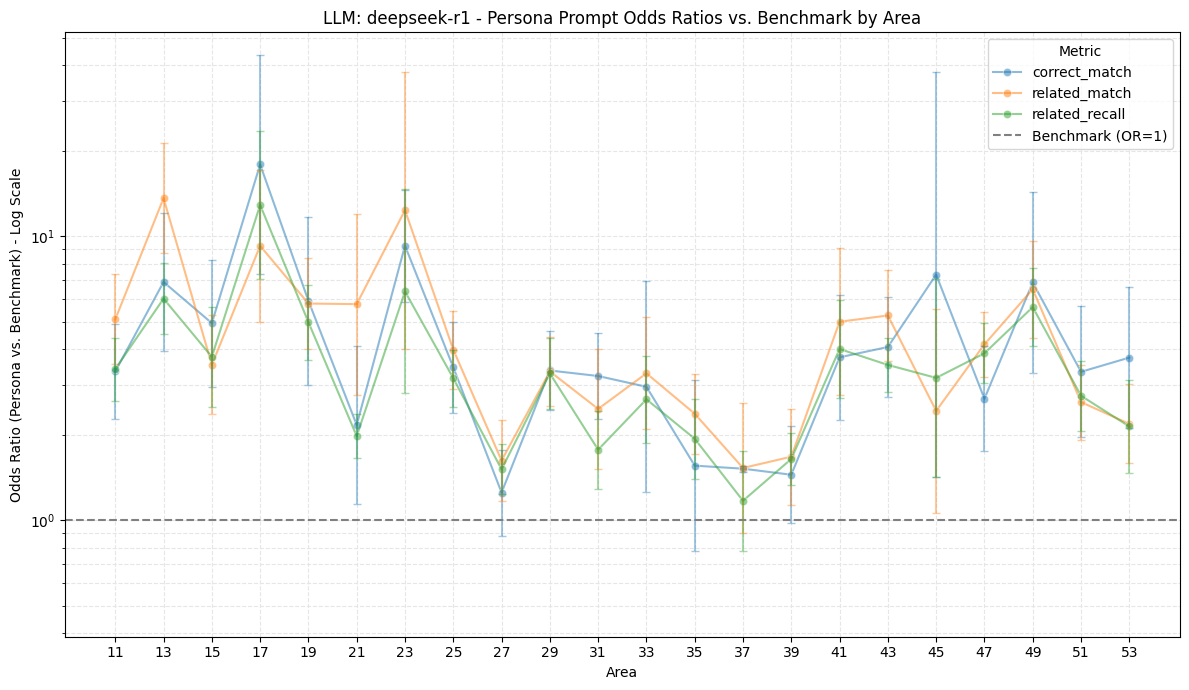

43.59788362289627


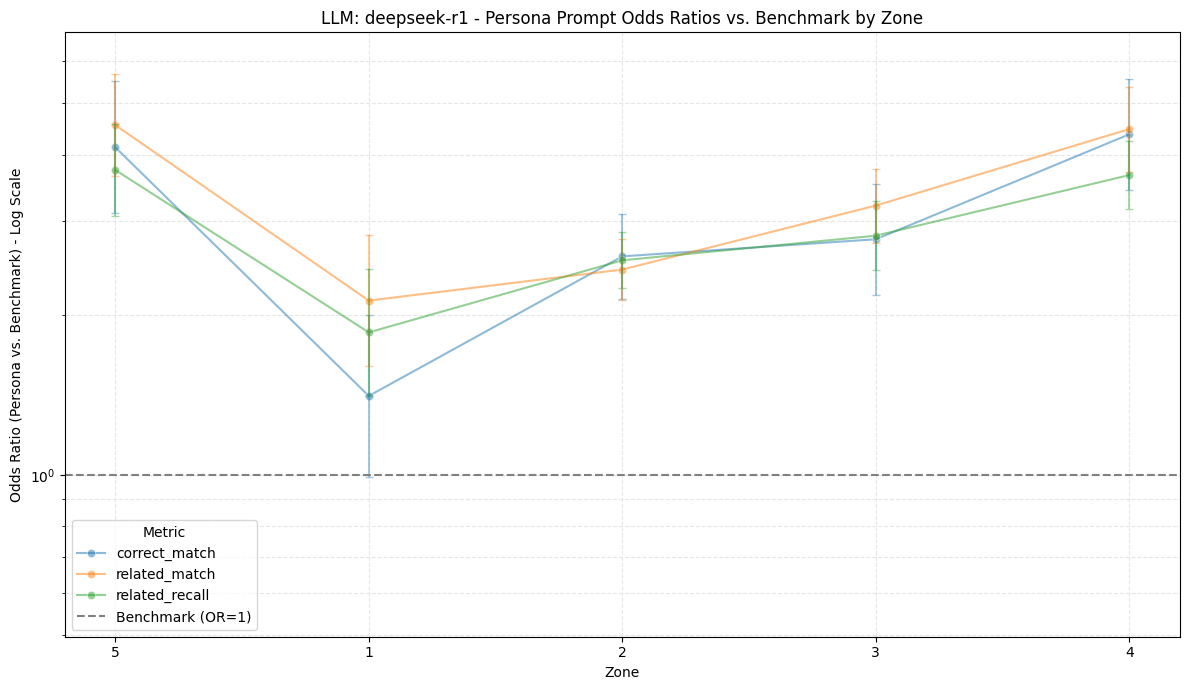

5.658739168922595

--- Plotting Odds Ratios for llm: llama3b ---


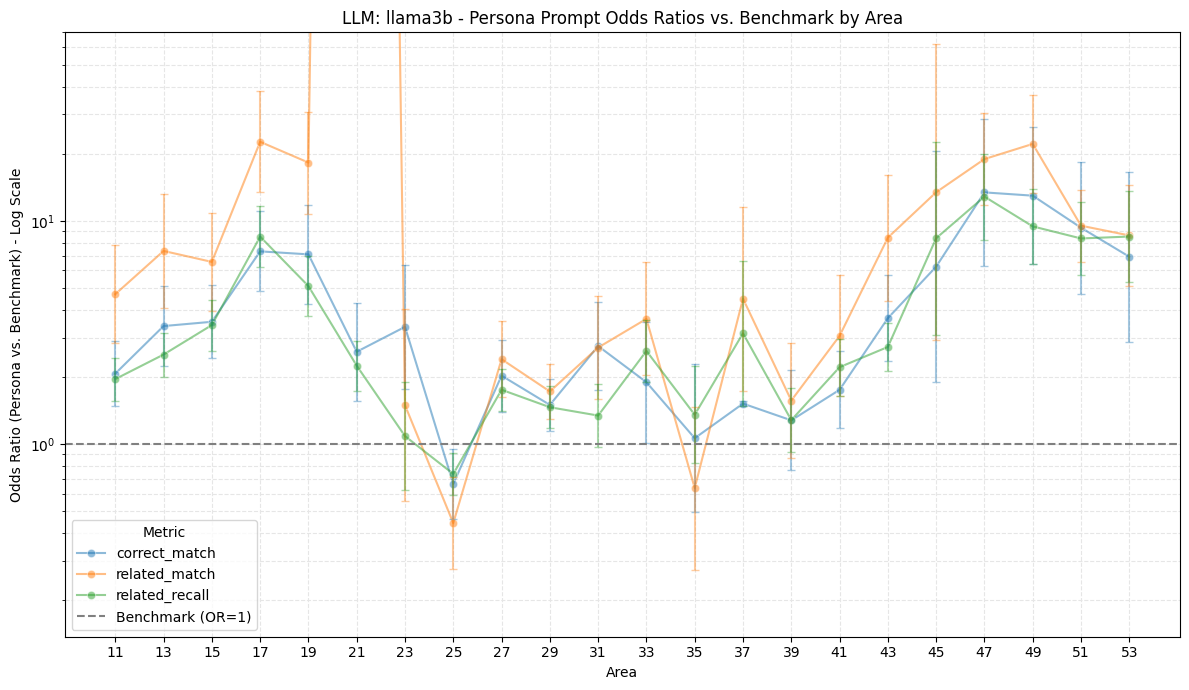

1.5391080942116426e+16


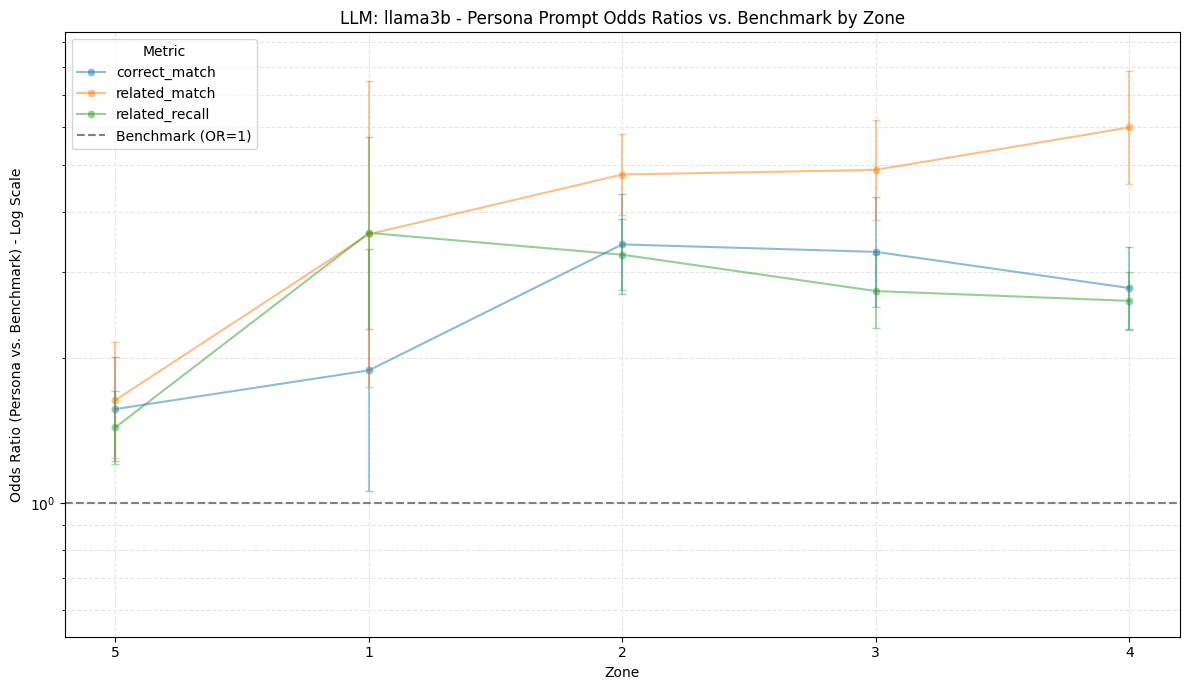

7.854415336260297

--- Plotting Odds Ratios for llm: llama70b ---


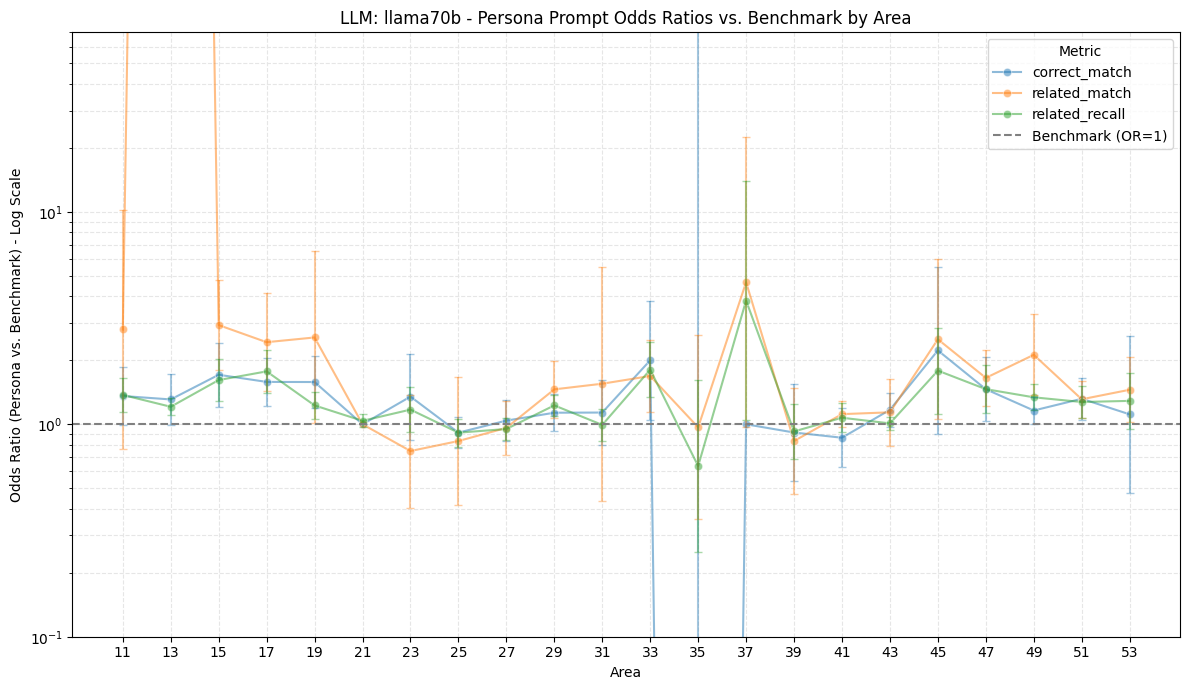

4792960040515358.0


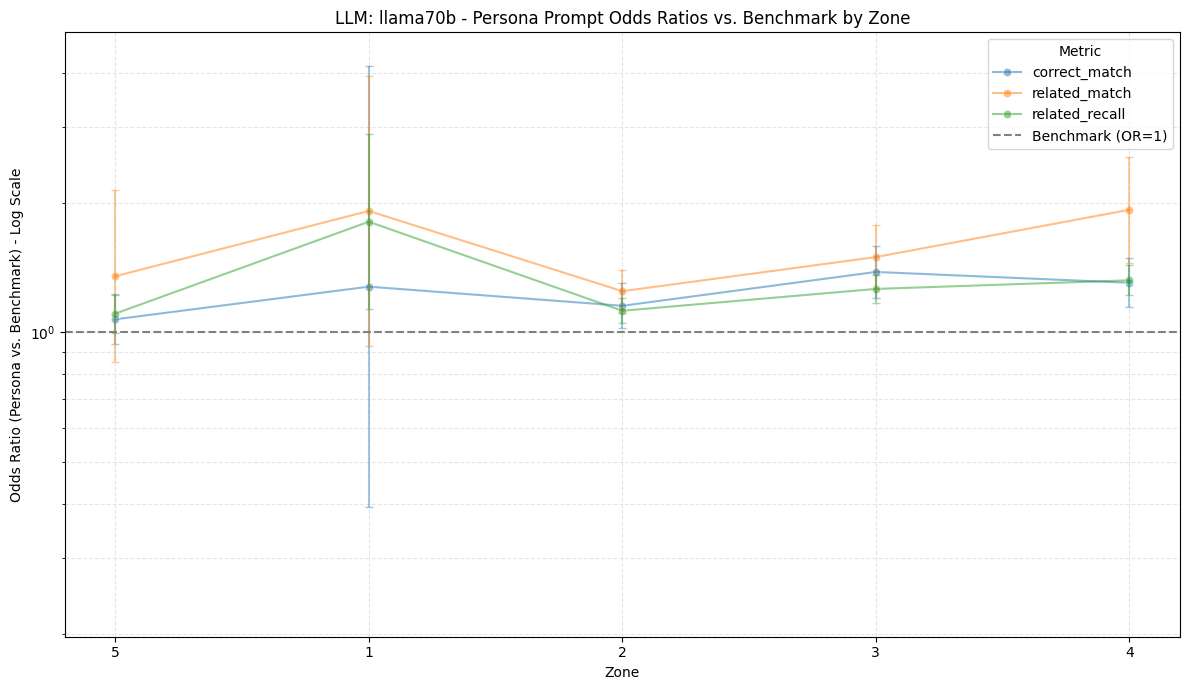

4.1343931645660765

--- Plotting Odds Ratios for llm: mistral ---


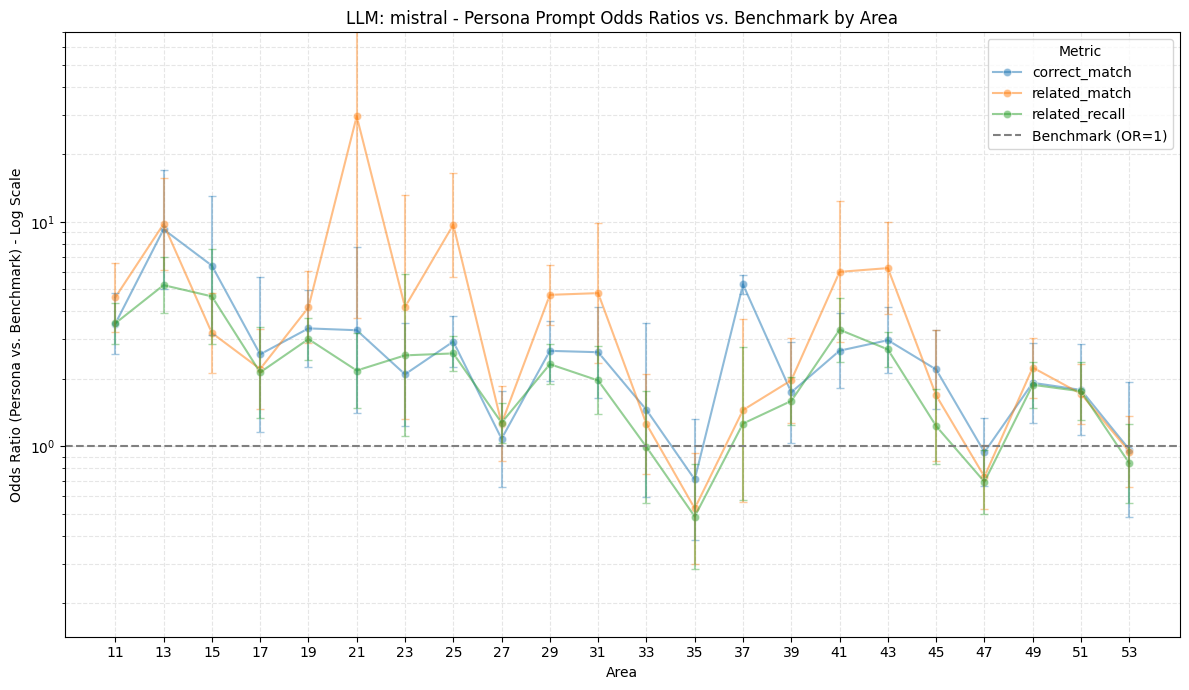

234.8392988896216


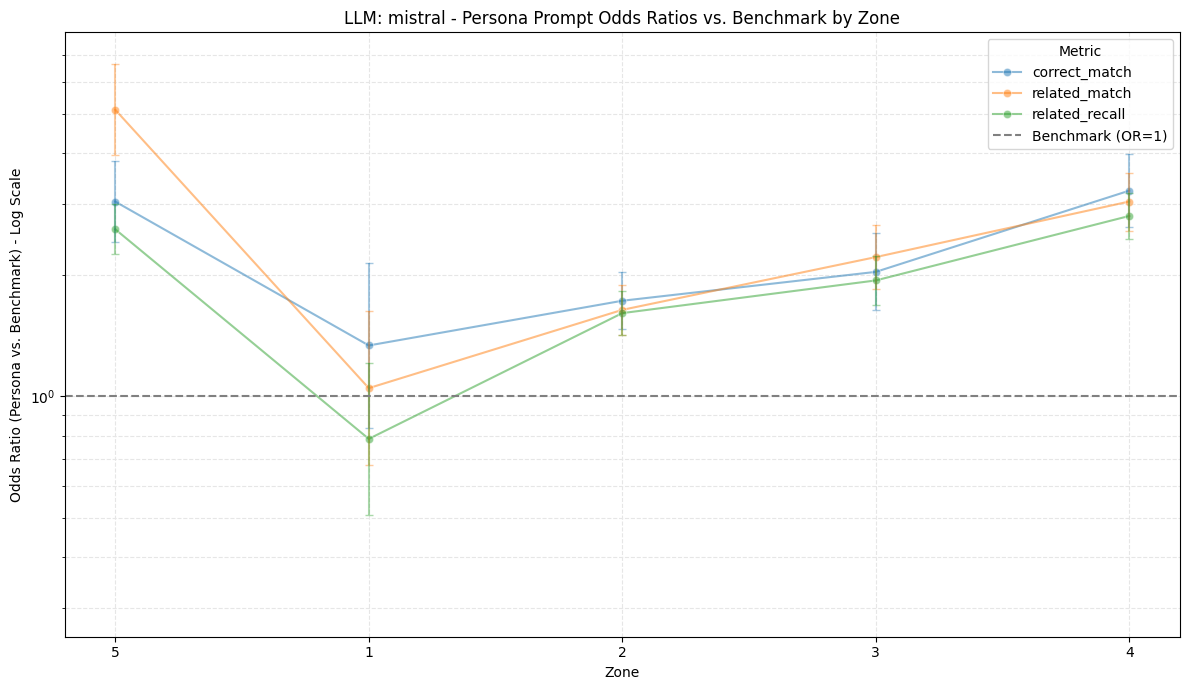

6.641497762152116


In [439]:
llms = ["deepseek-r1", "llama3b","llama70b", "mistral"]

for llm in llms:
    print(f"\n--- Plotting Odds Ratios for llm: {llm} ---")
    # Filter the final_or_df for the current llm
    final_or_df = or_all[or_all['llm'] == llm].copy()
    # --- Plotting the Odds Ratios ---
    if not final_or_df.empty:
        for interaction_type in ['area', 'zone']:
            plot_df = final_or_df[final_or_df[interaction_type].notna()].copy()

            # To ensure consistent plotting order, we need to order the categories based on the specific reference
            # that was used for each outcome.
            
            # Get all unique metrics in the plot_df for this interaction_type
            metrics_in_plot = plot_df['metric'].unique()
            
            # Create a combined list of categories respecting the chosen reference for each metric
            ordered_categories = []
            for metric in metrics_in_plot:
                # Reconstruct the key to get the stored reference
                ref_key = f"{metric}_smoothed_{interaction_type}" if metric == 'related_recall' else f"{metric}_{interaction_type}"
                current_reference_for_plotting = all_reference_categories.get(ref_key, None)

                if current_reference_for_plotting:
                    # Get all unique categories for this interaction type (e.g., all industries)
                    all_cats_for_type = df[interaction_type].cat.categories.tolist()
                    
                    # Remove the reference category if it's not already the first
                    if current_reference_for_plotting in all_cats_for_type:
                        all_cats_for_type.remove(current_reference_for_plotting)
                    
                    # Prepend the reference category to ensure it's first
                    ordered_list_for_metric = [current_reference_for_plotting] + all_cats_for_type
                    
                    # Add to the overall ordered_categories, ensuring uniqueness and order
                    for cat in ordered_list_for_metric:
                        if cat not in ordered_categories:
                            ordered_categories.append(cat)
                else:
                    # Fallback if reference not found (shouldn't happen with proper storage)
                    print(f"Warning: Reference for {metric} and {interaction_type} not found for plotting order.")
                    ordered_categories.extend([cat for cat in plot_df[interaction_type].unique() if cat not in ordered_categories])

            # Apply the determined order for plotting
            plot_df[interaction_type] = pd.Categorical(plot_df[interaction_type], categories=ordered_categories, ordered=True)
            plot_df.sort_values(by=[interaction_type, 'metric'], inplace=True) # Sort by interaction type and then metric

            plt.figure(figsize=(12, 7))
            sns.lineplot(
                data=plot_df,
                x=interaction_type,
                y='odds_ratio',
                hue='metric',
                errorbar=None,
                marker='o',
                alpha=0.5
                
            )

            # Plot confidence intervals manually
            metrics_for_plotting = plot_df['metric'].unique().tolist() # Get unique metrics in the current plot_df
            for i, metric in enumerate(metrics_for_plotting):
                subset = plot_df[plot_df['metric'] == metric].sort_values(by=interaction_type)
                
                # Ensure proper alignment for error bars
                # Convert categorical positions to numerical for errorbar
                x_positions = [plot_df[interaction_type].cat.categories.get_loc(cat) for cat in subset[interaction_type]]

                # Calculate yerr and ensure no negative values
                lower_err = np.maximum(subset['odds_ratio'] - subset['ci_lower'], 0)
                upper_err = np.maximum(subset['ci_upper'] - subset['odds_ratio'], 0)
                plt.errorbar(
                    x=x_positions,
                    y=subset['odds_ratio'],
                    yerr=[lower_err, upper_err],
                    fmt='none',
                    capsize=3,
                    alpha=0.4,
                    color=sns.color_palette()[i] # Match line color using index
                )
                # Add text labels for x-axis ticks
                plt.xticks(ticks=range(len(ordered_categories)), labels=ordered_categories)


            plt.axhline(1, color='gray', linestyle='--', linewidth=1.5, label='Benchmark (OR=1)')
            plt.yscale('log')
            min_or = plot_df['ci_lower'].min()
            max_or = plot_df['ci_upper'].max()
            plt.ylim(max(min_or * 0.5, 0.1), min(max_or * 1.2, 70))
            # plt.ylim(0.16, 50)
            

            plt.title(f'LLM: {llm} - Persona Prompt Odds Ratios vs. Benchmark by {interaction_type.capitalize()}')
            plt.xlabel(interaction_type.capitalize())
            plt.ylabel('Odds Ratio (Persona vs. Benchmark) - Log Scale')
            plt.legend(title='Metric')
            plt.grid(True, which="both", ls="--", c='.9')
            plt.tight_layout()
            plt.show()
            print(max_or)
    else:
        print("\nSkipping plotting as no data was generated.")


--- Plotting Odds Ratios by Area for all LLMs ---


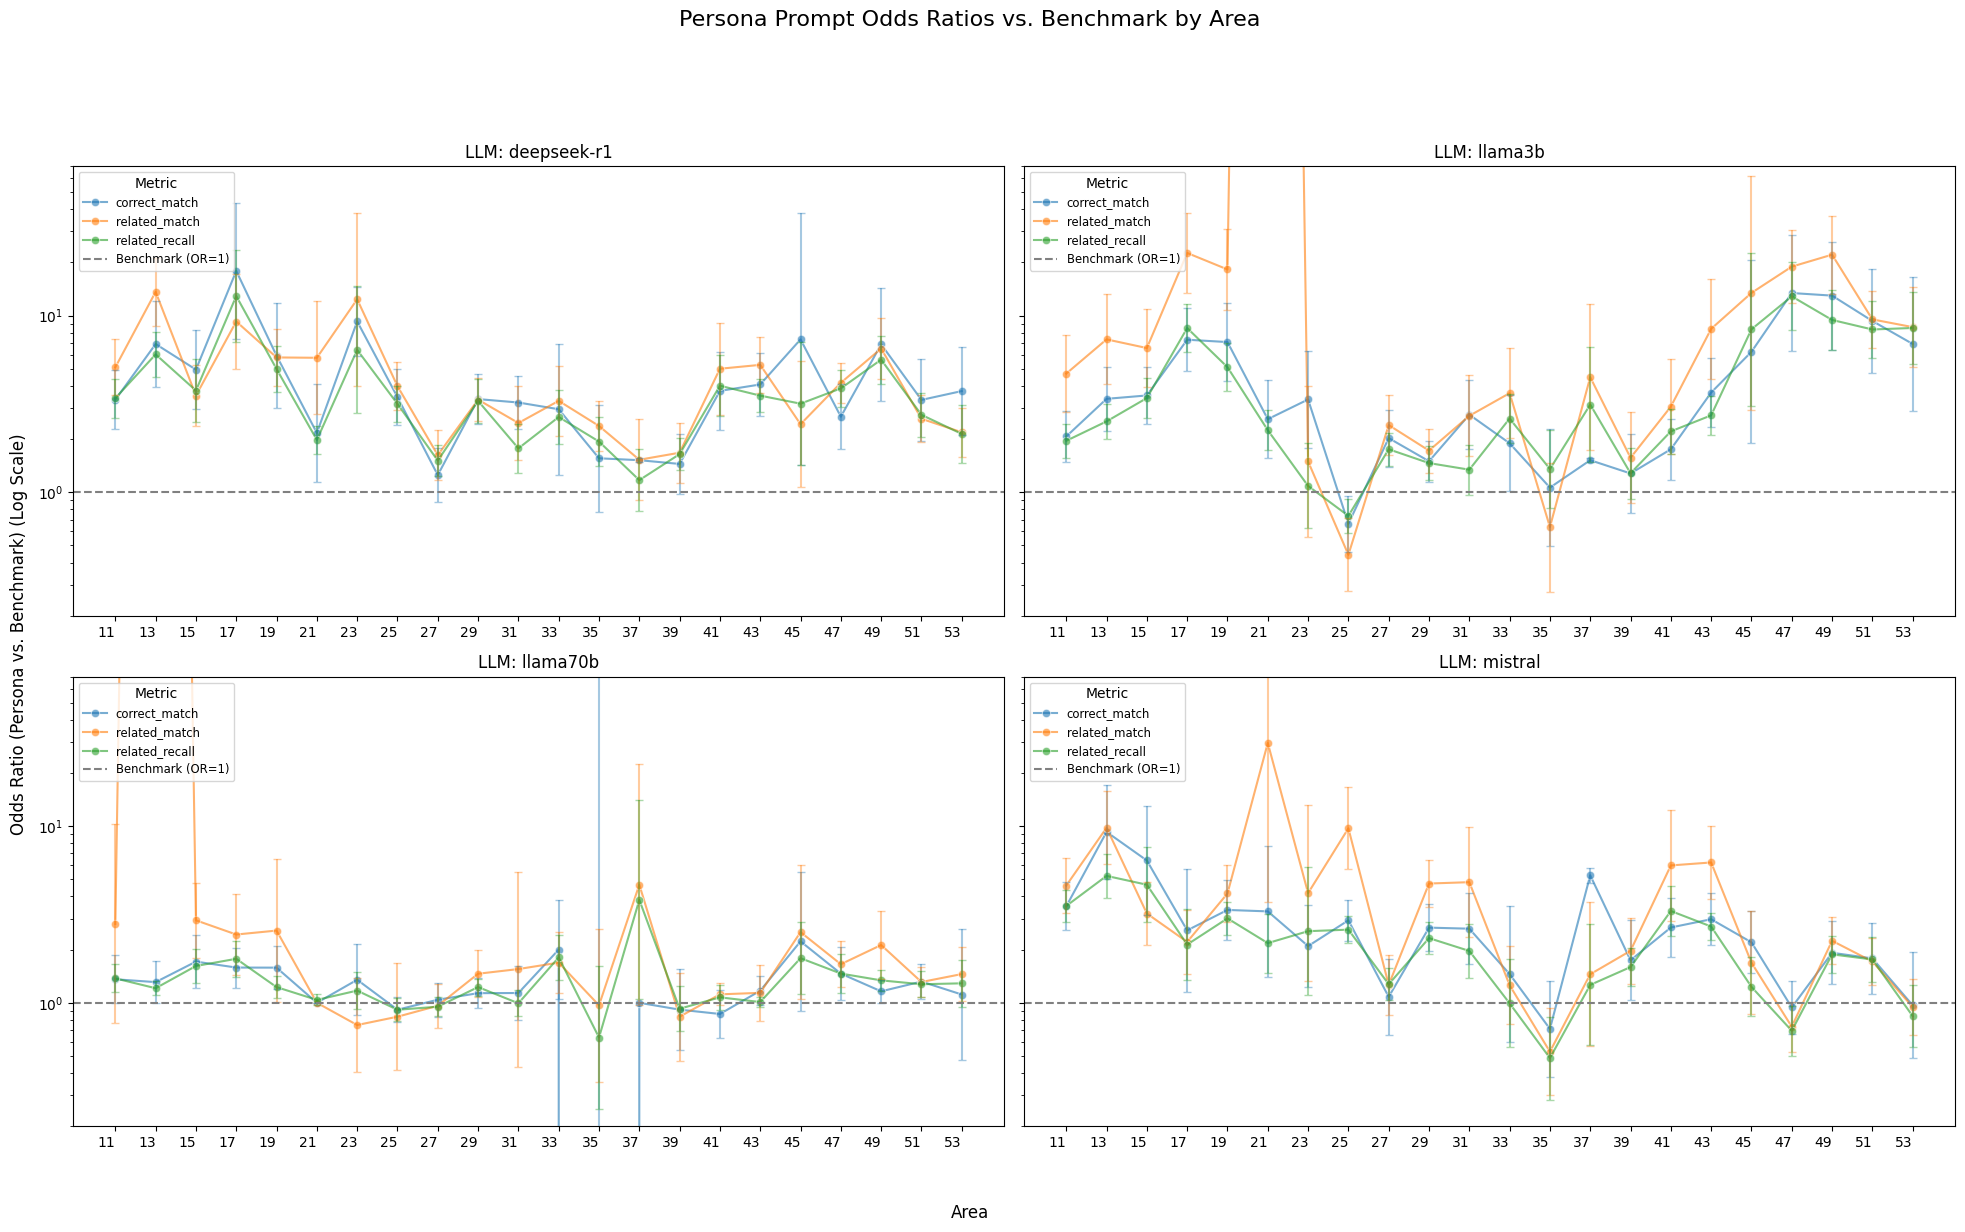


--- Plotting Odds Ratios by Zone for all LLMs ---


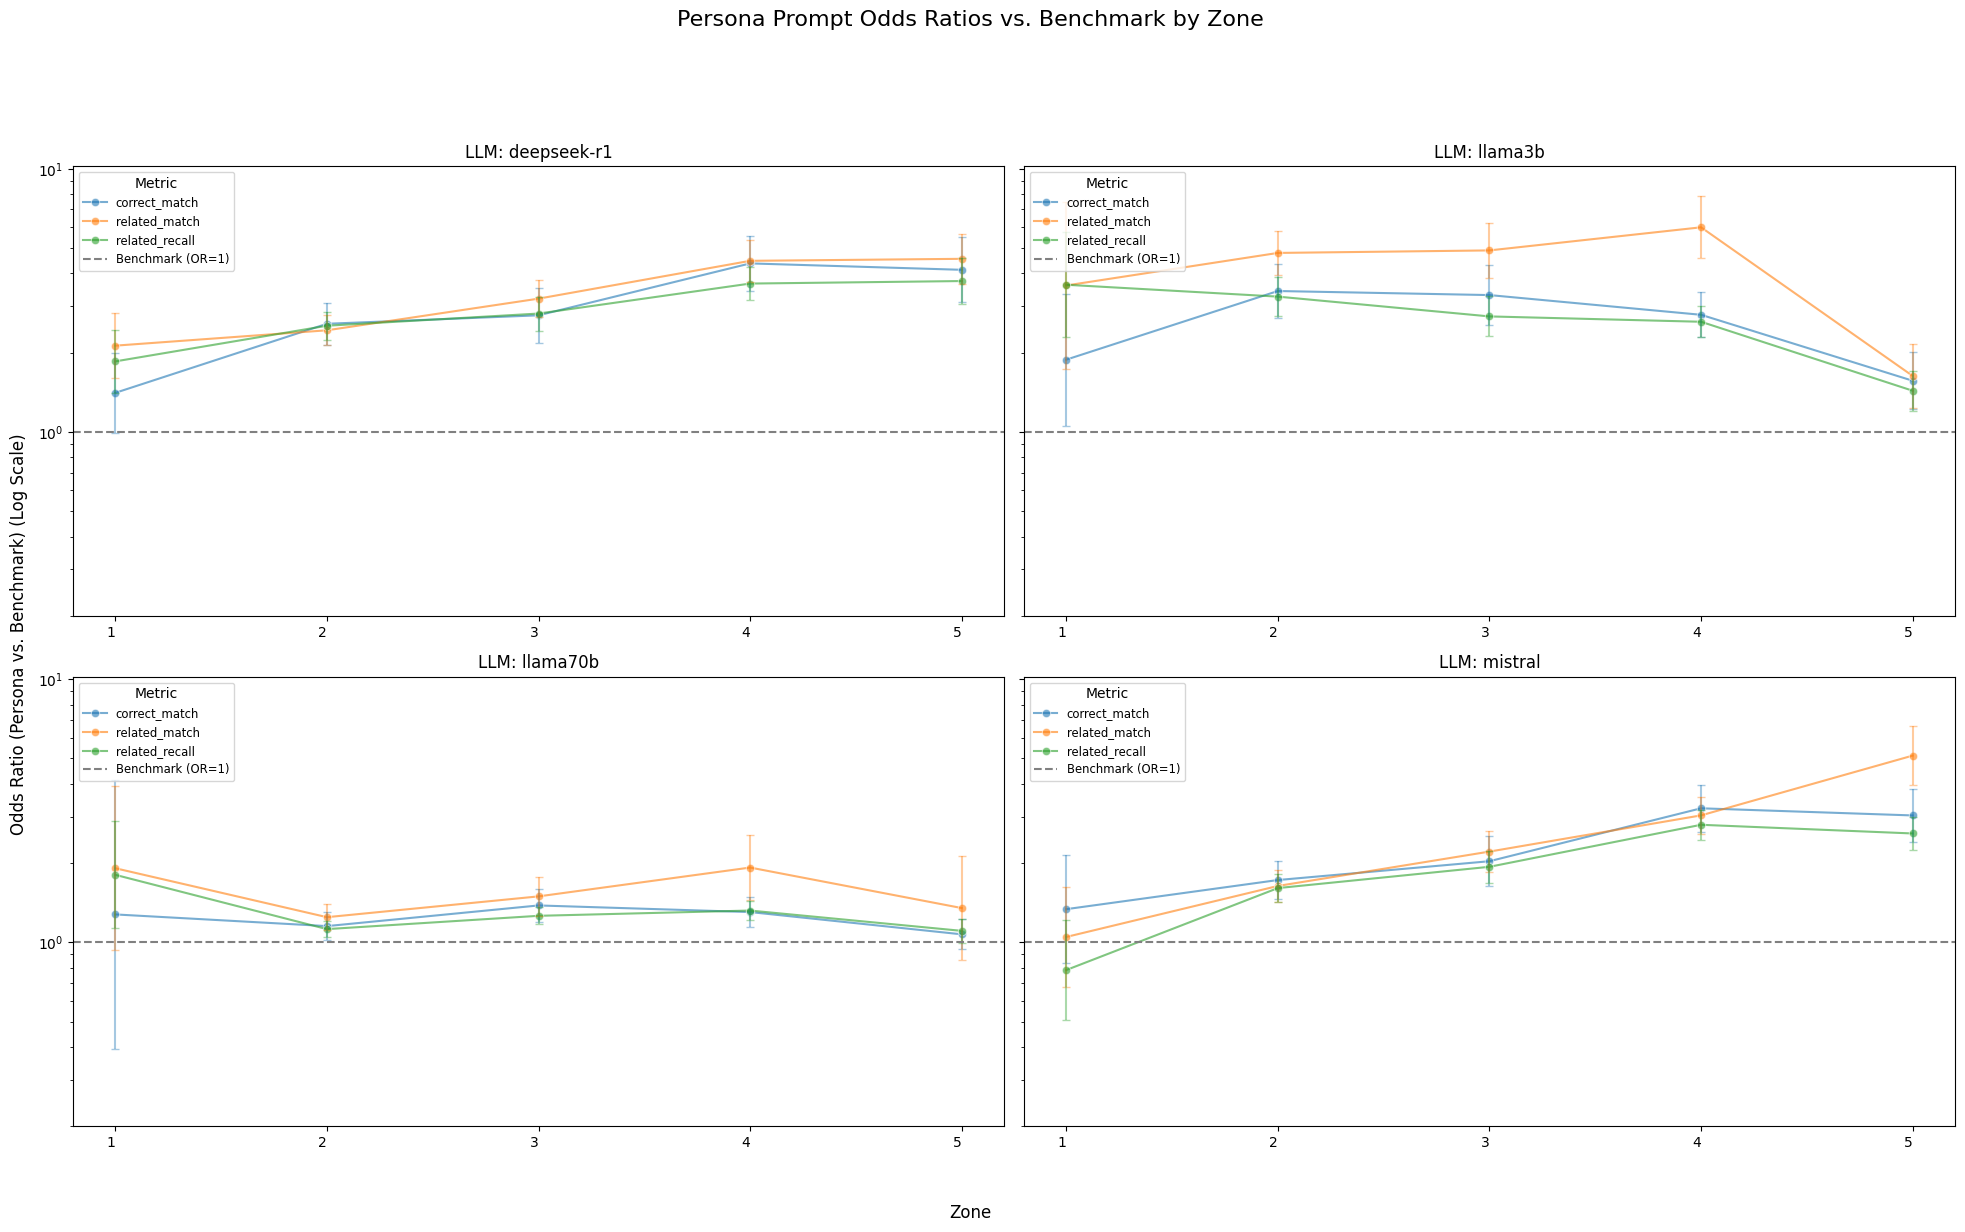


Finished plotting all Odds Ratios.


In [455]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assume 'or_all' DataFrame is already loaded and contains your combined OR results.
# And 'llms' list is defined:
llms = ["deepseek-r1", "llama3b", "llama70b", "mistral"]
or_all['odds_ratio'] = or_all['odds_ratio'].astype(float)
# To ensure consistent categorical order for plotting, define it once.
# Assuming 'area' and 'zone' columns exist in your original df or you know their full sorted categories
# If you don't have the original 'df' available, you can derive categories from 'or_all' directly.
# However, it's safer if you have a canonical list of categories (e.g., from how they were originally defined).
# For example:
# If 'area' was a pandas Categorical type originally with defined categories, use that.
# Otherwise, we'll get unique from 'or_all' and sort them.

# Let's derive the overall categories from or_all for robustness in this snippet.
# This assumes that all categories that should be plotted are present in or_all for at least one LLM/metric.

all_area_categories = sorted(or_all['area'].dropna().unique().tolist())
all_zone_categories = sorted(or_all['zone'].dropna().unique().tolist())

# It's good practice to ensure a 'reference' category is first if it consistently was in your GEEs.
# For simplicity, if your categories are numerical (like '11', '13', '1'), sorted order works.
# If they are strings and you had a specific string reference (e.g., '19-0000'), you'd put that first.
# Example: If '19-0000' was always reference for area:
# if '19-0000' in all_area_categories:
#     all_area_categories.remove('19-0000')
#     all_area_categories = ['19-0000'] + all_area_categories

# For `zone`, if '1' was always reference:
# if '1' in all_zone_categories:
#     all_zone_categories.remove('1')
#     all_zone_categories = ['1'] + all_zone_categories

# You might need to adjust these based on your actual reference categories in the GEE models.
# For now, we'll just use the sorted unique categories.


# --- Plotting the Odds Ratios in Subplots ---
for interaction_type in ['area', 'zone']:
    print(f"\n--- Plotting Odds Ratios by {interaction_type.capitalize()} for all LLMs ---")
    
    # Create the figure and subplots (2x2 for 4 LLMs)
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 12), sharey=True)
    axes = axes.flatten() # Flatten the 2x2 array of axes for easy indexing

    # Determine consistent X-axis order for this interaction_type
    if interaction_type == 'area':
        ordered_categories_for_plot = all_area_categories
    else: # interaction_type == 'zone'
        ordered_categories_for_plot = all_zone_categories

    # Calculate global Y-axis limits for consistent comparison across subplots
    # Filter for the specific interaction_type across all LLMs and metrics
    global_plot_data = or_all[or_all[interaction_type].notna()]
    if not global_plot_data.empty:
        global_min_or = global_plot_data['ci_lower'].min()
        global_max_or = global_plot_data['ci_upper'].max()
        
        # Adjust limits for plotting, ensuring not too close to 0 for log scale
        # Add some padding: 0.7 for lower bound, 1.3 for upper bound
        y_min_plot = max(global_min_or * 0.5, 0.2) # Ensure it's not below 0 and not too close to 0 for log scale
        y_max_plot = min(global_max_or * 1.3, 70) # Cap at 70 for better visibility

        # Set the y-axis limits on the first subplot, which will apply to all due to sharey=True
        axes[0].set_ylim(y_min_plot, y_max_plot)
    else:
        print(f"No data for {interaction_type} to set global y-limits. Skipping plot.")
        plt.close(fig) # Close the empty figure
        continue # Skip to next interaction_type if no data

    for i, llm in enumerate(llms): # Iterate through LLMs to populate each subplot
        ax = axes[i] # Get the current subplot axis

        # Filter the or_all DataFrame for the current llm and interaction type
        plot_df = or_all[(or_all['llm'] == llm) & (or_all[interaction_type].notna())].copy()

        if plot_df.empty:
            ax.set_title(f'LLM: {llm} (No Data)')
            ax.set_xticks([]) # Remove ticks if no data
            ax.set_yticks([])
            continue

        # Apply the determined order for plotting to plot_df's interaction_type column
        plot_df[interaction_type] = pd.Categorical(plot_df[interaction_type], 
                                                   categories=ordered_categories_for_plot, 
                                                   ordered=True)
        plot_df.sort_values(by=[interaction_type, 'metric'], inplace=True)

        sns.lineplot(
            data=plot_df,
            x=interaction_type,
            y='odds_ratio',
            hue='metric',
            errorbar=None, # We'll plot CIs manually
            marker='o',
            alpha=0.6, # Slightly increased alpha for better visibility
            ax=ax # IMPORTANT: specify the subplot axis
        )

        # Plot confidence intervals manually
        metrics_for_plotting = plot_df['metric'].unique().tolist()
        for j, metric in enumerate(metrics_for_plotting):
            subset = plot_df[plot_df['metric'] == metric].sort_values(by=interaction_type)
            
            # Ensure proper alignment for error bars, convert categorical positions to numerical
            x_positions = [plot_df[interaction_type].cat.categories.get_loc(str(cat)) for cat in subset[interaction_type]]

            lower_err = subset['odds_ratio'] - subset['ci_lower']
            upper_err = subset['ci_upper'] - subset['odds_ratio']
            
            # Clamp error bar values to prevent negative lengths on log scale if ci_lower is 0 or very small
            # (though the log scale handles this by pushing it to -infinity if truly 0)
            # For visualization, it's important that ci_lower != 0 to avoid log(0) issues, handled by y_min_plot = max(..., 0.05)
            # np.maximum(lower_err, 0) is also good if ci_lower could theoretically be larger than odds_ratio due to floating point.
            lower_err = np.maximum(subset['odds_ratio'] - subset['ci_lower'], 0)
            upper_err = np.maximum(subset['ci_upper'] - subset['odds_ratio'], 0)
            ax.errorbar( # IMPORTANT: specify the subplot axis
                x=x_positions,
                y=subset['odds_ratio'],
                yerr=[lower_err, upper_err],
                fmt='none',
                capsize=3,
                alpha=0.4,
                color=sns.color_palette()[j] # Match line color using index
            )
            
        # Add text labels for x-axis ticks
        ax.set_xticks(ticks=range(len(ordered_categories_for_plot)))
        ax.set_xticklabels(labels=ordered_categories_for_plot, ha='right')
            
        ax.axhline(1, color='gray', linestyle='--', linewidth=1.5, label='Benchmark (OR=1)')
        ax.set_yscale('log') # Set log scale for each subplot

        ax.set_title(f'LLM: {llm}') # Title for individual subplot
        ax.set_xlabel('') # Clear individual x-labels for common supxlabel
        ax.set_ylabel('') # Clear individual y-labels for common supylabel
        ax.legend(title='Metric', loc='upper left', fontsize='small') # Place legend in each subplot, smaller font
        ax.tick_params(axis='x', labelbottom=True) # Ensure x-labels are visible

    # Set overall figure title and labels
    fig.suptitle(f'Persona Prompt Odds Ratios vs. Benchmark by {interaction_type.capitalize()}', fontsize=16, y=1.02) # Adjust y to move title up
    fig.supxlabel(interaction_type.capitalize(), fontsize=12) 
    fig.supylabel('Odds Ratio (Persona vs. Benchmark) (Log Scale)', fontsize=12) 
    
    plt.tight_layout(rect=[0.01, 0.03, 1, 0.95]) # Adjust layout to make space for suptitle/supx/supy
    plt.show()

print("\nFinished plotting all Odds Ratios.")

In [440]:
or_all

area          metric          llm  odds_ratio  ci_lower   ci_upper zone
0     11   correct_match  deepseek-r1    3.343168  2.271651   4.920108  NaN
1     13   correct_match  deepseek-r1    6.907692  3.938156  12.116384  NaN
2     15   correct_match  deepseek-r1    4.947368  2.956605   8.278569  NaN
3     17   correct_match  deepseek-r1   17.915423  7.361880  43.597884  NaN
4     19   correct_match  deepseek-r1    5.930876  3.001963  11.717429  NaN
..   ...             ...          ...         ...       ...        ...  ...
319  NaN  related_recall      mistral    2.592859  2.246575   2.992518    5
320  NaN  related_recall      mistral    0.784919  0.508149   1.212436    1
321  NaN  related_recall      mistral    1.607757  1.417925   1.823005    2
322  NaN  related_recall      mistral    1.936956  1.681683   2.230979    3
323  NaN  related_recall      mistral    2.797631  2.448782   3.196176    4

[324 rows x 7 columns]

--- GEE Results: Related Recall ~ prompt * zone ---
                                 GEE Regression Results                                 
Dep. Variable:        ['successes', 'failures']   No. Observations:                18460
Model:                                      GEE   No. clusters:                      923
Method:                             Generalized   Min. cluster size:                  20
                           Estimating Equations   Max. cluster size:                  20
Family:                                Binomial   Mean cluster size:                20.0
Dependence structure:              Independence   Num. iterations:                     2
Date:                          Mon, 02 Jun 2025   Scale:                           1.000
Covariance type:                         robust   Time:                         00:51:03
                                                                          coef    std err          z      P>|z|      [0.025      0.975]
-----------

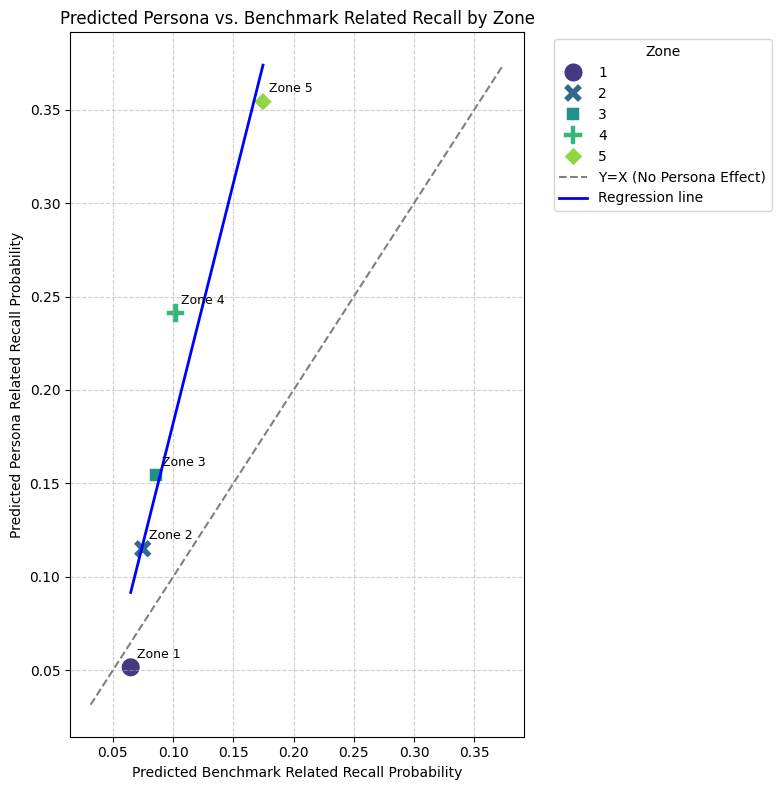


Predicted Probabilities by Zone (for Plotting):
  zone  benchmark   persona
0    1   0.064839  0.051613
1    2   0.074814  0.115051
2    3   0.086164  0.154429
3    4   0.101964  0.241071
4    5   0.174610  0.354221


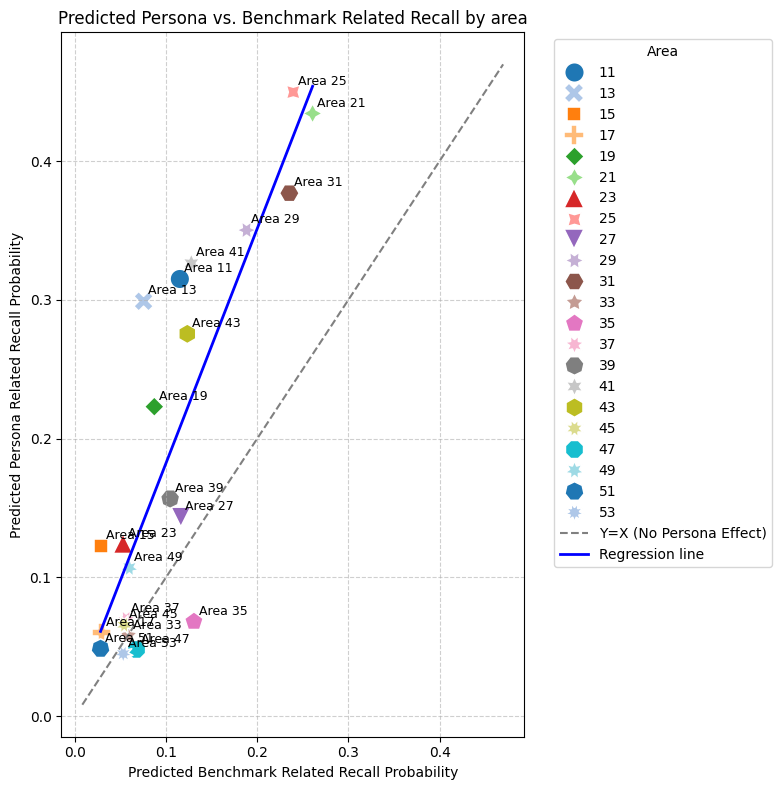


Predicted Probabilities by area (for Plotting):
   area  benchmark   persona
0    11   0.115179  0.315000
1    13   0.075417  0.298958
2    15   0.029167  0.122778
3    17   0.029107  0.060179
4    19   0.087167  0.223000
5    21   0.260714  0.434286
6    23   0.052857  0.124286
7    25   0.239516  0.449677
8    27   0.116250  0.143500
9    29   0.188315  0.350225
10   31   0.235263  0.376842
11   33   0.058462  0.058077
12   35   0.130625  0.068125
13   37   0.056250  0.070000
14   39   0.104516  0.156774
15   41   0.127727  0.326364
16   43   0.123333  0.275490
17   45   0.054167  0.065833
18   47   0.067705  0.048033
19   49   0.059800  0.106800
20   51   0.028224  0.048598
21   53   0.053077  0.045000


In [441]:
df['successes'] = df['related_recall']
df['failures'] = df['trials'] - df['related_recall']
# --- End Dummy Data Creation ---


# --- GEE Model for Related Recall ~ prompt * zone ---
# This model uses the formula as you've provided it.
# patsy automatically determines reference categories if not explicitly set (e.g., C(zone) will use lowest value).
model_formula_zone = 'successes + failures ~ C(prompt, Treatment(reference="benchmark")) + C(zone) + C(prompt, Treatment(reference="benchmark")):C(zone)'
group_var = 'code_id' # Your cluster variable

gee_model_zone = smf.gee(
    model_formula_zone,
    data=df, # Use your actual filtered df here
    groups=df[group_var],
    family=sm.families.Binomial(),
    cov_type='robust',
    # scale=None # Uncomment if you explicitly use scale=None in your actual model
)
gee_results_zone = gee_model_zone.fit()

print("--- GEE Results: Related Recall ~ prompt * zone ---")
print(gee_results_zone.summary())


# --- GEE Model for Related Recall ~ prompt * area ---
model_formula_area = 'successes + failures ~ C(prompt, Treatment(reference="benchmark")) + C(area) + C(prompt, Treatment(reference="benchmark")):C(area)'

gee_model_area = smf.gee(
    model_formula_area,
    data=df, # Use your actual filtered df here
    groups=df[group_var],
    family=sm.families.Binomial(),
    cov_type='robust',
    # scale=None # Uncomment if you explicitly use scale=None in your actual model
)
gee_results_area = gee_model_area.fit()

print("\n--- GEE Results: Related Recall ~ prompt * area ---")
print(gee_results_area.summary())


# --- Generate Predictions for Plotting (ROBUST METHOD) ---

def plot_predictions(model_results, group_col, title_suffix):
    """
    Generates and plots predicted probabilities for benchmark vs persona
    for a given model and grouping column.

    Args:
        model_results (statsmodels.genmod.generalized_estimating_equations.GEEResultsWrapper):
            Fitted GEE model results.
        group_col (str): The name of the column representing the grouping variable
                         (e.g., 'zone' or 'area').
        title_suffix (str): Suffix for plot title (e.g., "by Zone" or "by area").
    """
    all_groups = sorted(df[group_col].unique())
    all_prompts = ['benchmark', 'persona']

    # Create a DataFrame for prediction based on unique groups and prompts
    predict_df = pd.DataFrame([(g, p) for g in all_groups for p in all_prompts], columns=[group_col, 'prompt'])
    predict_df['trials'] = 1 # Context for prediction

    # Get the DesignInfo from the original model's data object.
    # This automatically captures the exact formula parsing, including reference levels.
    design_info = model_results.model.data.design_info

    # Build the design matrix for prediction using the DesignInfo
    # This ensures column names and reference levels are IDENTICAL to the training model.
    design_matrix = patsy.build_design_matrices([design_info], predict_df)[0]

    # Calculate linear predictor (log-odds)
    linear_predictor = design_matrix.dot(model_results.params)

    # Convert log-odds to probabilities using the inverse logit (sigmoid) function
    predicted_probs = 1 / (1 + np.exp(-linear_predictor))

    predict_df['predicted_prob'] = predicted_probs

    # Pivot for plotting
    plot_df = predict_df.pivot(index=group_col, columns='prompt', values='predicted_prob').reset_index()
    plot_df.columns.name = None

    # --- Plotting ---
    plt.figure(figsize=(8, 8))
    sns.scatterplot(x='benchmark', y='persona', data=plot_df, hue=group_col, s=200, style=group_col, markers=True, legend='full', palette='viridis' if group_col == 'zone' else 'tab20')

    # Add labels for each point
    for i, row in plot_df.iterrows():
        plt.text(row['benchmark'] + 0.005, row['persona'] + 0.005, f'{group_col.capitalize()} {row[group_col]}', fontsize=9)

    # Add a Y=X line for comparison
    x_vals = np.linspace(min(plot_df['benchmark'].min(), plot_df['persona'].min()) - 0.02,
                         max(plot_df['benchmark'].max(), plot_df['persona'].max()) + 0.02, 100)
    plt.plot(x_vals, x_vals, color='gray', linestyle='--', label='Y=X (No Persona Effect)')

    x = plot_df["benchmark"].values
    y = plot_df["persona"].values
    slope, intercept = np.polyfit(x, y, 1)
    x_fit = np.array([x.min(), x.max()])
    y_fit = slope * x_fit + intercept
    plt.plot(x_fit, y_fit, color='blue', linestyle='-', linewidth=2, label='Regression line')

    plt.title(f'Predicted Persona vs. Benchmark Related Recall {title_suffix}')
    plt.xlabel('Predicted Benchmark Related Recall Probability')
    plt.ylabel('Predicted Persona Related Recall Probability')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(title=group_col.capitalize(), bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    print(f"\nPredicted Probabilities {title_suffix} (for Plotting):")
    print(plot_df)

# --- Call the function for Zone ---
plot_predictions(gee_results_zone, 'zone', 'by Zone')

# --- Call the function for area ---
plot_predictions(gee_results_area, 'area', 'by area')

In [442]:
or_all['odds_ratio'] = or_all['odds_ratio'].astype(float).map('{:.4f}'.format)
or_all[
    # (or_all['llm'] == 'llama70b') &
    (or_all['metric'] == 'related_recall') &
    (or_all['zone']=="4")#.notna())
].sort_values(by=['odds_ratio'], ascending=False).reset_index(drop=True)

area          metric          llm odds_ratio  ci_lower  ci_upper zone
0  NaN  related_recall  deepseek-r1     3.6605  3.159807  4.240458    4
1  NaN  related_recall      mistral     2.7976  2.448782  3.196176    4
2  NaN  related_recall      llama3b     2.6204  2.284930  3.005217    4
3  NaN  related_recall     llama70b     1.3210  1.220174  1.430083    4


--- Diagnosing potential Perfect Separation ---
Diagnosing for: correct_match
Diagnosing for: related_match
Diagnosing for: related_recall
--- End Diagnosis ---

DataFrame head after critical preprocessing for GEE:
      prompt zone area     code_id  correct_match  related_match  \
0  benchmark    5   11  11-1011.00              0              1   
1  benchmark    5   11  11-1011.03              0              0   
2  benchmark    4   11  11-1021.00              0              1   
3  benchmark    4   11  11-1031.00              0              0   
4  benchmark    4   11  11-2011.00              0              1   

   related_recall  trials  successes_recall  failures_recall  
0             0.4       1               0.4              0.6  
1             0.0       1               0.0              1.0  
2             0.5       1               0.5              0.5  
3             0.0       1               0.0              1.0  
4             0.8       1               0.8              0.2

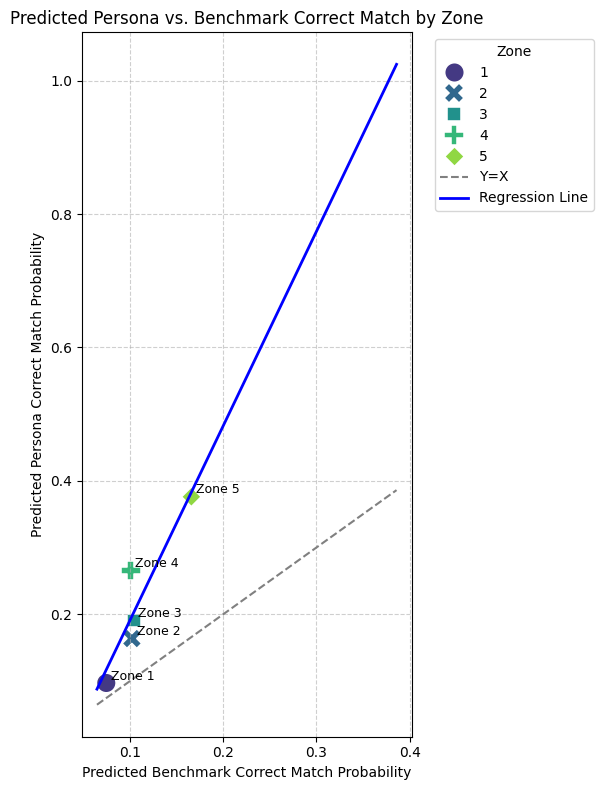


Predicted Probabilities for Plotting (correct_match by zone):
  zone  benchmark   persona
0    1   0.074194  0.096774
1    2   0.101695  0.163390
2    3   0.103653  0.190411
3    4   0.100446  0.265179
4    5   0.165584  0.375974
Selected Reference for area: 11 (first in list)

--- Running GEE Model for: correct_match with prompt * area (Reference: 11) ---

--- GEE Results Summary for correct_match ~ prompt * area ---
                               GEE Regression Results                              
Dep. Variable:               correct_match   No. Observations:                18460
Model:                                 GEE   No. clusters:                      923
Method:                        Generalized   Min. cluster size:                  20
                      Estimating Equations   Max. cluster size:                  20
Family:                           Binomial   Mean cluster size:                20.0
Dependence structure:         Exchangeable   Num. iterations:            

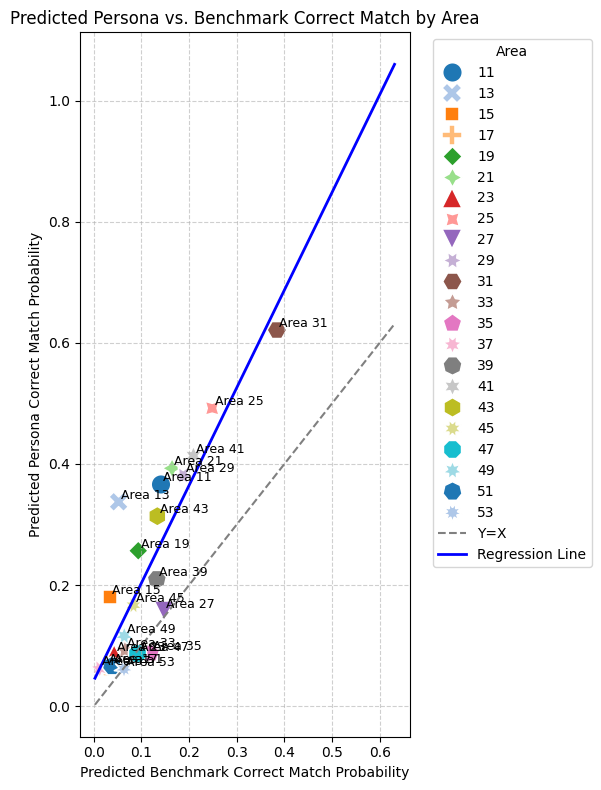


Predicted Probabilities for Plotting (correct_match by area):
   area  benchmark   persona
0    11   0.141071  0.366071
1    13   0.052083  0.337500
2    15   0.033333  0.180556
3    17   0.026786  0.066071
4    19   0.093333  0.256667
5    21   0.164286  0.392857
6    23   0.042857  0.085714
7    25   0.248387  0.491935
8    27   0.147500  0.157500
9    29   0.187640  0.380899
10   31   0.384211  0.621053
11   33   0.065385  0.092308
12   35   0.118750  0.087500
13   37   0.012500  0.062500
14   39   0.132258  0.209677
15   41   0.209091  0.413636
16   43   0.133333  0.313725
17   45   0.083333  0.166667
18   47   0.091803  0.086885
19   49   0.064000  0.116000
20   51   0.038318  0.066355
21   53   0.063462  0.061538
Selected Reference for zone: 5 (first in list)

--- Running GEE Model for: related_match with prompt * zone (Reference: 5) ---

--- GEE Results Summary for related_match ~ prompt * zone ---
                               GEE Regression Results                           

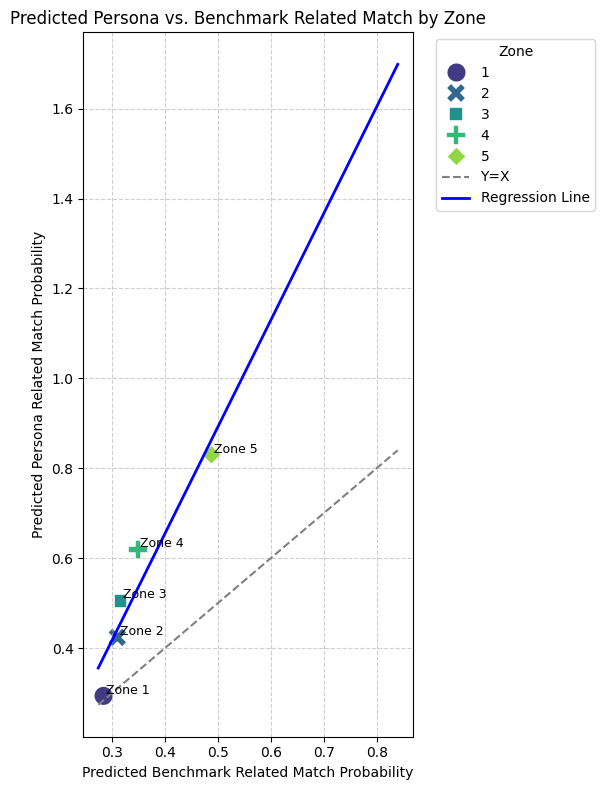


Predicted Probabilities for Plotting (related_match by zone):
  zone  benchmark   persona
0    1   0.283871  0.293548
1    2   0.309831  0.423729
2    3   0.315982  0.505479
3    4   0.348661  0.619196
4    5   0.487662  0.829870
Selected Reference for area: 11 (first in list)

--- Running GEE Model for: related_match with prompt * area (Reference: 11) ---

--- GEE Results Summary for related_match ~ prompt * area ---
                               GEE Regression Results                              
Dep. Variable:               related_match   No. Observations:                18460
Model:                                 GEE   No. clusters:                      923
Method:                        Generalized   Min. cluster size:                  20
                      Estimating Equations   Max. cluster size:                  20
Family:                           Binomial   Mean cluster size:                20.0
Dependence structure:         Exchangeable   Num. iterations:            

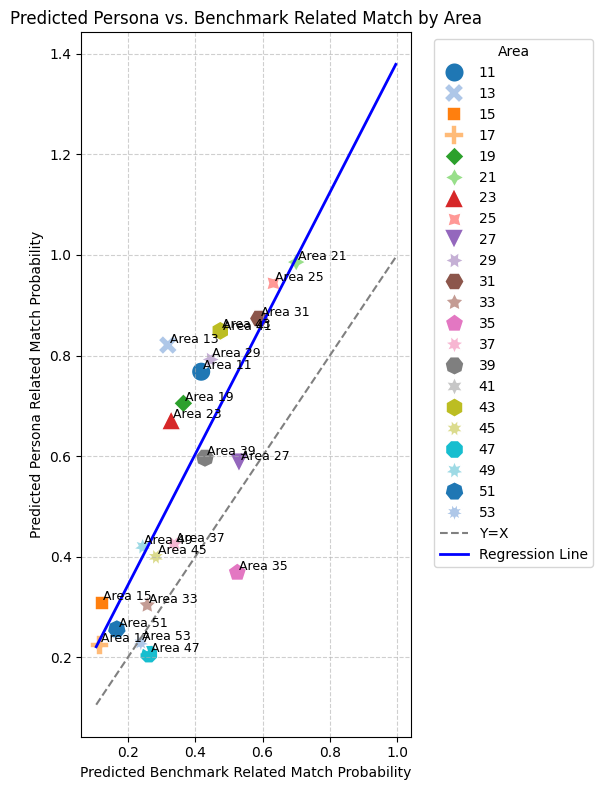


Predicted Probabilities for Plotting (related_match by area):
   area  benchmark   persona
0    11   0.417857  0.767857
1    13   0.318750  0.820833
2    15   0.122222  0.308333
3    17   0.116071  0.225000
4    19   0.365000  0.705000
5    21   0.700000  0.985714
6    23   0.328571  0.671429
7    25   0.632258  0.943548
8    27   0.530000  0.587500
9    29   0.446067  0.792135
10   31   0.589474  0.873684
11   33   0.257692  0.303846
12   35   0.525000  0.368750
13   37   0.337500  0.425000
14   39   0.429032  0.596774
15   41   0.477273  0.845455
16   43   0.474510  0.849020
17   45   0.283333  0.400000
18   47   0.262295  0.206557
19   49   0.244000  0.420000
20   51   0.167290  0.256075
21   53   0.238462  0.228846
Selected Reference for zone: 5 (first in list)

--- Running GEE Model for: related_recall with prompt * zone (Reference: 5) ---

--- GEE Results Summary for related_recall ~ prompt * zone ---
                                        GEE Regression Results                

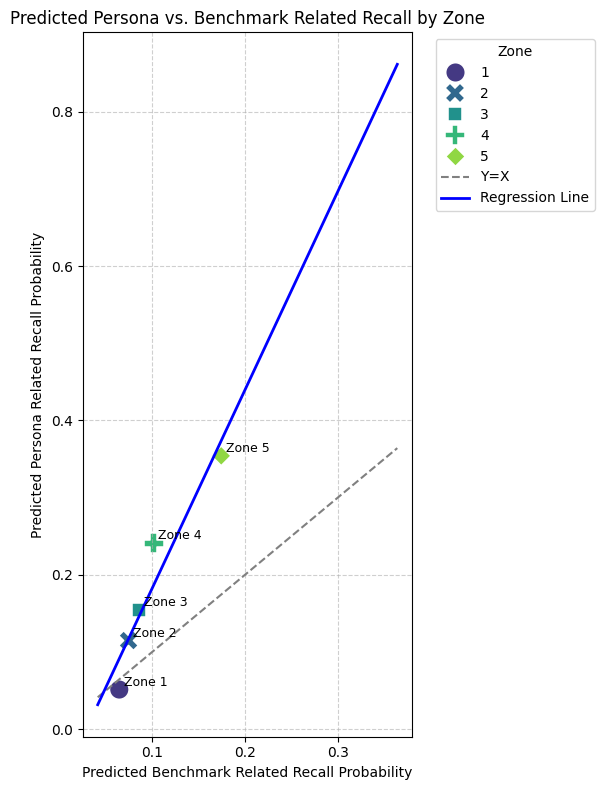


Predicted Probabilities for Plotting (related_recall by zone):
  zone  benchmark   persona
0    1   0.064839  0.051613
1    2   0.074814  0.115051
2    3   0.086164  0.154429
3    4   0.101964  0.241071
4    5   0.174610  0.354221
Selected Reference for area: 11 (first in list)

--- Running GEE Model for: related_recall with prompt * area (Reference: 11) ---

--- GEE Results Summary for related_recall ~ prompt * area ---
                                        GEE Regression Results                                        
Dep. Variable:        ['successes_recall', 'failures_recall']   No. Observations:                18460
Model:                                                    GEE   No. clusters:                      923
Method:                                           Generalized   Min. cluster size:                  20
                                         Estimating Equations   Max. cluster size:                  20
Family:                                              Binomi

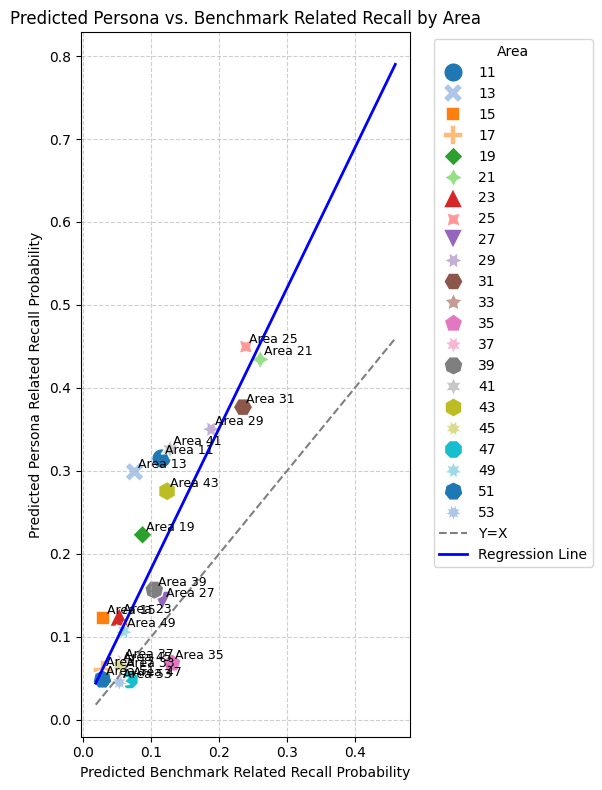


Predicted Probabilities for Plotting (related_recall by area):
   area  benchmark   persona
0    11   0.115179  0.315000
1    13   0.075417  0.298958
2    15   0.029167  0.122778
3    17   0.029107  0.060179
4    19   0.087167  0.223000
5    21   0.260714  0.434286
6    23   0.052857  0.124286
7    25   0.239516  0.449677
8    27   0.116250  0.143500
9    29   0.188315  0.350225
10   31   0.235263  0.376842
11   33   0.058462  0.058077
12   35   0.130625  0.068125
13   37   0.056250  0.070000
14   39   0.104516  0.156774
15   41   0.127727  0.326364
16   43   0.123333  0.275490
17   45   0.054167  0.065833
18   47   0.067705  0.048033
19   49   0.059800  0.106800
20   51   0.028224  0.048598
21   53   0.053077  0.045000


In [505]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.genmod import families
from statsmodels.genmod import cov_struct
from statsmodels.genmod.families import links
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import patsy # Needed for building design matrices

# Suppress specific warnings for cleaner output
warnings.filterwarnings("ignore", category=UserWarning, module="statsmodels")
warnings.filterwarnings("ignore", category=sm.tools.sm_exceptions.ConvergenceWarning)


# --- Data Loading and Initial Preprocessing ---
json_path = r'd:\OneDrive - Universität Mannheim\MMM\Master Thesis\Teapot\results\task1\task1_data.json'
code_path = r"d:\OneDrive - Universität Mannheim\MMM\Master Thesis\Teapot\datasets\occupation.xlsx"
zone_path = r"d:\OneDrive - Universität Mannheim\MMM\Master Thesis\Teapot\datasets\job_zone.xlsx"

try:
    df = pd.read_json(json_path, lines=True)
except FileNotFoundError:
    print(f"Error: File {json_path} not found. Check path.")
    raise

# Filter for model and preprocess (using a sample LLM for demonstration)
llm = "mistral"  # Change this to the desired model
df['model'] = df['model'].replace('llama3.2', 'llama3b').replace('llama3.3', 'llama70b')
df['prompt'] = df['prompt'].replace('no', 'benchmark').replace('prompt1', 'persona')
df['prompt'] = df['prompt'].astype('category')
df = df[df['model'] == llm].copy()
df.drop(columns=['all_fit'], inplace=True, errors='ignore')
df.rename(columns={'c_all_fit_hits': 'correct_match', 'r_all_fit_hits': 'related_match', 'r_all_fit_recall': 'related_recall'}, inplace=True)

try:
    occupation = pd.read_excel(code_path)
    occupation.drop(columns=['Description'], inplace=True)
    occupation.columns = ['code', 'title']
    zone = pd.read_excel(zone_path)
    zone = zone[['Title', 'Job Zone']]
    zone.columns = ['title', 'zone']
except FileNotFoundError as e:
    print(f"Error: Excel file not found: {e}")
    raise

df = df.merge(occupation, on='title', how='left')
df = df.merge(zone, on='title', how='left')

df['area'] = df['code'].apply(lambda x: x.split('-')[0] if pd.notnull(x) else np.nan).fillna('Unknown')
df['trials'] = 1 # This will be used as the denominator for related_recall_smoothed

# --- DIAGNOSE PERFECT SEPARATION ---
print("\n--- Diagnosing potential Perfect Separation ---")
for outcome_to_diag in ['correct_match', 'related_match', 'related_recall']:
    print(f"Diagnosing for: {outcome_to_diag}")
    for p in df['prompt'].unique():
        for i in df['area'].unique():
            subset = df[(df['prompt'] == p) & (df['area'] == i)]
            if not subset.empty:
                min_val = subset[outcome_to_diag].min()
                max_val = subset[outcome_to_diag].max()
                if min_val == max_val and (min_val == 0 or min_val == 1 if outcome_to_diag in ['correct_match', 'related_match'] else (min_val == 0 or min_val == 10)): # 10 is max for recall
                    print(f"Warning: Perfect separation (all {min_val}s) for prompt='{p}', area='{i}', outcome='{outcome_to_diag}' (n={len(subset)})")
        for z in df['zone'].unique():
            subset = df[(df['prompt'] == p) & (df['zone'] == z)]
            if not subset.empty:
                min_val = subset[outcome_to_diag].min()
                max_val = subset[outcome_to_diag].max()
                if min_val == max_val and (min_val == 0 or min_val == 1 if outcome_to_diag in ['correct_match', 'related_match'] else (min_val == 0 or min_val == 10)):
                    print(f"Warning: Perfect separation (all {min_val}s) for prompt='{p}', zone='{z}', outcome='{outcome_to_diag}' (n={len(subset)})")
print("--- End Diagnosis ---")


# --- APPLY DATA JITTERING / SMOOTHING FOR RELATED_RECALL ---
# Only apply smoothing if related_recall has values beyond 0 and 10 to smooth
# Otherwise, it might create issues if all values are 0 or 10.
# The previous solution of adding 0.5/1.0 is generally for binomial models
# when actual counts are 0/N, but related_recall here is 0-10, so it's a count.
# For Count outcomes, if there's no smoothing needed based on model convergence,
# we can use the raw 'related_recall' or define 'successes'/'failures' directly.
# Let's keep it simple for now and rely on binomial family for counts.

df['successes_recall'] = df['related_recall'].copy()
df['failures_recall'] = df['trials'] - df['related_recall']


# Ensure 'area' and 'zone' are categorical before reference selection
df['area'] = df['area'].astype('category')
df['zone'] = df['zone'].astype(str).astype('category') # Ensure string then category


# Categorical type and order for 'prompt' and 'code_id'
df['prompt'] = pd.Categorical(df['prompt'], categories=['benchmark', 'persona'], ordered=False)
df['code_id'] = pd.Categorical(df['code'])

print("\nDataFrame head after critical preprocessing for GEE:")
print(df[['prompt', 'zone', 'area', 'code_id', 'correct_match', 'related_match', 'related_recall', 'trials', 'successes_recall', 'failures_recall']].head())
print(f"Number of unique code_id groups: {df['code_id'].nunique()}")


# --- Helper function to get the first category as reference ---
def get_reference_category(dataframe, category_col):
    """
    Determines the reference category for a given categorical column.
    The reference category is simply the first unique category in the list.
    """
    unique_categories = dataframe[category_col].unique().tolist()
    
    if not unique_categories:
        print(f"Warning: No unique categories found for {category_col}. Cannot determine reference.")
        return None 
    
    reference_category = unique_categories[0]
    print(f"Selected Reference for {category_col}: {reference_category} (first in list)")
    return reference_category


# --- Helper Function for Running GEE Models and Generating Predictions for Plotting ---
def run_gee_and_plot_predictions(dataframe, outcome_var, interaction_type, llm_name):
    """
    Runs a GEE model for the given outcome and interaction type,
    then generates and plots predicted probabilities for benchmark vs persona.
    """
    
    # Determine the reference category for the current interaction_type
    ref_interaction_val = get_reference_category(dataframe, interaction_type)

    print(f"\n--- Running GEE Model for: {outcome_var} with prompt * {interaction_type} (Reference: {ref_interaction_val}) ---")

    # Dynamically build the formula based on outcome type
    if outcome_var == 'related_recall':
        formula = f"successes_recall + failures_recall ~ C(prompt, Treatment(reference='benchmark')) * C({interaction_type}, Treatment(reference='{ref_interaction_val}'))"
    else: # For correct_match, related_match (binary)
        formula = f"{outcome_var} ~ C(prompt, Treatment(reference='benchmark')) * C({interaction_type}, Treatment(reference='{ref_interaction_val}'))"
    
    family_instance = families.Binomial(link=links.Logit())
    
    # Use code_id as the group variable (your cluster variable)
    gee_model = smf.gee(
        formula=formula,
        data=dataframe,
        groups=dataframe['code_id'], # Use 'code_id' as the group variable
        family=family_instance,
        cov_struct=cov_struct.Exchangeable(), # Or other structures like Independence(), Stationary()
        scale=1.0 # Explicitly setting scale=1.0 for Binomial if not estimated
    )
    
    try:
        results = gee_model.fit()
        print(f"\n--- GEE Results Summary for {outcome_var} ~ prompt * {interaction_type} ---")
        print(results.summary())

        # --- Generate Predictions for Plotting ---
        all_groups_for_pred = sorted(dataframe[interaction_type].unique())
        all_prompts = ['benchmark', 'persona']

        predict_df = pd.DataFrame([(g, p) for g in all_groups_for_pred for p in all_prompts], columns=[interaction_type, 'prompt'])
        
        # Ensure 'trials' is included for related_recall, even if not directly in formula for binary
        # It's needed for the structure of the endog array if it were used directly for predict
        # For smf.gee, patsy handles this based on the formula.
        
        # Get the DesignInfo from the original model's data object.
        design_info = results.model.data.design_info

        # Build the design matrix for prediction using the DesignInfo
        design_matrix = patsy.build_design_matrices([design_info], predict_df)[0]

        # Calculate linear predictor (log-odds)
        linear_predictor = design_matrix.dot(results.params)

        # Convert log-odds to probabilities using the inverse logit (sigmoid) function
        predicted_probs = 1 / (1 + np.exp(-linear_predictor))

        predict_df['predicted_prob'] = predicted_probs

        # Pivot for plotting
        plot_df = predict_df.pivot(index=interaction_type, columns='prompt', values='predicted_prob').reset_index()
        plot_df.columns.name = None # Remove the 'prompt' column name after pivot

        # --- Plotting ---
        plt.figure(figsize=(6, 8))
        sns.scatterplot(
            x='benchmark', y='persona', data=plot_df,
            hue=interaction_type, s=200, style=interaction_type,
            markers=True, legend='full', palette='viridis' if interaction_type == 'zone' else 'tab20'
        )

        # Add labels for each point
        for i, row in plot_df.iterrows():
            plt.text(row['benchmark'] + 0.005, row['persona'] + 0.005, 
                     f'{interaction_type.capitalize()} {row[interaction_type]}', 
                     fontsize=9)

        # Add a Y=X line for comparison
        min_val = min(plot_df['benchmark'].min(), plot_df['persona'].min()) - 0.01
        max_val = max(plot_df['benchmark'].max(), plot_df['persona'].max()) + 0.01
        x_vals = np.linspace(min_val, max_val, 100)
        plt.plot(x_vals, x_vals, color='gray', linestyle='--', label='Y=X')

        # Add regression line for trend
        x_fit = plot_df["benchmark"].values
        y_fit = plot_df["persona"].values
        # Only plot regression line if there's enough data and variability
        if len(x_fit) > 1 and np.std(x_fit) > 0 and np.std(y_fit) > 0:
            slope, intercept = np.polyfit(x_fit, y_fit, 1)
            plt.plot(x_vals, slope * x_vals + intercept, color='blue', linestyle='-', linewidth=2, label='Regression Line')


        plt.title(f'Predicted Persona vs. Benchmark {outcome_var.replace("_", " ").title()} by {interaction_type.capitalize()}')
        plt.xlabel(f'Predicted Benchmark {outcome_var.replace("_", " ").title()} Probability')
        plt.ylabel(f'Predicted Persona {outcome_var.replace("_", " ").title()} Probability')
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.legend(title=interaction_type.capitalize(), bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()

        print(f"\nPredicted Probabilities for Plotting ({outcome_var} by {interaction_type}):")
        print(plot_df)

    except Exception as e:
        print(f"Error fitting or plotting model for {outcome_var} with {interaction_type}: {e}")


# --- Main Loop to Run Models and Plots for All Outcomes ---
outcomes = ['correct_match', 'related_match', 'related_recall'] # Add your outcome variables here
interaction_types = ['zone', 'area']

for outcome in outcomes:
    for interaction_type in interaction_types:
        run_gee_and_plot_predictions(df, outcome, interaction_type, llm)

In [444]:
dfa = df.groupby(['prompt', 'area']).agg(
    correct_match=('correct_match', 'mean'),
    related_match=('related_match', 'mean'),
    related_recall=('related_recall', 'mean'),
    trials=('trials', 'sum')
).reset_index()
dfa

C:\Users\godfr\AppData\Local\Temp\ipykernel_24228\186874331.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dfa = df.groupby(['prompt', 'area']).agg(


prompt area  correct_match  related_match  related_recall  trials
0   benchmark   11       0.141071       0.417857        0.115179     560
1   benchmark   13       0.052083       0.318750        0.075417     480
2   benchmark   15       0.033333       0.122222        0.029167     360
3   benchmark   17       0.026786       0.116071        0.029107     560
4   benchmark   19       0.093333       0.365000        0.087167     600
5   benchmark   21       0.164286       0.700000        0.260714     140
6   benchmark   23       0.042857       0.328571        0.052857      70
7   benchmark   25       0.248387       0.632258        0.239516     620
8   benchmark   27       0.147500       0.530000        0.116250     400
9   benchmark   29       0.187640       0.446067        0.188315     890
10  benchmark   31       0.384211       0.589474        0.235263     190
11  benchmark   33       0.065385       0.257692        0.058462     260
12  benchmark   35       0.118750       0.525000        0.130625     160
13  benchmark   37       0.012500       0.337500        0.056250      80
14  benchmark   39       0.132258       0.429032        0.104516     310
15  benchmark   41       0.209091       0.477273        0.127727     220
16  benchmark   43       0.133333       0.474510        0.123333     510
17  benchmark   45       0.083333       0.283333        0.054167     120
18  benchmark   47       0.091803       0.262295        0.067705     610
19  benchmark   49       0.064000       0.244000        0.059800     500
20  benchmark   51       0.038318       0.167290        0.028224    1070
21  benchmark   53       0.063462       0.238462        0.053077     520
22    persona   11       0.366071       0.767857        0.315000     560
23    persona   13       0.337500       0.820833        0.298958     480
24    persona   15       0.180556       0.308333        0.122778     360
25    persona   17       0.066071       0.225000        0.060179     560
26    persona   19       0.256667       0.705000        0.223000     600
27    persona   21       0.392857       0.985714        0.434286     140
28    persona   23       0.085714       0.671429        0.124286      70
29    persona   25       0.491935       0.943548        0.449677     620
30    persona   27       0.157500       0.587500        0.143500     400
31    persona   29       0.380899       0.792135        0.350225     890
32    persona   31       0.621053       0.873684        0.376842     190
33    persona   33       0.092308       0.303846        0.058077     260
34    persona   35       0.087500       0.368750        0.068125     160
35    persona   37       0.062500       0.425000        0.070000      80
36    persona   39       0.209677       0.596774        0.156774     310
37    persona   41       0.413636       0.845455        0.326364     220
38    persona   43       0.313725       0.849020        0.275490     510
39    persona   45       0.166667       0.400000        0.065833     120
40    persona   47       0.086885       0.206557        0.048033     610
41    persona   49       0.116000       0.420000        0.106800     500
42    persona   51       0.066355       0.256075        0.048598    1070
43    persona   53       0.061538       0.228846        0.045000     520